# Libs

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm

from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
from geopy.extra.rate_limiter import RateLimiter

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score
from sklearn.model_selection import learning_curve, KFold, ShuffleSplit

from sklearn.preprocessing import StandardScaler


import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/Michal/Applications/miniconda2/envs/tensorflow_py36/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/Michal/Applications/miniconda2/envs/tensorflow_py36/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the foll

In [2]:
from sklearn.metrics import r2_score, f1_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import sys

# Transform 

In [3]:
d1 = pd.read_hdf('data.nosync/train_property.h5')
d2 = pd.read_hdf('data.nosync/test_property.h5')
full_data_raw = pd.concat([d1,d2], axis=0, sort=False)
full_data_raw.columns = [s.lower().replace(' ','_').replace('/','_') for s in full_data_raw.columns]
d1.columns =[s.lower().replace(' ','_').replace('/','_') for s in d1.columns]
len(full_data_raw)==len(d1)+len(d2)

True

Wczytuje zdekodowane na szerokosc i dlugosc geograficzna lokalizacje.Dekodowanie zrobilem z uzyciem pakietu `geopy`

In [3]:
with open('data/my_geo_locs_new.pkl', 'rb') as f:
    my_geo_locs = pickle.load(f)

In [5]:
def extract_features(from_df):
    
    def get_city(x):
        if x[1][0].isupper():
            return x[1]
        else:
            return x[2]
    
    to_df = pd.DataFrame()
    to_df['area'] = from_df.area.apply(lambda x: float(x.split()[0].replace(',','.')))
    to_df['czynsz'] = from_df.czynsz.fillna("-1").apply(lambda x: float(x.split()[0].replace(',','.').replace(' ', '')))
    
    to_df['city'] = from_df.location.map(get_city)
    to_df['voivodeship'] = from_df.location.apply(lambda x: x[0])

    to_df['location_str'] = from_df.location.apply(lambda x: ",".join(x))
    to_df['floor'] = from_df.floor.fillna('-1')
    to_df['floors_in_building'] = from_df.floors_in_building.fillna('-10').apply(lambda x: str(x).split()[-1].replace(')','')).astype('int')
    to_df['rok_budowy']=from_df.rok_budowy.fillna('-1').astype('int')
    to_df['rodzaj_zabudowy']=from_df.rodzaj_zabudowy.fillna('unk')
    to_df['materiał_budynku'] = from_df.materiał_budynku.fillna('unk')
    to_df['ogrzewanie'] = from_df.ogrzewanie.fillna('unk')
    to_df['price'] = from_df.price[~from_df.price.isnull()].astype(int)
    to_df['price_log'] = np.log(from_df.price[~from_df.price.isnull()])

    return to_df

def decode_geo_extra(x):
    geo_loc = my_geo_locs[my_geo_locs.location==x.location_str]
    if len(geo_loc):
        return geo_loc.iloc[0]['geo_location_full']
    else:
        return None

In [6]:
full_data=extract_features(full_data_raw)
ok_features = full_data_raw.select_dtypes(include=[np.int8, np.int64, np.bool]).columns
full_data = pd.concat([full_data, full_data_raw[ok_features]], axis=1, sort=False)

# full_train = pd.concat([extract_features(d1), d1[ok_features]], axis=1, sort=False)

In [7]:
tqdm.pandas()
full_data['geo_location'] = full_data.progress_apply(decode_geo_extra, axis=1)

100%|██████████| 92764/92764 [04:14<00:00, 365.04it/s]


In [8]:
#wyciagam latitude i longitude z obiektu Point pakietu geopy
full_data['loc_latitude'] = full_data.geo_location.apply(lambda x: x.point.latitude if x else None)
full_data['loc_longitude'] = full_data.geo_location.apply(lambda x: x.point.longitude if x else None)

# Usuwam niepotrzebne kolumny
del full_data['location_str']
del full_data['geo_location']

# Visualize 

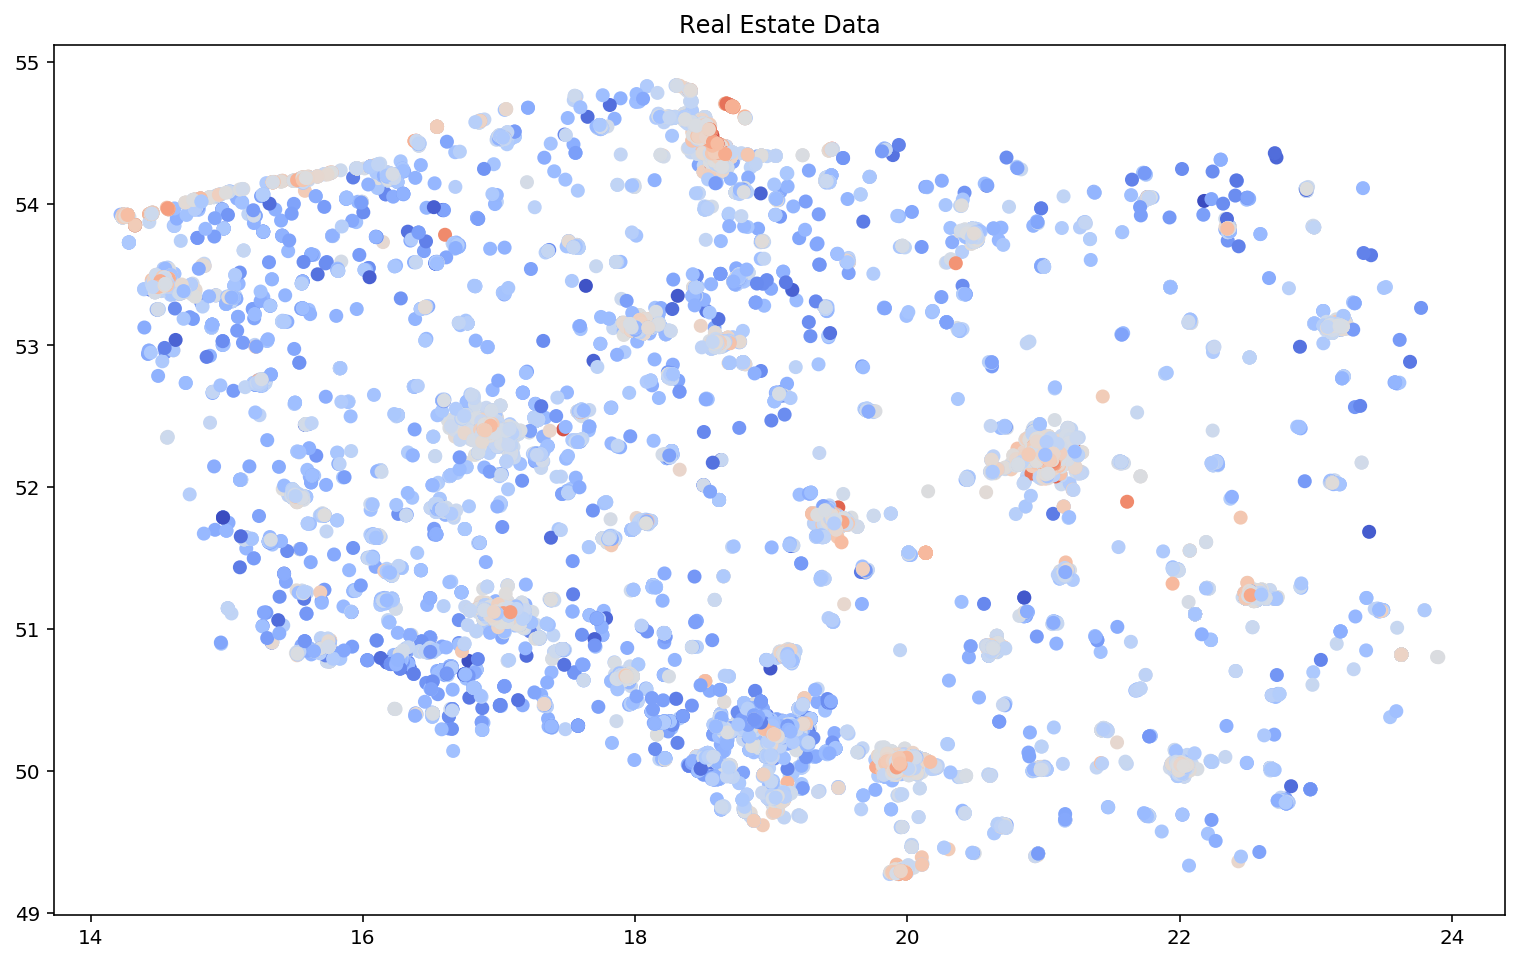

In [901]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 1, 1)
ax.set_title("Real Estate Data")

plt.scatter(full_train.loc_longitude,
            full_train.loc_latitude,
            cmap="coolwarm",
            c=(full_train.price_log/ full_train.price_log.max())*10)

_ = plt.plot()

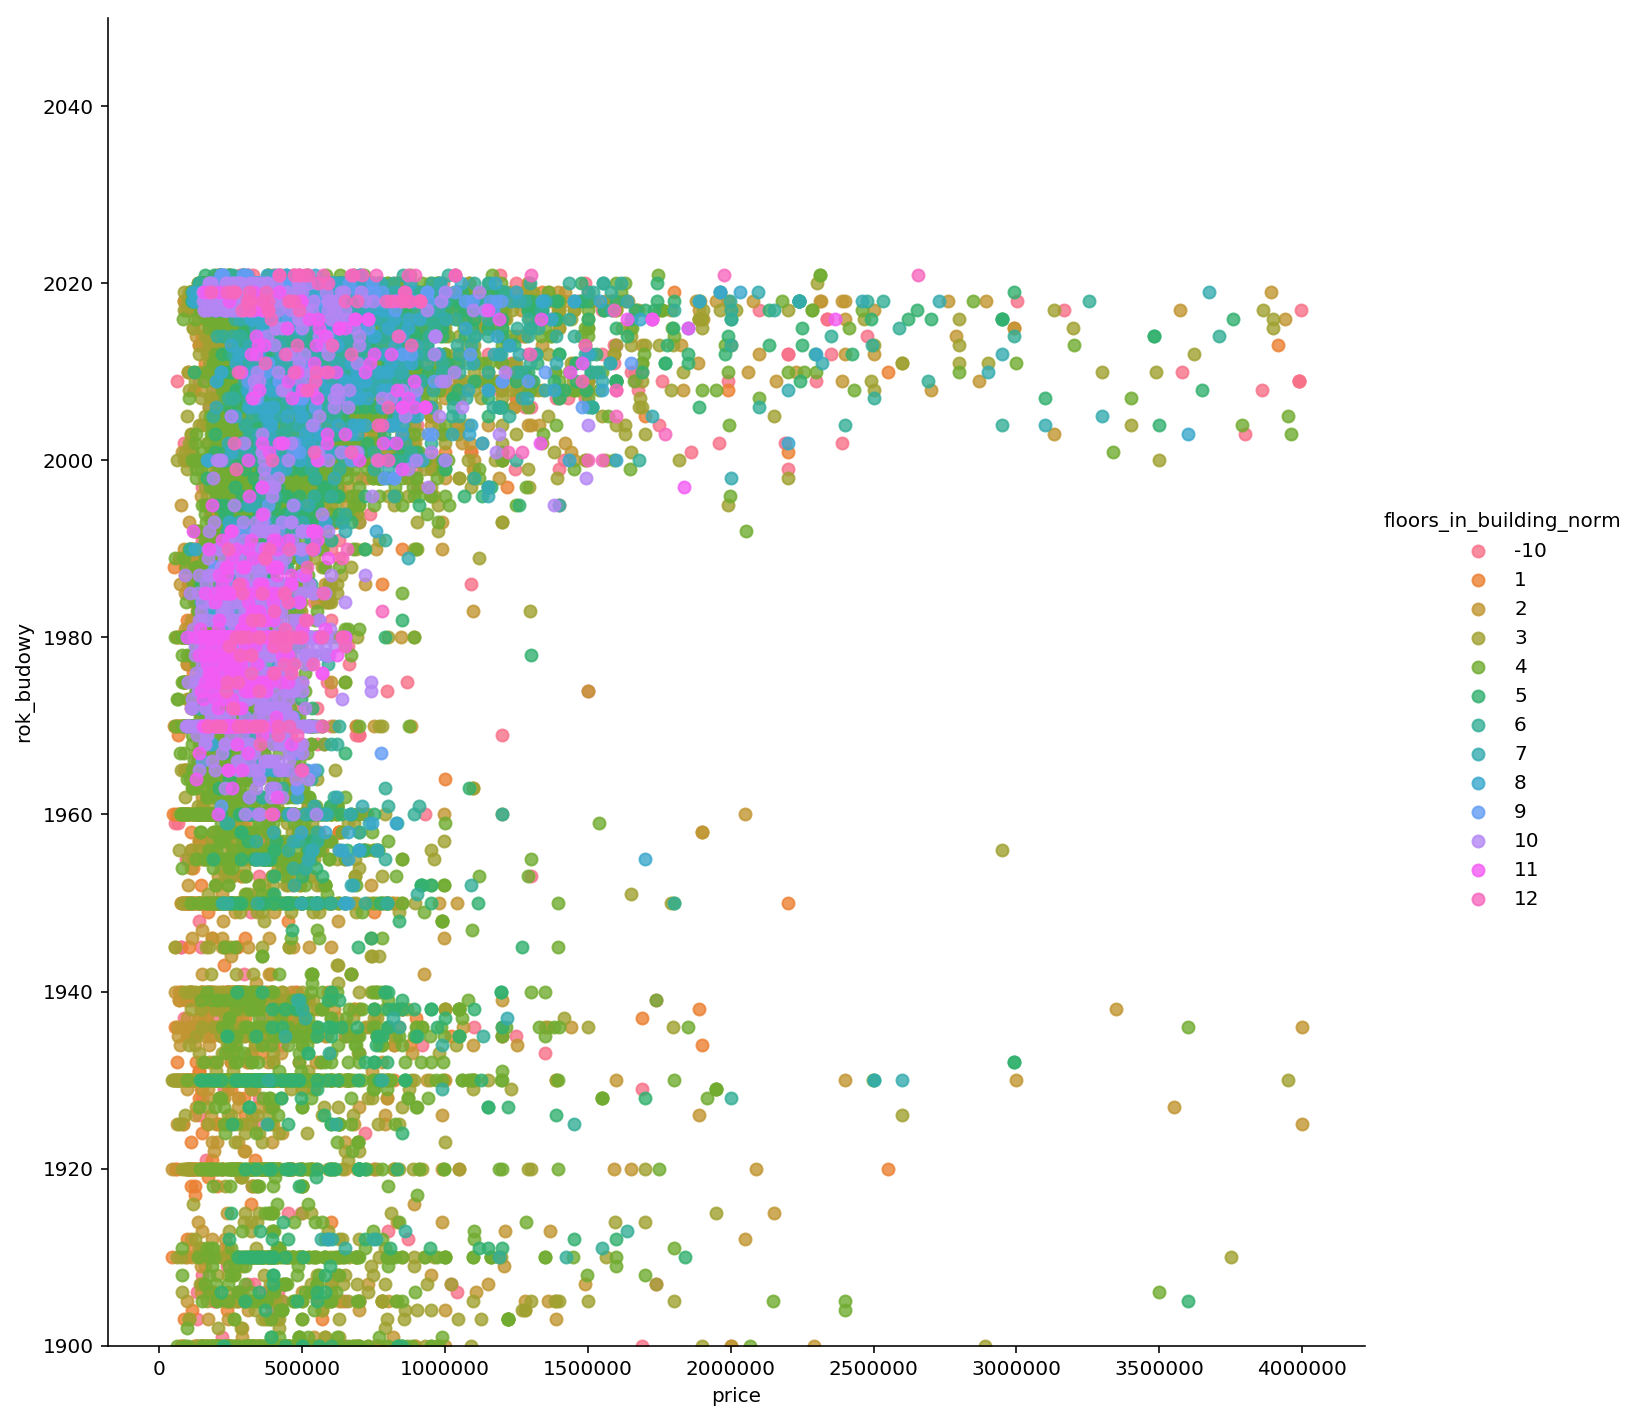

In [575]:
g = sns.lmplot('price', 'rok_budowy',
           data=full_train,
           hue='floors_in_building_norm', 
           fit_reg=False,
          height=10,
            )
g.set(ylim=(1900, 2050))

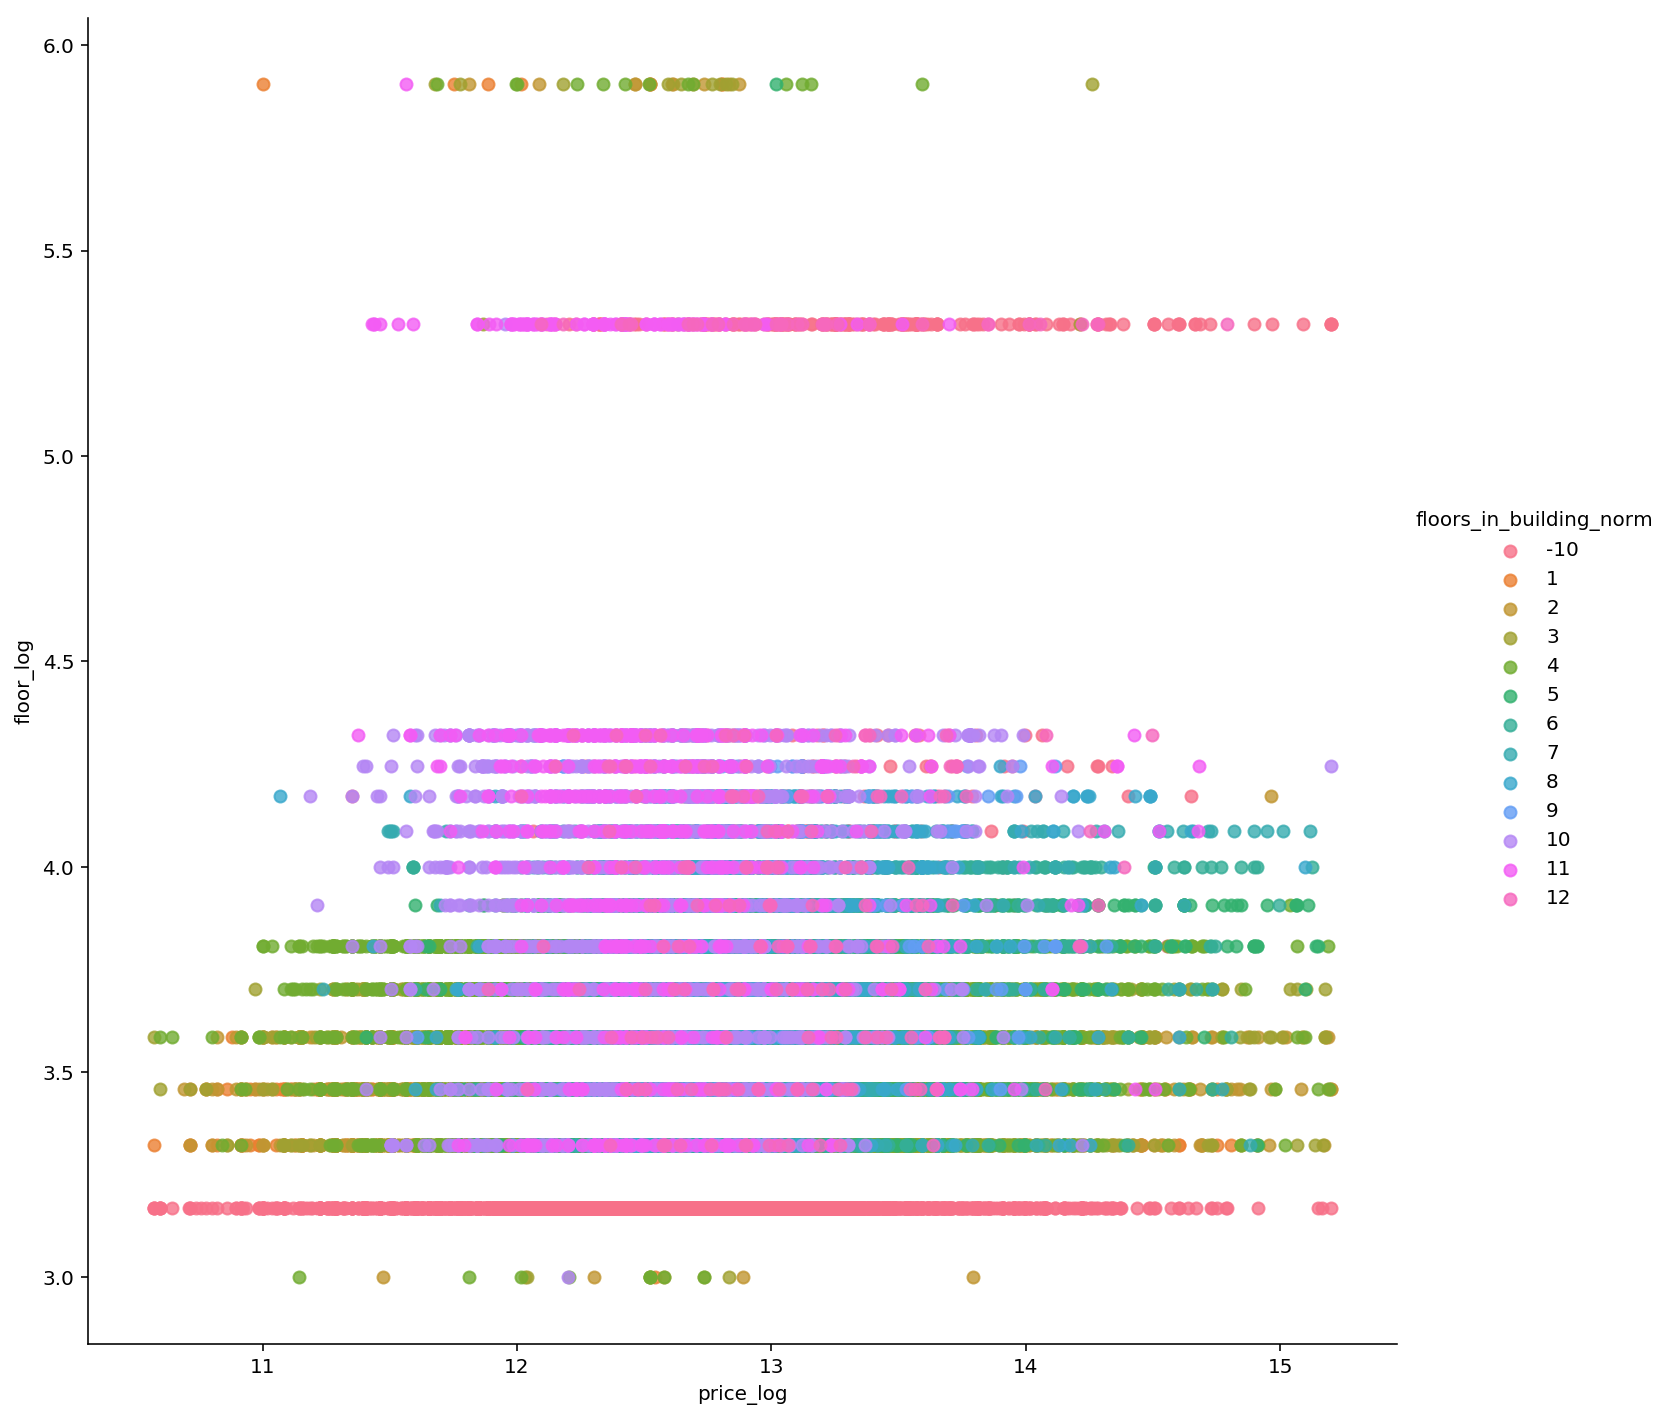

In [578]:
g = sns.lmplot('price_log', 'floor_log',
           data=full_train,
           hue='floors_in_building_norm', 
           fit_reg=False,
          height=10,
            )

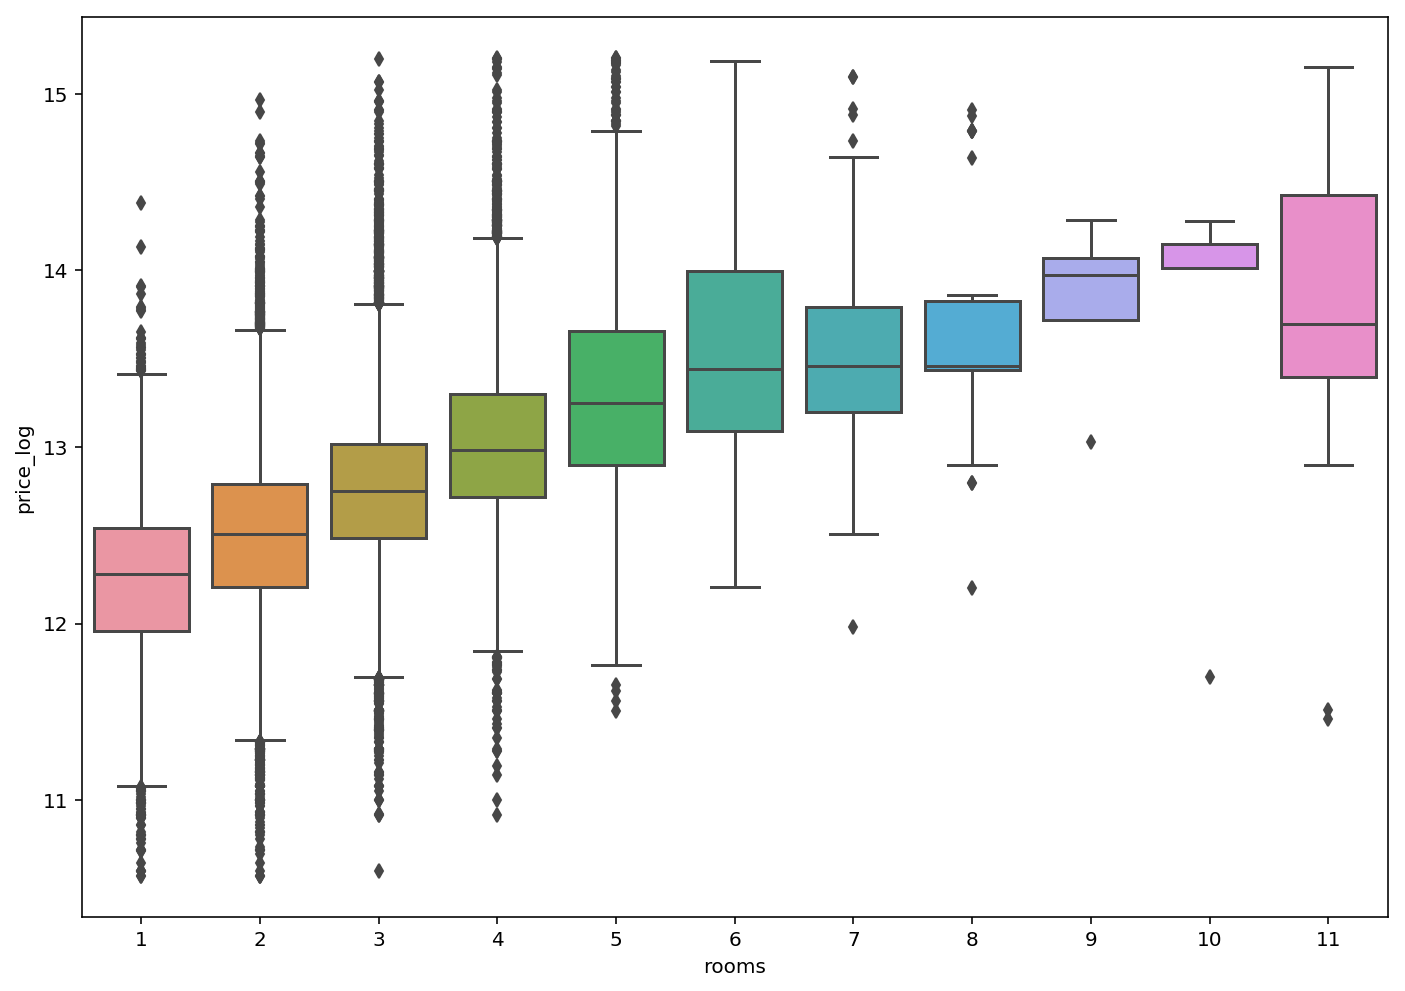

In [660]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(x='rooms', y='price_log', data=full_train, ax=ax)

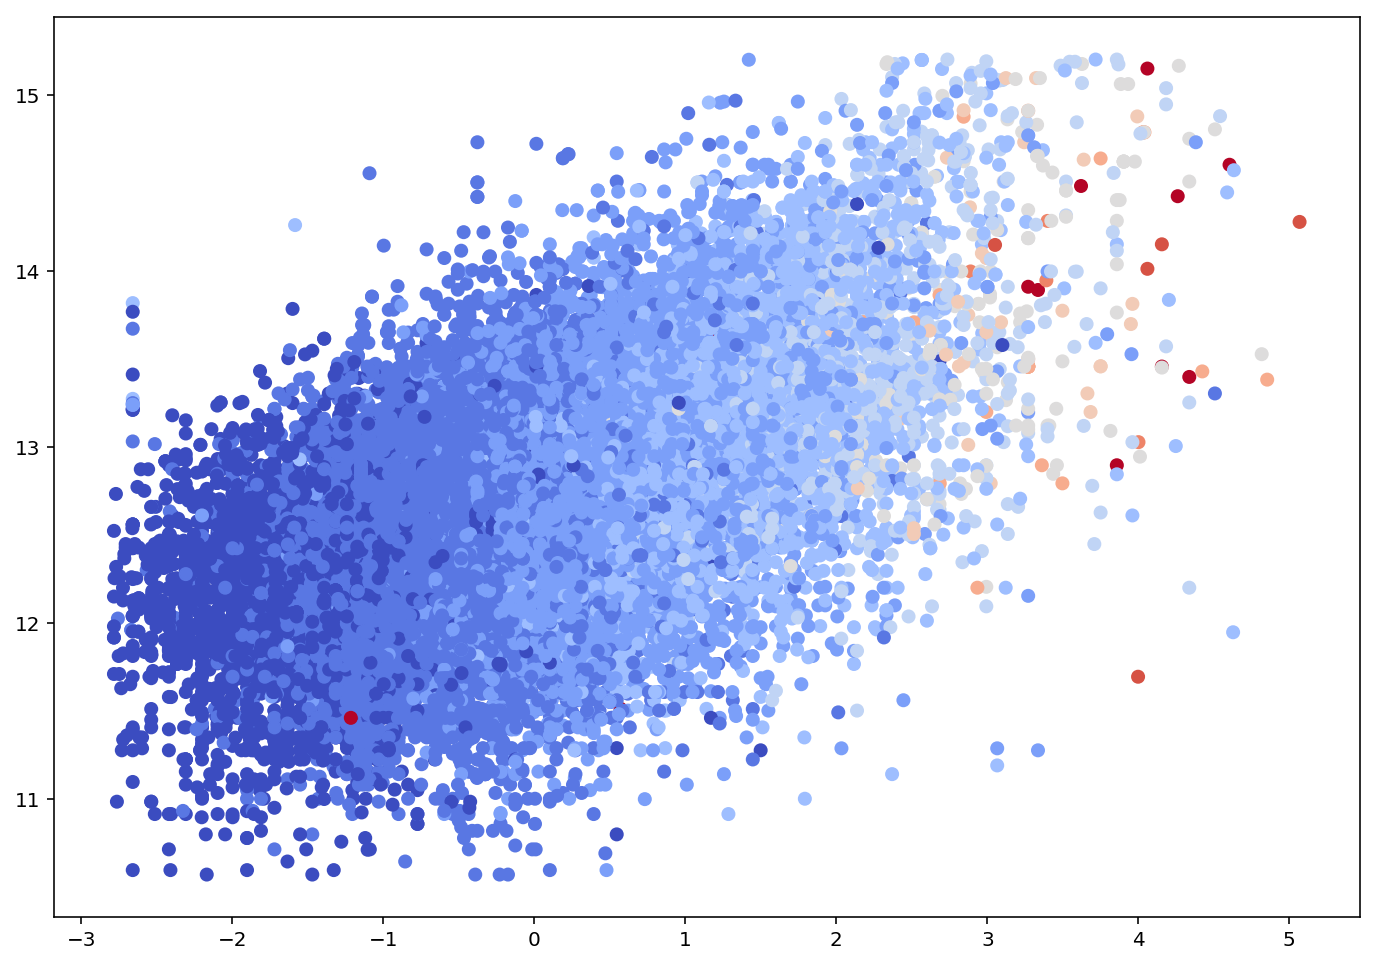

In [670]:
# full_train['rooms'].unique()
plt.figure(figsize=a4_dims)
plt.scatter(full_train.area, full_train.price_log,
           cmap="coolwarm",
            c=(full_train.rooms/ full_train.rooms.max()*10))
# full_train.area.plot()

# FE

### Area

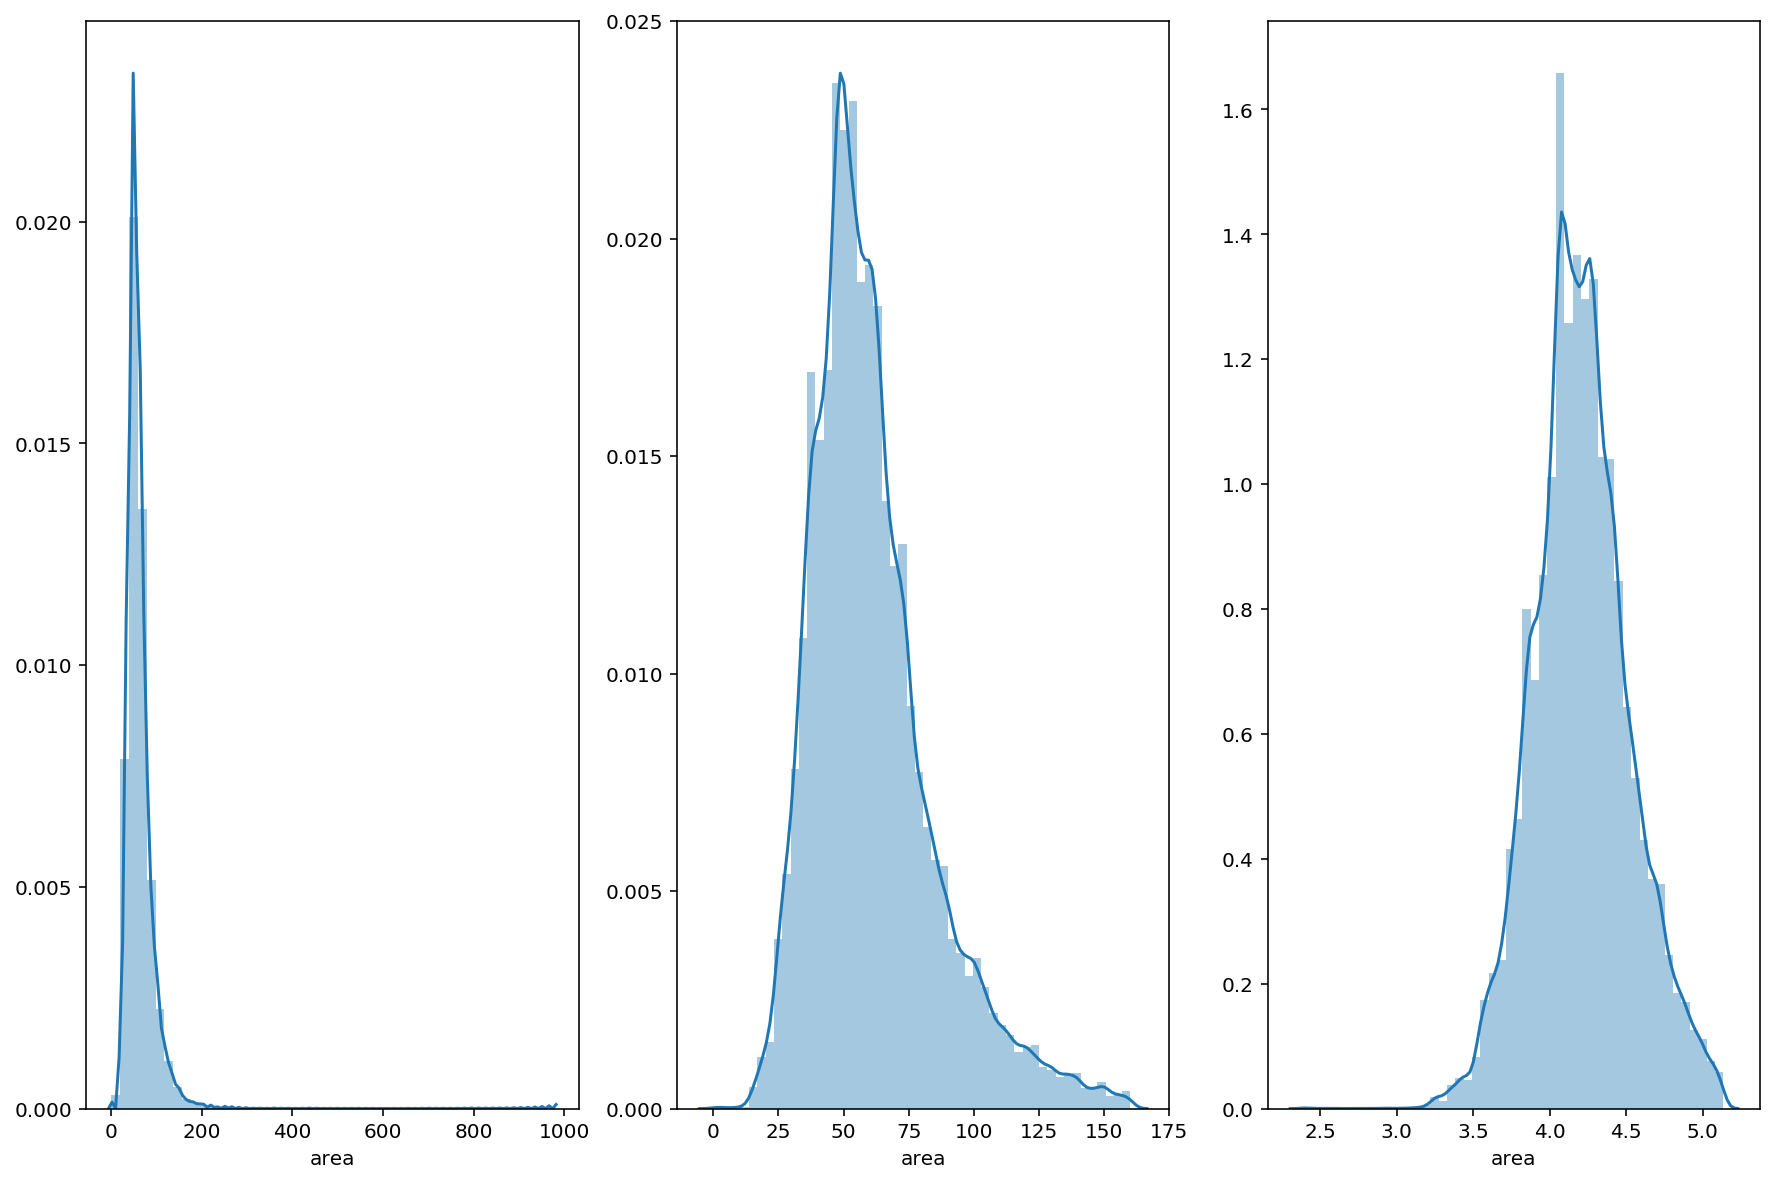

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
sns.distplot(full_data.area, ax=axes[0])
sns.distplot(full_data.area[full_data.area<full_data.area.quantile(.99)], ax=axes[1])
sns.distplot(np.log(full_data.area[full_data.area<full_data.area.quantile(.99)]+10), ax=axes[2])

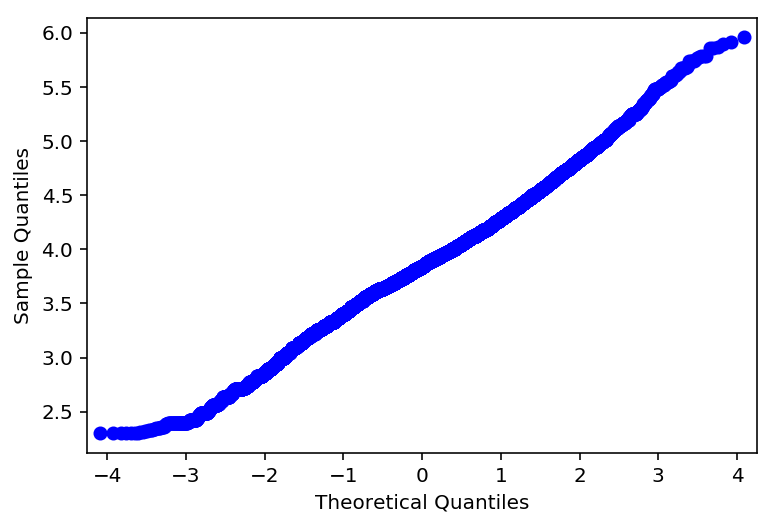

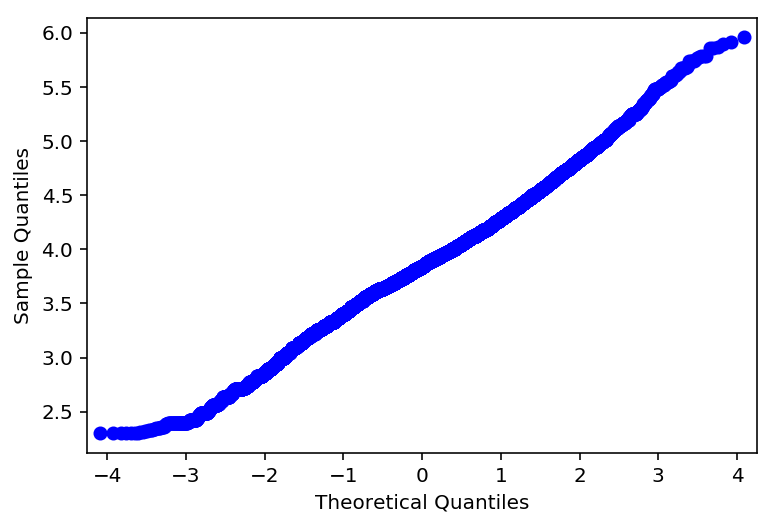

In [17]:
import statsmodels.api as sm
import scipy.stats
my_area = np.log(full_train.area[(full_train.area>20)&(full_train.area<400)]-10)
sm.qqplot(my_area, dist=scipy.stats.distributions.norm, loc=my_area.mean(), scale=my_area.std())

In [18]:
my_area.skew(), full_train.area.skew()

(0.07469725743064136, 5.5398083212383415)

In [129]:
# my_log_area = np.log(my_area)
# sm.qqplot(my_log_area, dist=scipy.stats.distributions.norm, loc=my_log_area.mean(), scale=my_log_area.std())

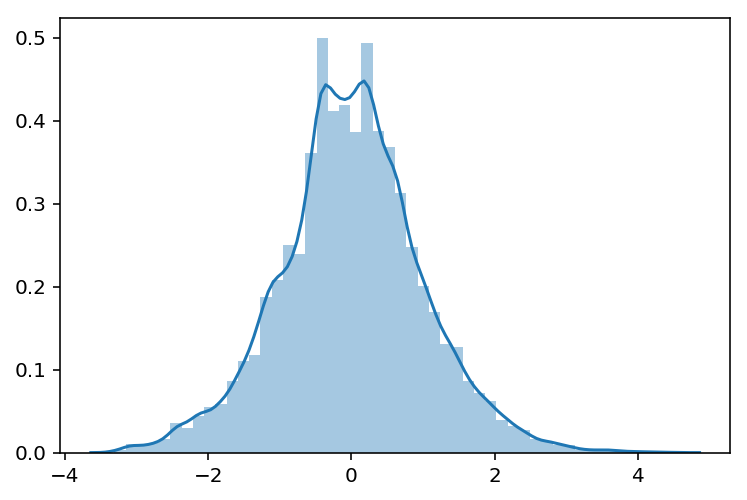

In [19]:
# summary()
sns.distplot(StandardScaler().fit_transform(my_area.values.reshape(-1,1)))#.hist(bins=20)

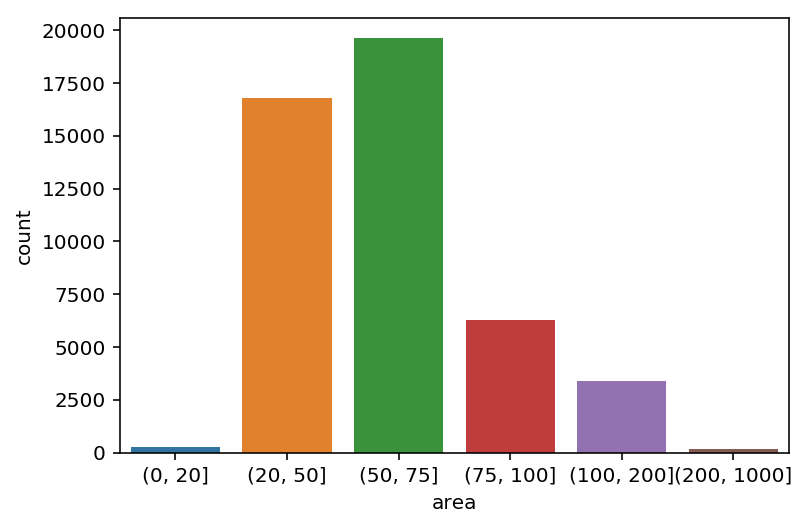

In [20]:
sns.countplot(pd.cut(full_train.area, bins=[0,20,50,75,100,200,1000]))

### Price

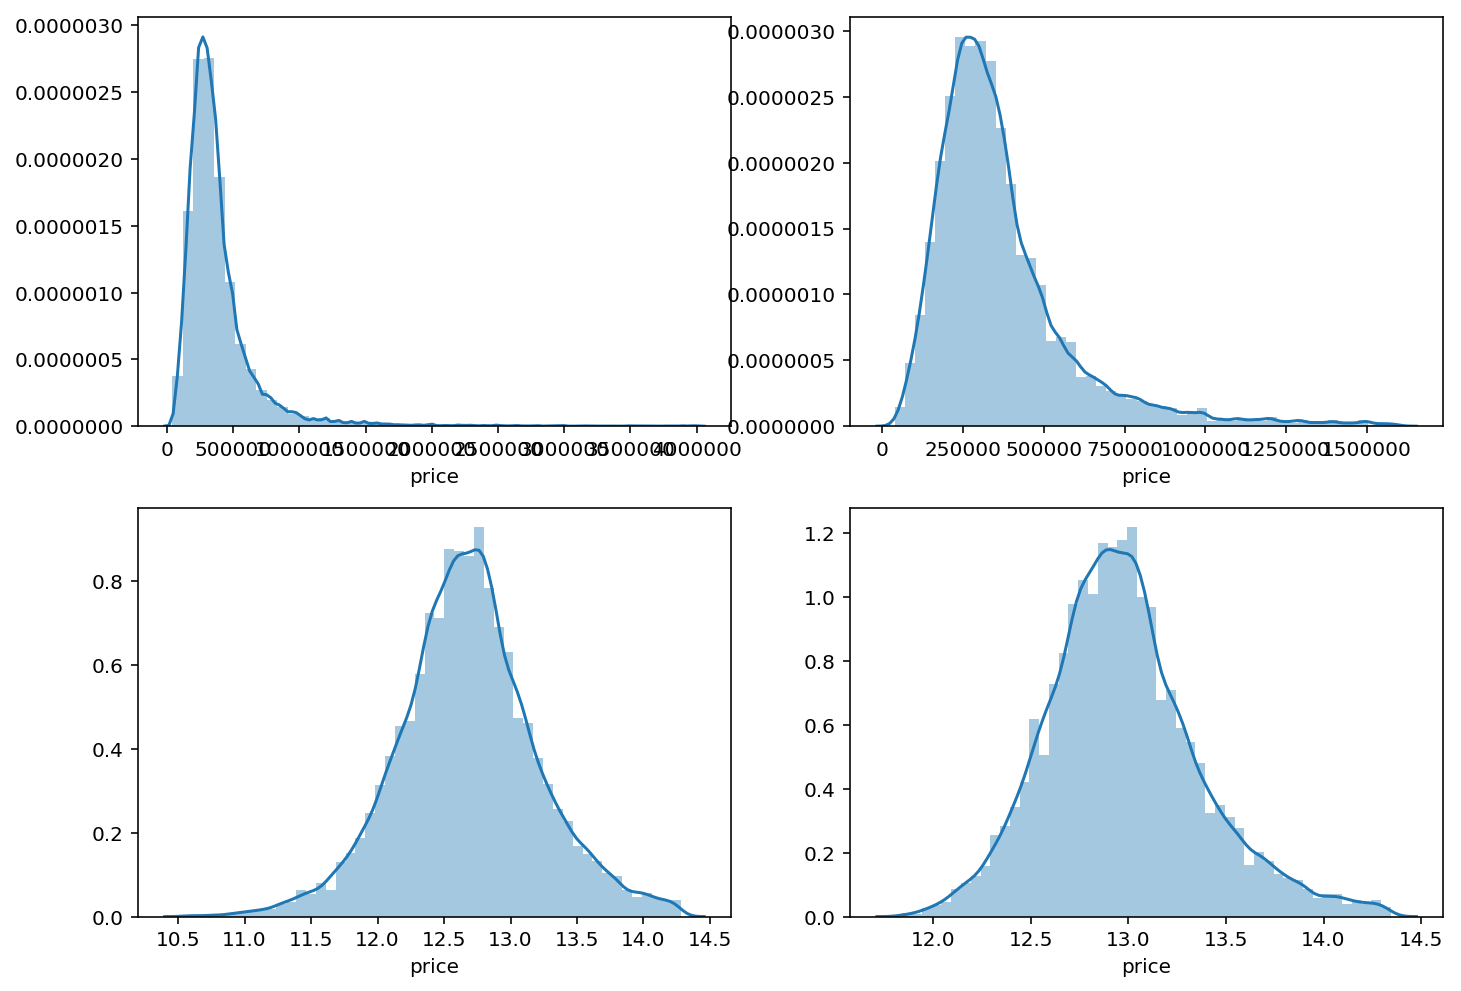

In [597]:
my_price = full_train.price
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11.7, 8.27))

sns.distplot(my_price, ax=axes[0,0])
sns.distplot(my_price[my_price<my_price.quantile(.99)], ax=axes[0,1])
sns.distplot(np.log(my_price[my_price<my_price.quantile(.99)]), ax=axes[1,0])
sns.distplot(np.log(my_price[my_price<my_price.quantile(.99)]+100000), ax=axes[1,1])


In [87]:
def summary(values, percentiles=[1, 5, 95, 99, 100]):
    for percnetile in percentiles:
        print('{0}th -> {1}'.format(percnetile, np.percentile(values, percnetile) ))

In [187]:
summary(my_price)

1th -> 85000.0
5th -> 135000.0
95th -> 854820.0
99th -> 1650000.0
100th -> 16000000.0


In [206]:
my_price[my_price<my_price.quantile(.001)].max(),my_price[my_price>my_price.quantile(.999)].min() 

(38000, 4030400)

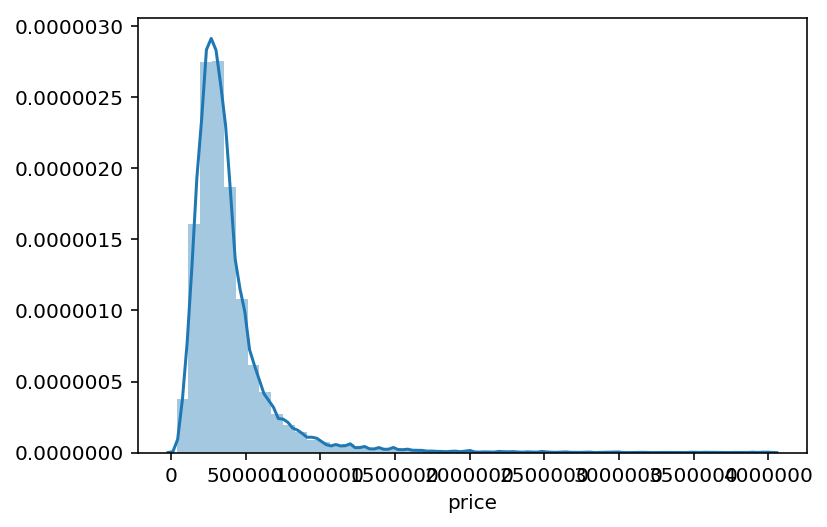

In [212]:
sns.distplot(full_train[(full_train.price>38000)&(full_train.price<4030400)].price)

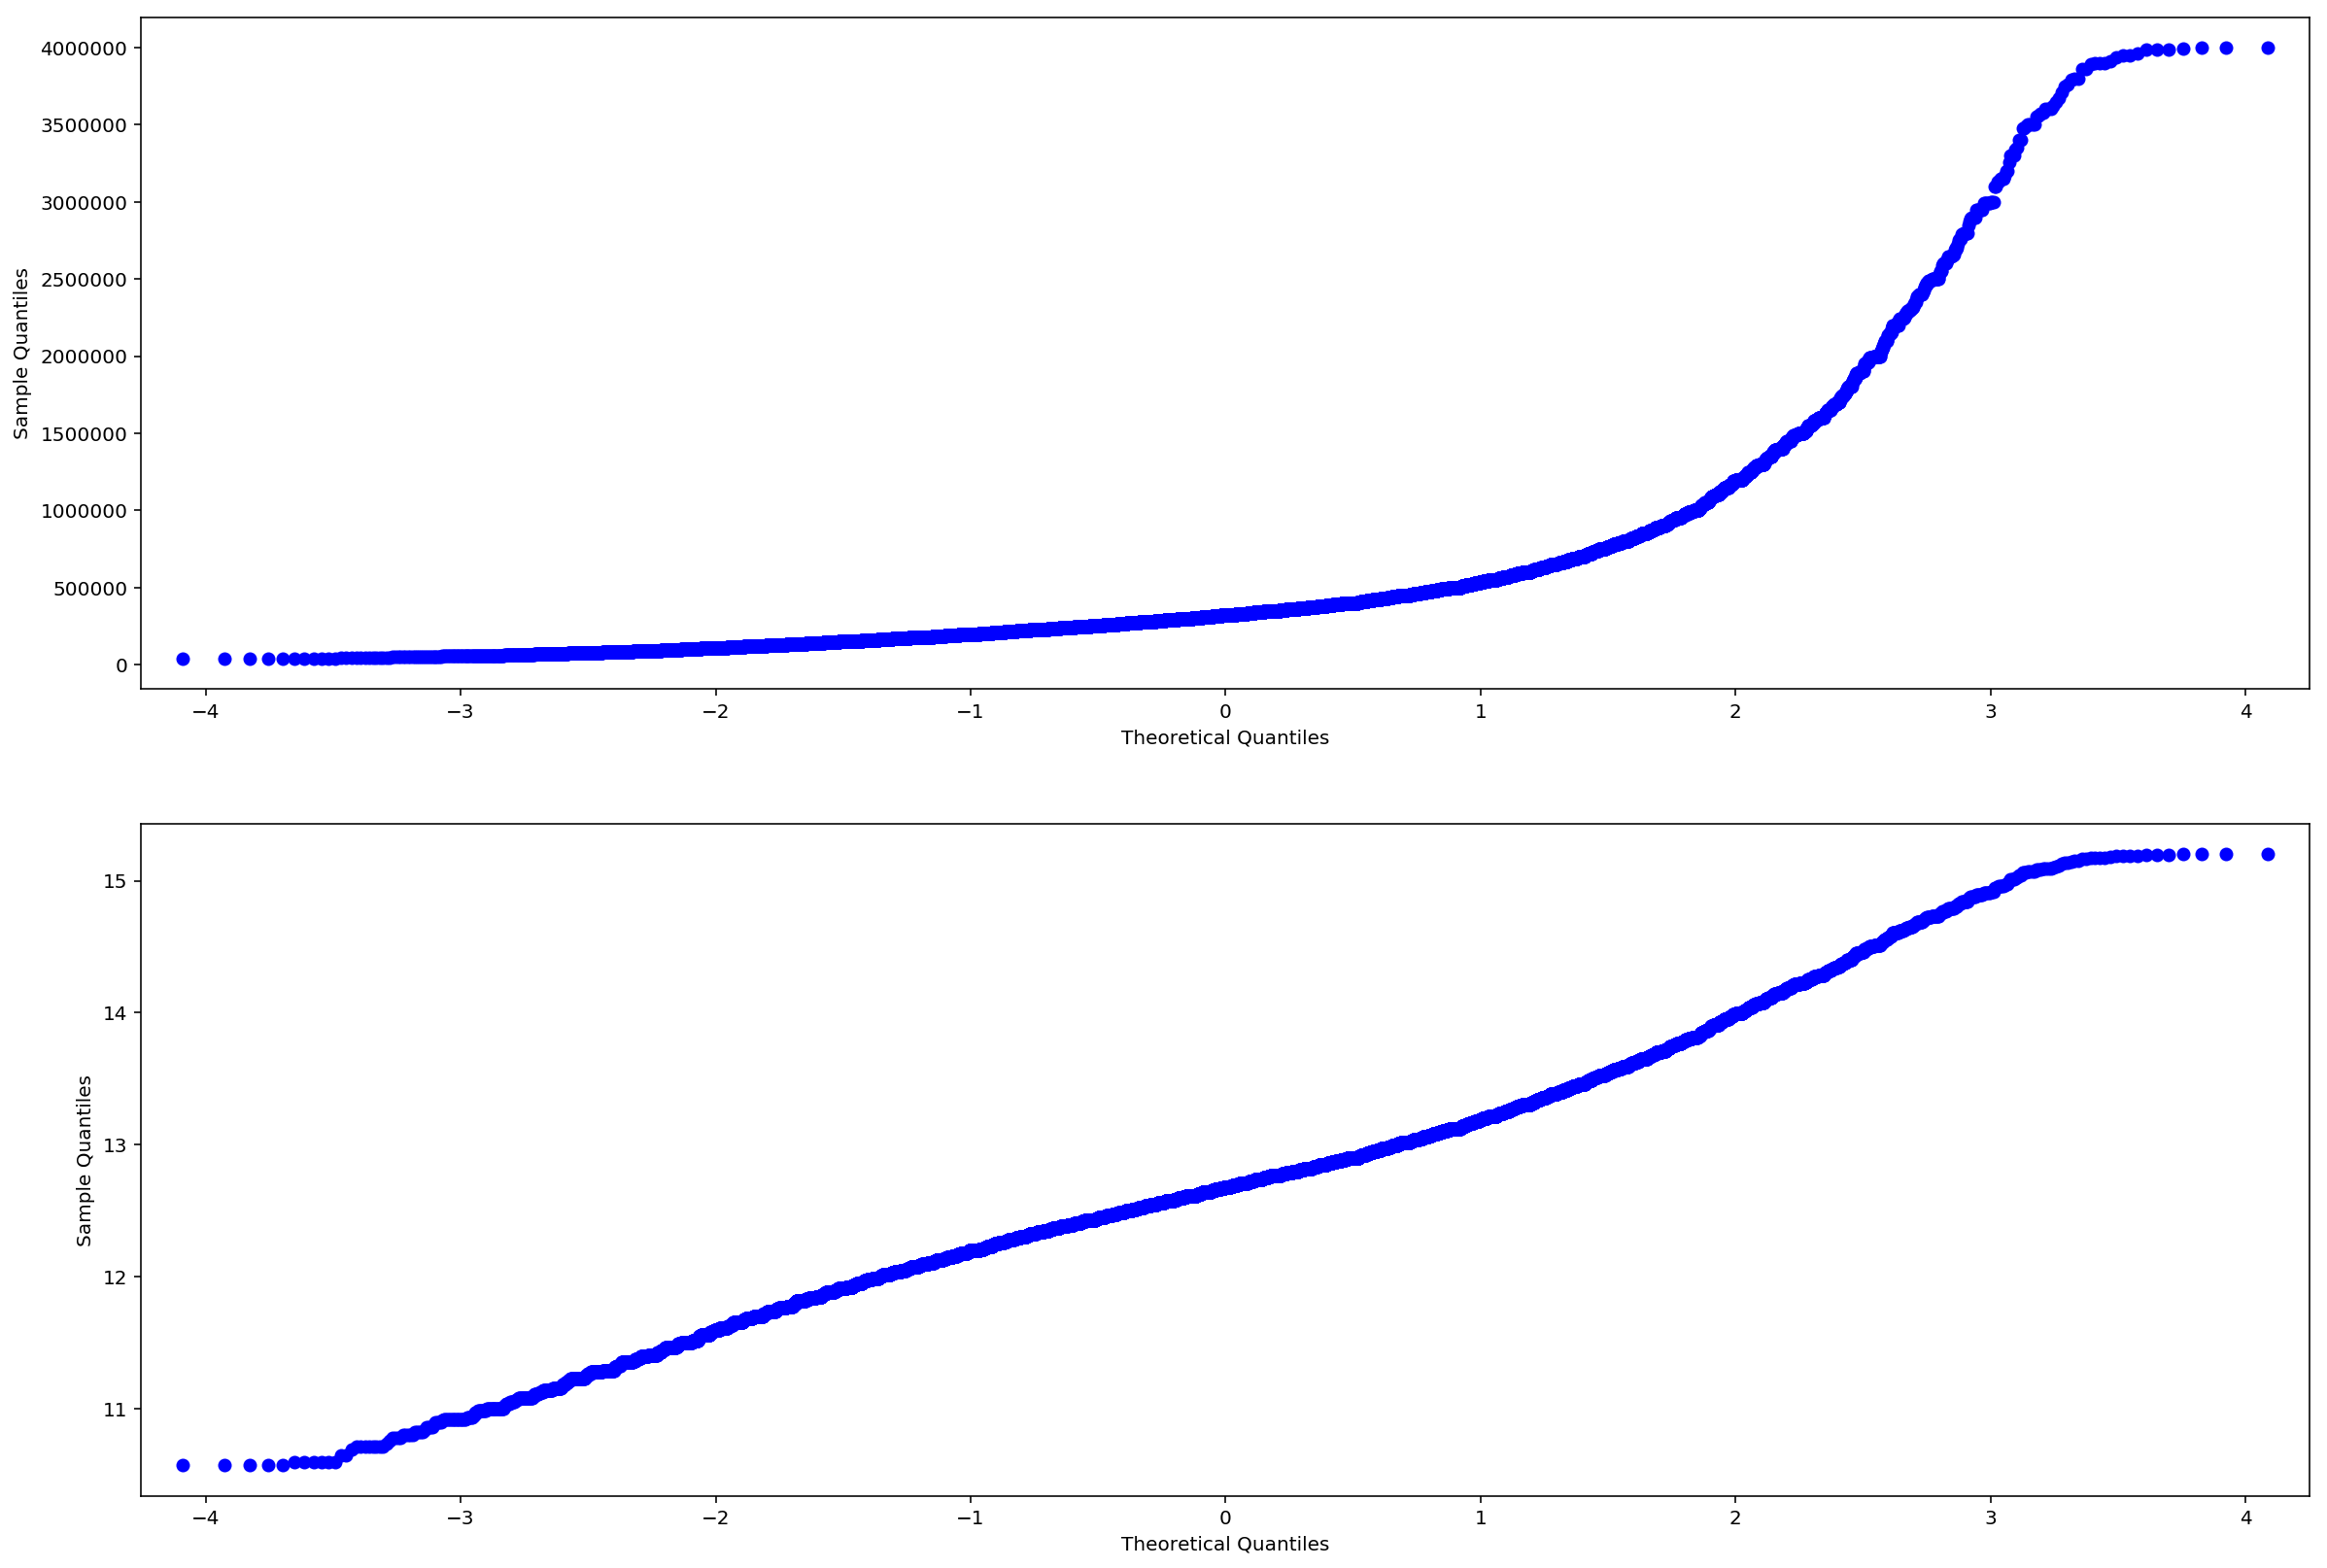

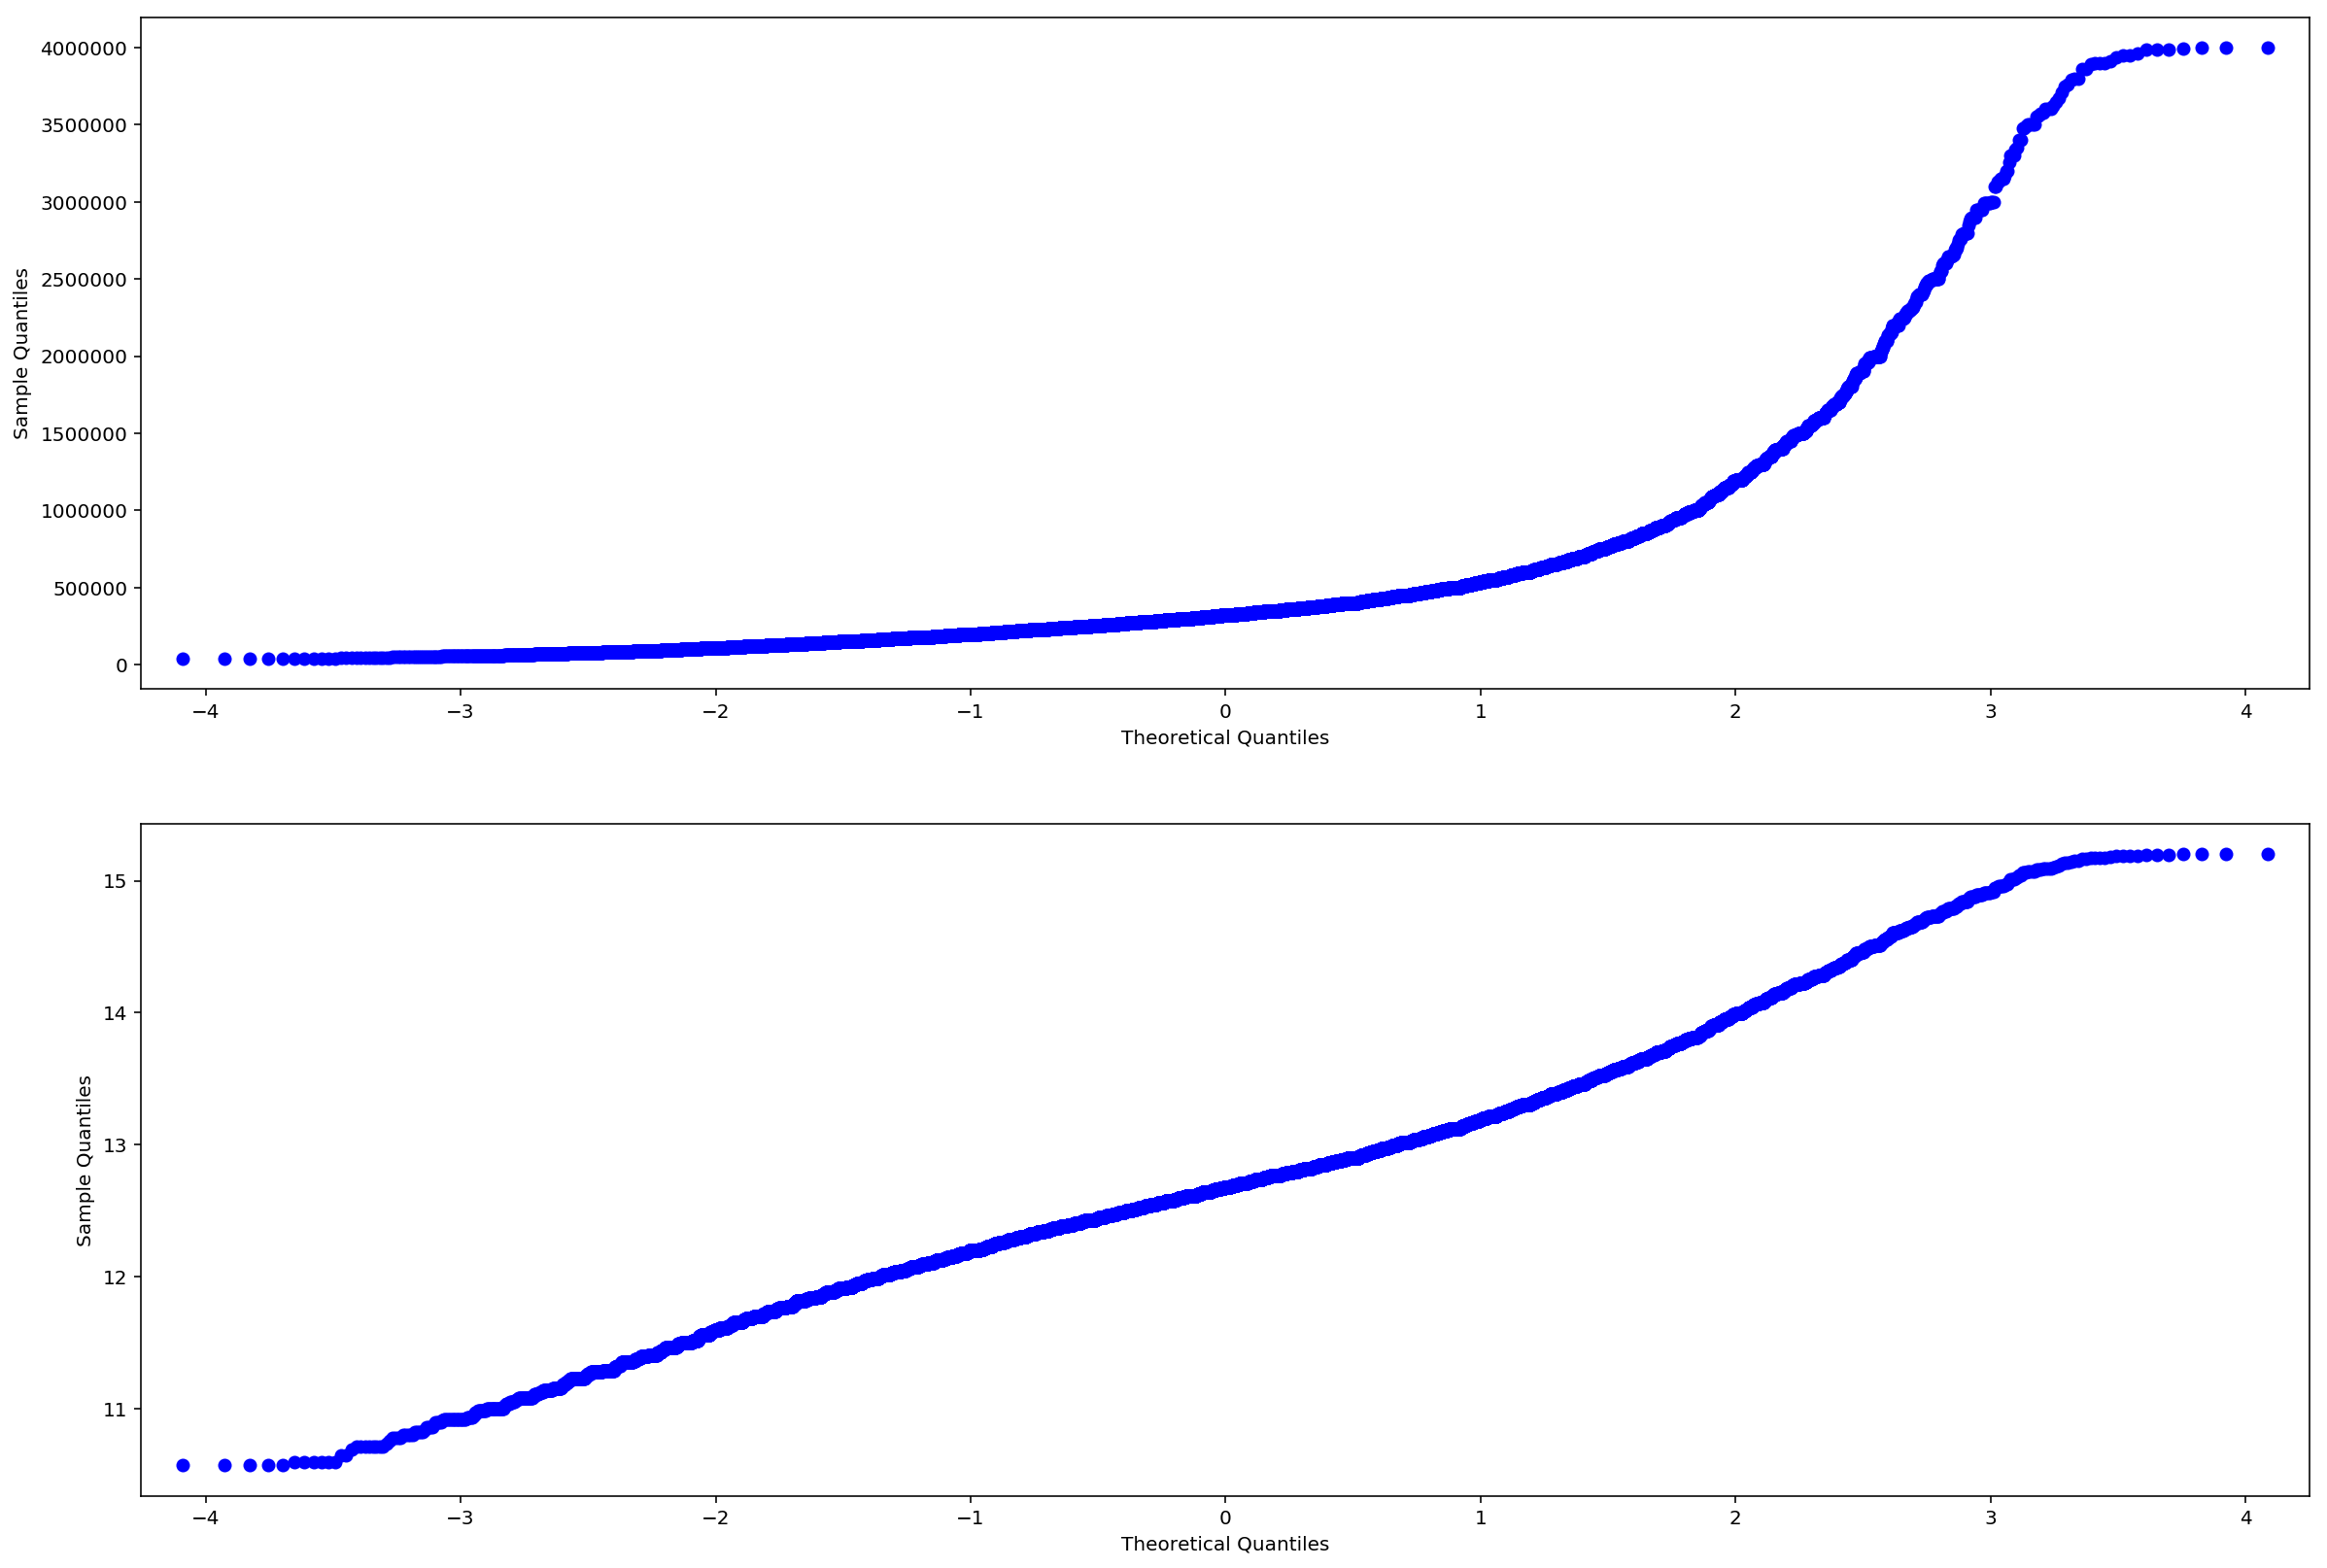

In [216]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 14))

my_price = full_train[(full_train.price>38000)&(full_train.price<4030400)].price
sm.qqplot(my_price, dist=scipy.stats.distributions.norm, loc=my_price.mean(), scale=my_price.std(), ax=axes[0])

my_price_log = np.log(full_train[(full_train.price>38000)&(full_train.price<4030400)].price)
sm.qqplot(my_price_log, dist=scipy.stats.distributions.norm, loc=my_price_log.mean(), scale=my_price_log.std(), ax=axes[1])

### Normalizacja miast

In [15]:
cities_cnt_values = full_data.city.value_counts().reset_index()
cities_cnt_values =  list(cities_cnt_values[cities_cnt_values.city>20]['index'])
full_data['city'] = full_data.city.apply(lambda x: x if x in cities_cnt_values else 'other')

In [ ]:
full_data.price_log

### Price per miasto

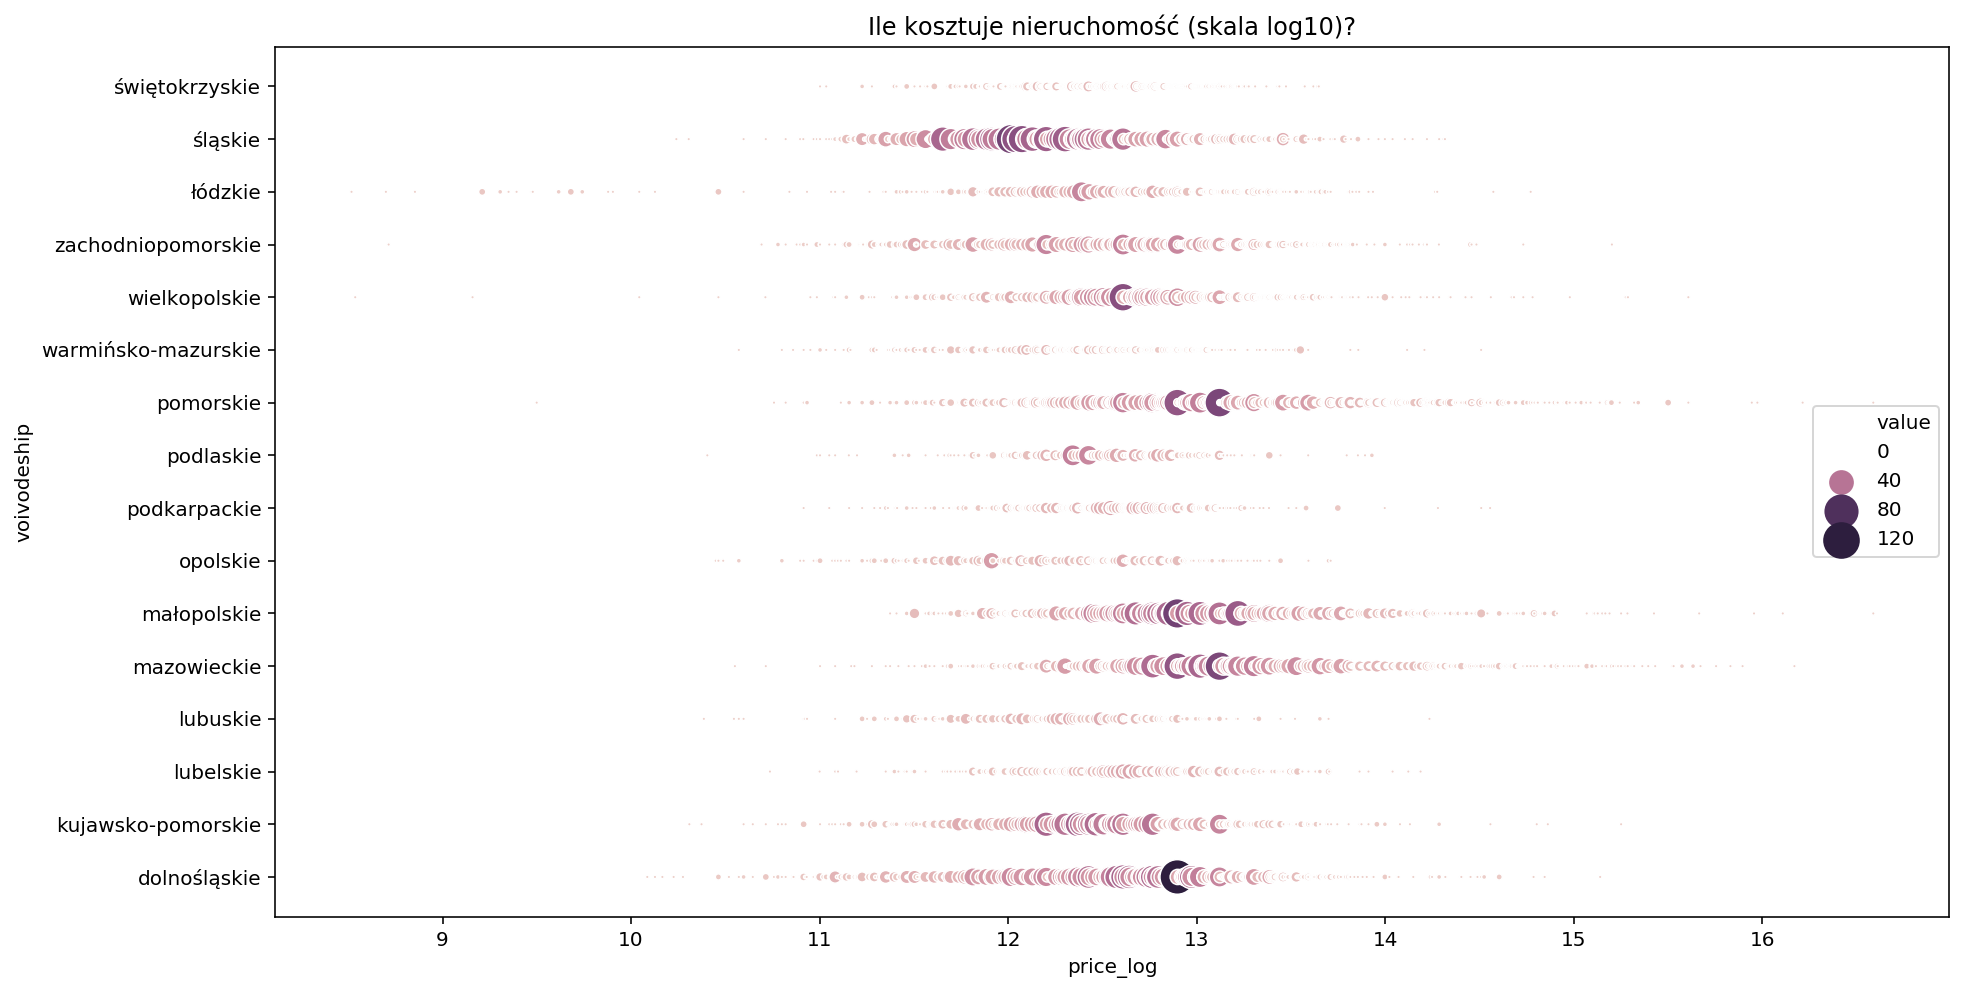

In [41]:
ct = pd.crosstab(full_data.loc[~full_data.price.isnull(), 'price_log'], 
                 full_data.loc[~full_data.price.isnull(), 'voivodeship'])
ct['price_log'] = ct.index
ct_melted = pd.melt(ct, id_vars=['price_log'])

plt.figure(figsize=(15,8))
plt.title("Ile kosztuje nieruchomość (skala log10)?")
sns.scatterplot(x='price_log', y='voivodeship', hue='value', size='value', sizes=(0, 300), data=ct_melted);

In [16]:
median_price = full_data.loc[~full_data.price.isnull()][ ['city', 'price'] ].groupby(['city']).median().to_dict()['price']
mean_price = full_data.loc[~full_data.price.isnull()][ ['city', 'price'] ].groupby(['city']).mean().to_dict()['price']
mode_price = full_data.loc[~full_data.price.isnull()][ ['city', 'price'] ].groupby(['city']).price.apply(lambda x: (x.mode().max()-x.mode().min())/2 if len(x.mode())>1 else x.mode().iloc[0]).to_dict()
full_data['price_median'] = full_data['city'].map(lambda x: median_price.get(x,0))
full_data['price_mean'] = full_data['city'].map(lambda x: mean_price.get(x,0))
full_data['price_mode'] = full_data['city'].map(lambda x: mode_price.get(x,0))

### Price per pietro

In [17]:
median_p_floor = full_data.loc[~full_data.price.isnull()][ ['floor', 'price'] ].groupby(['floor']).median().to_dict()['price']
mean_p_floor = full_data.loc[~full_data.price.isnull()][ ['floor', 'price'] ].groupby(['floor']).mean().to_dict()['price']

full_data['price_median_floor'] = full_data['floor'].map(lambda x: median_p_floor.get(x,-10))
full_data['price_mean_floor'] = full_data['floor'].map(lambda x: mean_p_floor.get(x,-10))



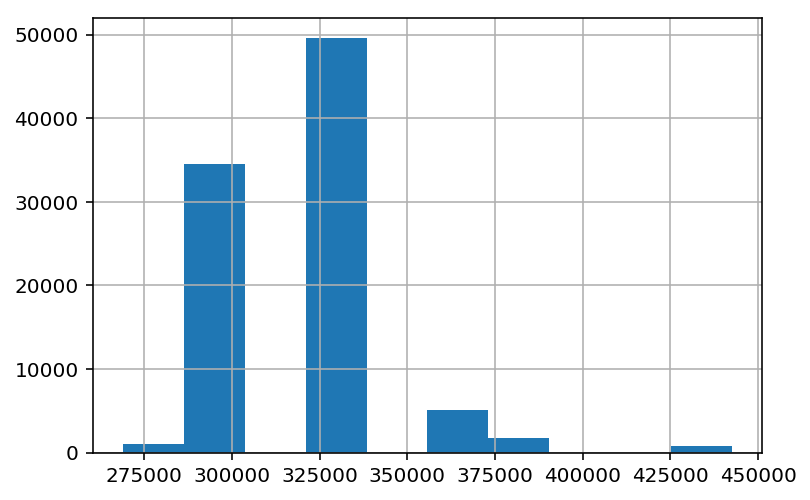

In [20]:
full_data['price_median_floor'].hist(bins=10)

### Cluster i Price per cluster 

In [13]:
from sklearn.cluster import KMeans

X = full_data.loc[~full_data.price.isnull(), ['loc_latitude', 'loc_longitude']]
kmeans = KMeans(n_clusters=1000, random_state=0).fit(X)

In [14]:
kmeans.labels_.shape

(46489,)

In [21]:
full_data.loc[~full_data.price.isnull(), 'loc_kernel'] = kmeans.labels_
# #uzupelnienie kerneli na podstawie kerneli z zestawu train
full_data.loc[full_data.loc_kernel.isnull(), 'loc_kernel'] = kmeans.predict(full_data.loc[full_data.loc_kernel.isnull(), ['loc_latitude', 'loc_longitude']].values)


In [22]:
mean_kernel_price = full_data.loc[~full_data.price.isnull(), ['loc_kernel', 'price'] ].groupby(['loc_kernel']).mean().to_dict()['price']
# full_train['price_mean_kernel'] = np.log(full_train['loc_kernel'].map(lambda x: mean_kernel_price[x])-20000)
full_data['price_mean_kernel'] = full_data['loc_kernel'].map(lambda x: mean_kernel_price[x])

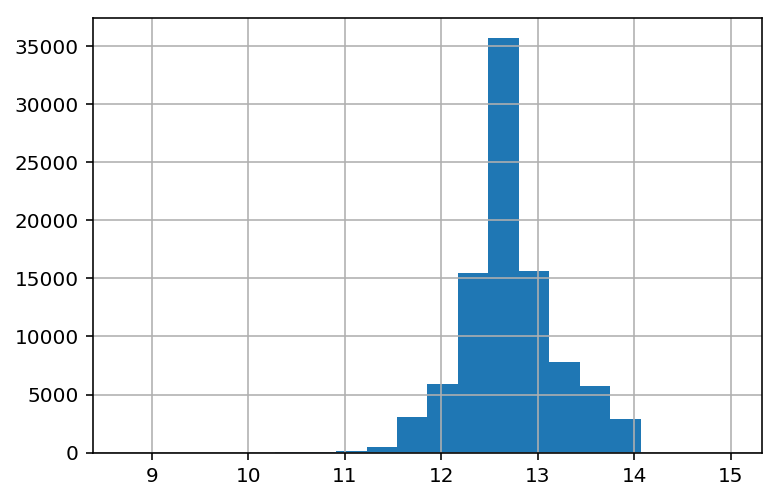

In [396]:
np.log(full_data['price_mean_kernel']-20000).hist(bins=20)

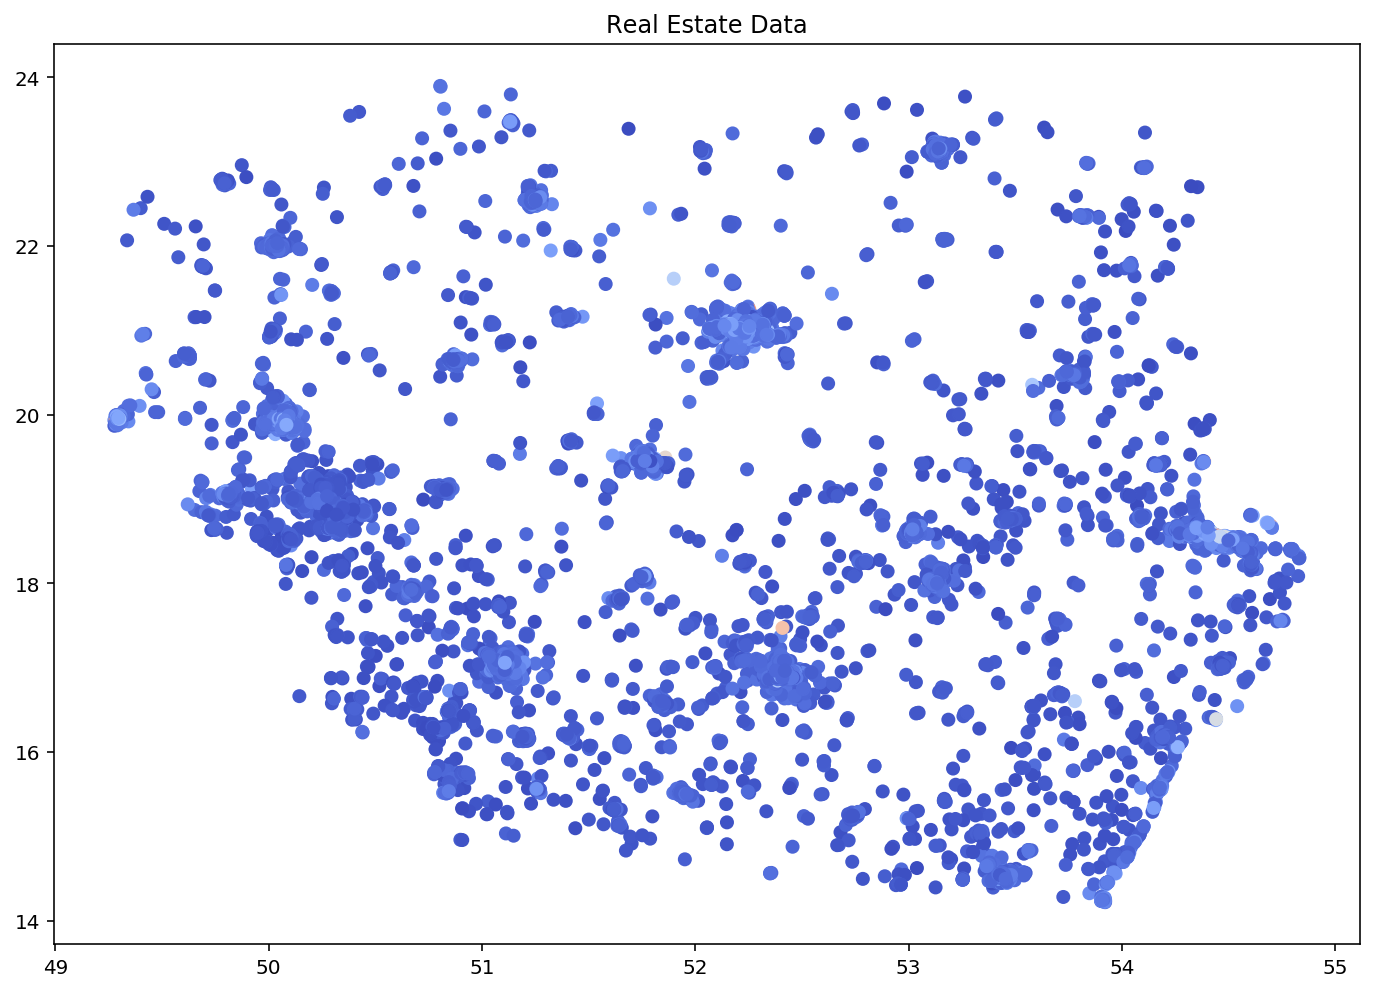

In [900]:
max_c = max(list(mean_kernel_price.values()))
colors = [c/max_c for c in list(mean_kernel_price.values())]

plt.figure(figsize=a4_dims)

ax = plt.subplot(1, 1, 1)
ax.set_title("Real Estate Data")
plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            cmap="coolwarm",
            c=colors)

_ = plt.plot()

### Floors

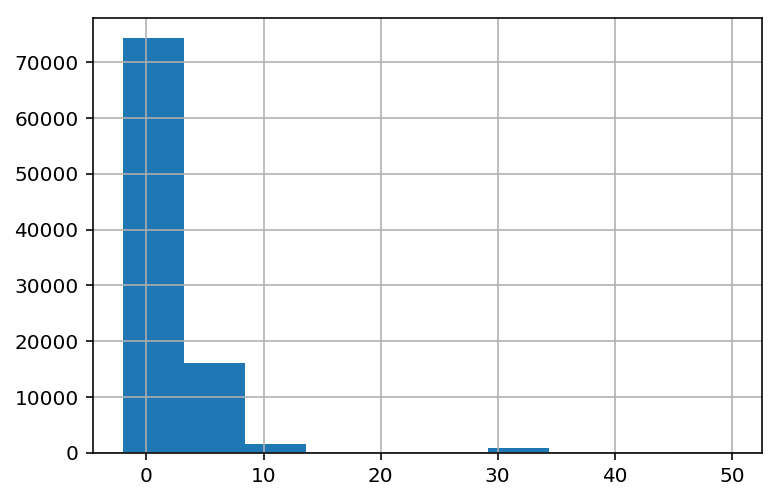

In [23]:
# full_train.floor.value_counts()
map_floor = {
    'parter': 0,
    'suterena': -2,
    'poddasze': 50,
    '> 10': 30
}

full_data['floor'] = full_data.floor.map(lambda x: map_floor[x] if x in map_floor else int(x)).astype('int8')
full_data['floor'].hist()

In [24]:
full_data['apartament_last_floor'] = full_data.floors_in_building == full_data.floor
full_data['apartament_one_before_last_floor'] = full_data.floors_in_building == (full_data.floor + 1)
full_data['apartament_parter'] = full_data.floor == 0

In [25]:
cnt_values =  full_data.floors_in_building.value_counts().reset_index()
cnt_values = dict(cnt_values[cnt_values.floors_in_building>200].values)

full_data['floors_in_building_norm']=full_data.floors_in_building.map(lambda x: x if x in cnt_values else -10)

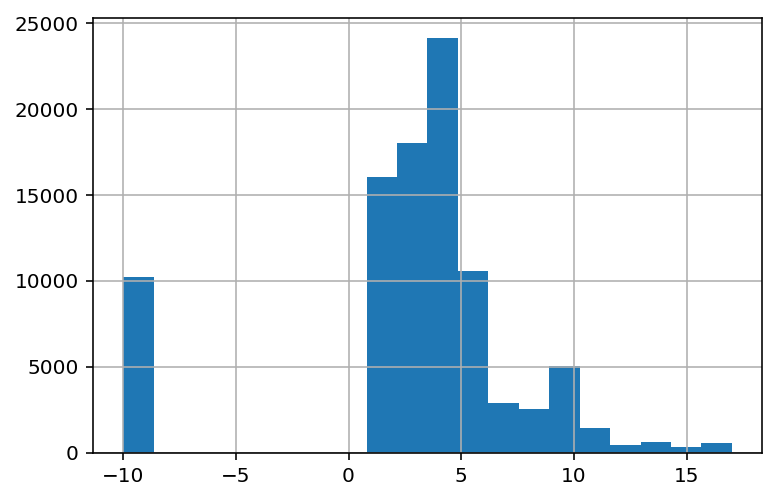

In [26]:
full_data.floors_in_building_norm.hist(bins=20)

### Rok budowy budynku

In [27]:
map_year = {
    'parter': 0,
    'suterena': -2,
    'poddasze': 50,
    '> 10': 30
}
def map_year(x):
    if x<1850:
        return 'unk'
    elif x<1939:
        return 'przed_wojna'
    elif  x<1965:
        return 'sredni_wiek'
    elif x<1995:
        return 'wielka_plyta'
    else:
        return 'nowe_budownictwo'
        

full_data['building_type'] = full_data.rok_budowy.apply(map_year)

### Winda i pietro | metraz i pokoje

In [31]:
wysokie_z_winda= full_data[(full_data.floors_in_building>3)&(full_data.winda==True)]
wysokie_bez_windy= full_data[(full_data.floors_in_building>3)&(full_data.winda==False)]

In [32]:
def elevator_check(x):
    if (x.floors_in_building>3) & (x.winda==False):
        return True
    else:
        return False
full_data['elevator_check'] = full_data.apply(elevator_check, axis=1)

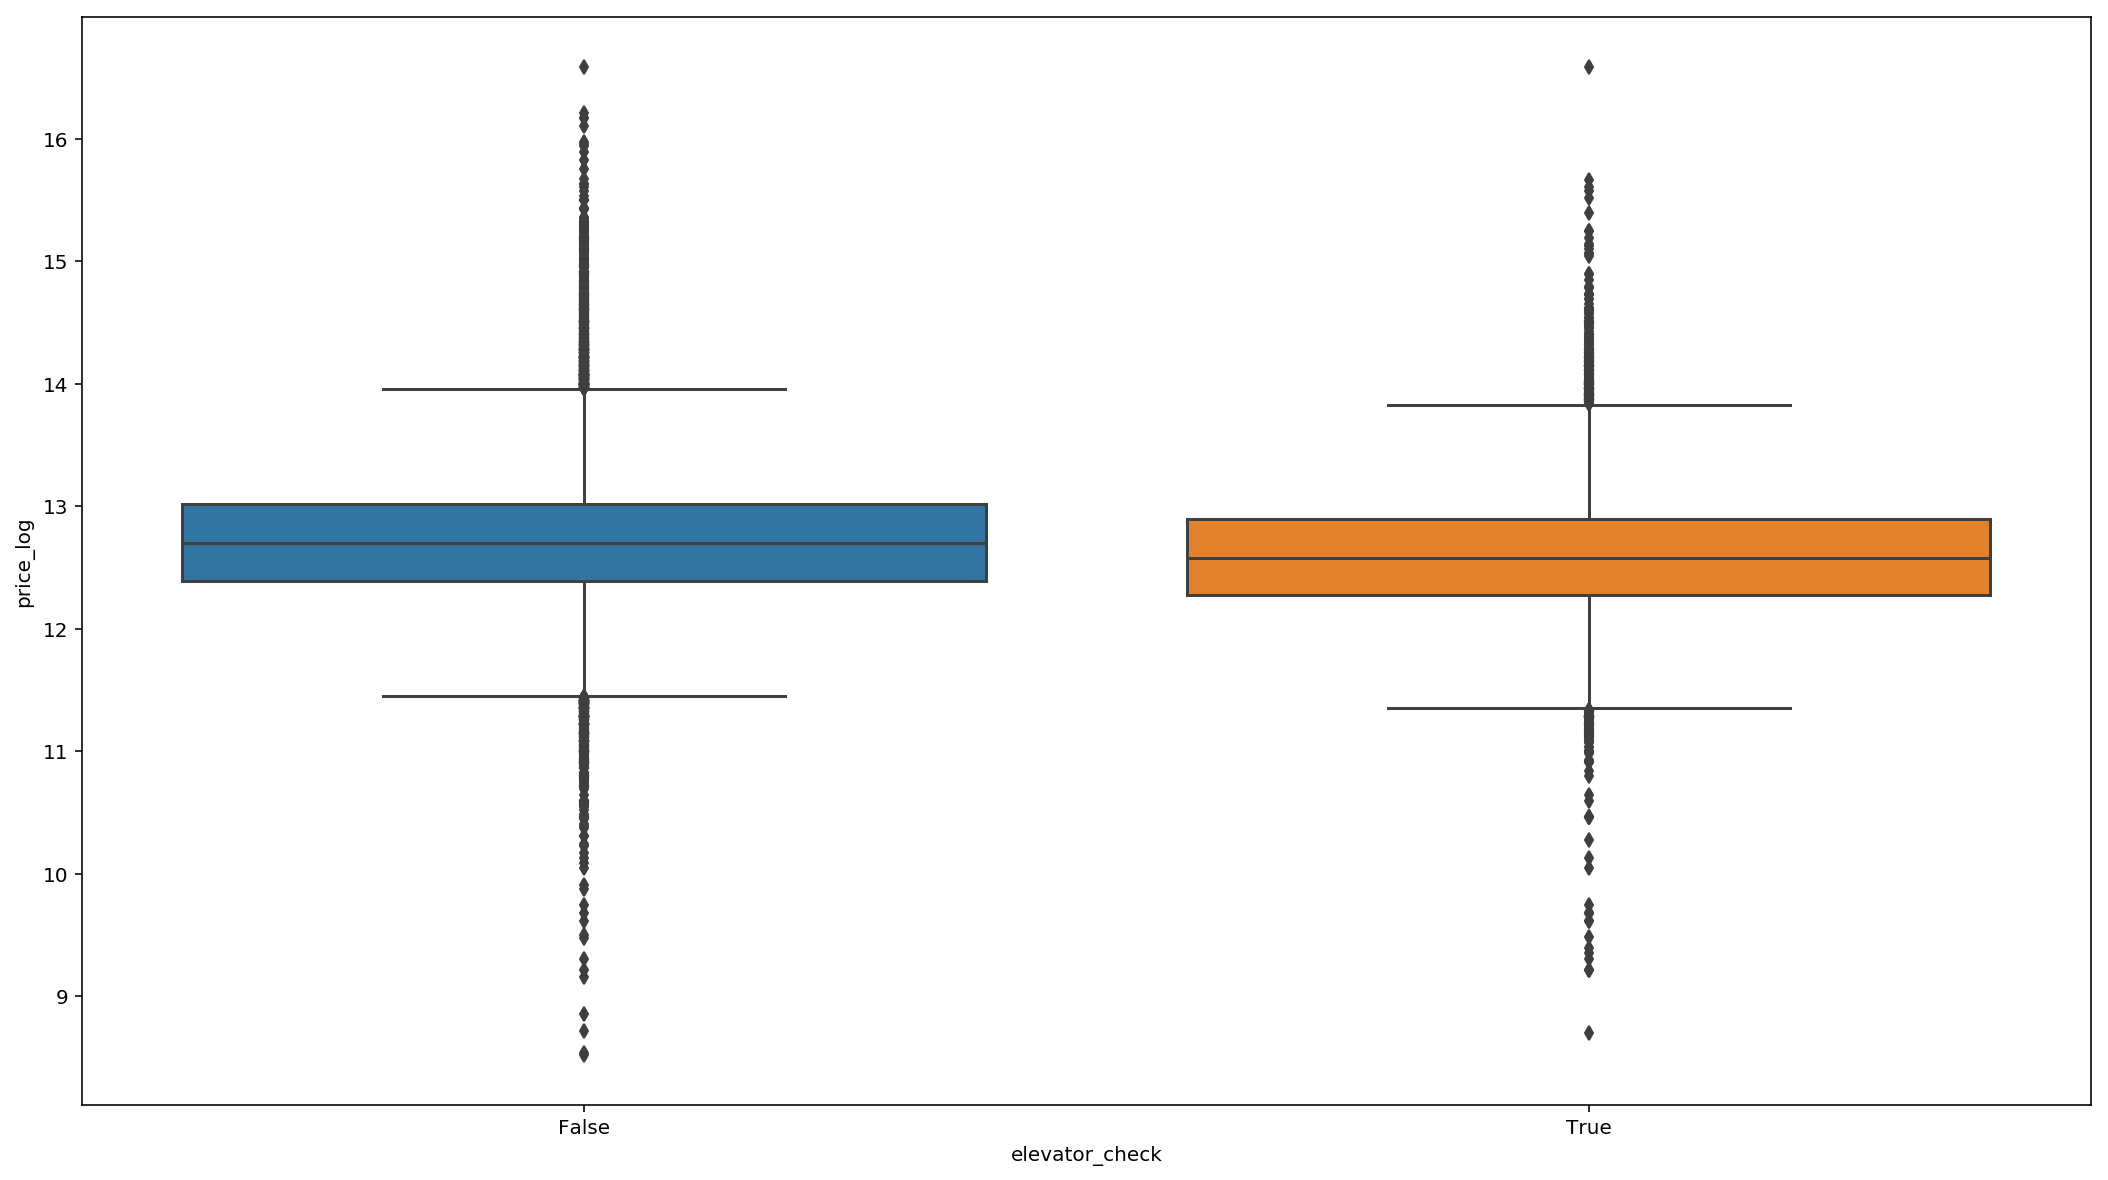

In [33]:
plt.figure(figsize=(18,10))
sns.boxplot(x='elevator_check', y='price_log', data=full_data.loc[~full_data.price.isnull()])

### Description encode

In [42]:
descriptions = full_data_raw.text.apply(lambda x: x.replace('\xa0', ''))

In [43]:

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
                        encoding='utf-8', ngram_range=(1, 1), stop_words=stopwords.words("polish"), max_features=500)
desc_features = tfidf.fit_transform(descriptions).toarray()

In [44]:
full_data_decription = pd.concat([full_data.reset_index(drop=True), pd.DataFrame(desc_features)], axis=1, sort=False)

In [45]:
# pd.DataFrame(desc_features).isnull().sum()
len(full_data), len(full_data_decription)

(92764, 92764)

# Train and predict

### Funkcje pomocnicze

In [50]:
def plot_xgb_learning_curve(train_evals, test_evals, ylim=None):
    mean_train_evals = np.mean(train_evals, axis=0)
    std_train_evals = np.std(train_evals, axis=0)

    mean_test_evals = np.mean(test_evals, axis=0)
    std_test_evals = np.std(test_evals, axis=0)

    plt.figure(figsize=(15, 5))
    if ylim is not None:plt.ylim(*ylim)

    plt.fill_between(range(len(mean_train_evals)), mean_train_evals - std_train_evals*3,
                     mean_train_evals + std_train_evals*3, alpha=0.1,
                     color="r")

    plt.fill_between(range(len(mean_test_evals)), mean_test_evals - std_test_evals*3,
                     mean_test_evals + std_test_evals*3, alpha=0.1,
                     color="g")


    plt.plot(mean_train_evals, label='train', c='r')
    plt.plot(mean_test_evals, label='test', c='g')
    plt.legend(loc='best')
    plt.title("Learning curve")
    plt.xlabel("# iterations")
    plt.ylabel("mae")
    plt.show()
    
    
def cv_xgb(df, feats, xgb_params, shift=1, folds=3, verbose=False, early_stopping_rounds=5, plot_lc=True, ylim=None, return_model=False):
    '''
    '''
    def eval_mae(y_pred_log, dtrain):
        y      = np.exp(dtrain.get_label()) - shift
        y_pred = np.exp(y_pred_log) - shift

        return 'mae', mean_absolute_error(y,y_pred)
    
    X = df[ feats ].values
    y = df['price'].values
    y_log = np.log( y + shift )
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=2018)

    scores = []
    train_evals, test_evals = [], []
    for train_idx, test_idx in tqdm( cv.split(X) ):

        model = xgb.XGBRegressor(**xgb_params)
        eval_set = [ (X[train_idx], y_log[train_idx]), (X[test_idx], y_log[test_idx]),  ]
        model.fit(X[train_idx], y_log[train_idx], eval_metric=eval_mae, eval_set=eval_set, verbose=verbose, early_stopping_rounds=early_stopping_rounds)
        y_pred_log = model.predict(X[test_idx])
        y_pred_log[ y_pred_log < 0 ] = 1e-6
        y_pred = np.exp( y_pred_log ) - shift

        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
        print("R2 score: {}".format(r2_score(y[test_idx], y_pred)))
        evals_result = model.evals_result()

        if plot_lc:
            train_evals.append( evals_result['validation_0']['mae'] )
            test_evals.append( evals_result['validation_1']['mae'] )

    if plot_lc:
        def norm_rows(rows):
            min_rows = min( [len(x) for x in rows])
            return [x[:min_rows] for x in rows]

        plot_xgb_learning_curve(norm_rows(train_evals), norm_rows(test_evals), ylim=ylim)
        
    if return_model:
        return model, np.mean(scores), np.std(scores)
    
    return np.mean(scores), np.std(scores)

### Important features - output from Eli5m

In [52]:
imp_features = ['area',
 'price_mean_kernel',
 'price_mean',
 'price_median',
 'rok_budowy',
 'rooms',
 30,
 'rodzaj_zabudowy_cat',
 'winda',
 'is_primary_market',
 171,
 'ogrzewanie_cat',
 353,
 'loc_longitude',
 'loc_latitude',
 52,
 150,
 398,
 31,
 'price_mode',
 'balkon',
 74,
 33,
 'floors_in_building',
 120,
 210,
 330,
 'city_cat',
 433,
 27,
 'floor',
 'voivodeship_cat',
 'meble',
 274,
 388,
 457,
 290,
 'floors_in_building_norm',
 350,
 459,
 364,
 'czynsz',
 446,
 452,
 149,
 145,
 458,
 360,
 156,
 'klimatyzacja',
 'building_type_cat',
 220,
 456,
 'apartament_last_floor',
 382,
 35,
 'price_median_floor',
 'monitoring___ochrona',
 299,
 170,
 195,
 276,
 'is_private',
 233,
 189,
 'loc_kernel',
 468,
 0,
 116,
 88]

### Prepare for training

In [49]:
dane_do_testu = full_data_decription.copy()

#faktoryzacja zmiennych kategorialnych
cat_feats = dane_do_testu.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    dane_do_testu['{0}_cat'.format(cat_feat)] = pd.factorize(dane_do_testu[cat_feat] )[0]
    
all_features = dane_do_testu.select_dtypes(include=[np.number, np.bool]).columns.values
all_features = all_features[(all_features!='price_log')&
                            (all_features!='price')&
                            (all_features!='id')&
                           (all_features!='location_str')]

### XGBoost

In [553]:
def fair_obj(y_true, y_pred):
    x = y_pred - y_true
    
    fair_constant = 0.9
    den = abs(x) + fair_constant
    
    grad = fair_constant * x / den
    hess = (fair_constant * fair_constant) / (den * den)
    
    return grad, hess

0it [00:00, ?it/s]

[0]	validation_0-rmse:10.5719	validation_1-rmse:10.5737	validation_0-mae:392113	validation_1-mae:395402
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 5 rounds.
[10]	validation_0-rmse:2.52314	validation_1-rmse:2.52271	validation_0-mae:363698	validation_1-mae:366906
[20]	validation_0-rmse:0.639828	validation_1-rmse:0.641137	validation_0-mae:191904	validation_1-mae:194520
[30]	validation_0-rmse:0.252838	validation_1-rmse:0.260507	validation_0-mae:80801.3	validation_1-mae:84264.3
[40]	validation_0-rmse:0.199195	validation_1-rmse:0.211909	validation_0-mae:60784.4	validation_1-mae:64724.9
[50]	validation_0-rmse:0.187705	validation_1-rmse:0.203954	validation_0-mae:56590.6	validation_1-mae:61302.6
[60]	validation_0-rmse:0.181572	validation_1-rmse:0.200377	validation_0-mae:54664.7	validation_1-mae:59981.7
[70]	validation_0-rmse:0.175893	validation_1-rmse:0.197056	validation_0-mae:52761	validation

1it [00:44, 44.14s/it]

R2 score: 0.7692931937485467
[0]	validation_0-rmse:10.5746	validation_1-rmse:10.5688	validation_0-mae:394745	validation_1-mae:390138
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 5 rounds.
[10]	validation_0-rmse:2.52469	validation_1-rmse:2.52544	validation_0-mae:366259	validation_1-mae:361925
[20]	validation_0-rmse:0.640596	validation_1-rmse:0.643954	validation_0-mae:192916	validation_1-mae:191035
[30]	validation_0-rmse:0.254177	validation_1-rmse:0.262199	validation_0-mae:81584.8	validation_1-mae:82150.6
[40]	validation_0-rmse:0.201652	validation_1-rmse:0.213218	validation_0-mae:61833.2	validation_1-mae:63778.3
[50]	validation_0-rmse:0.189834	validation_1-rmse:0.204581	validation_0-mae:57646.7	validation_1-mae:60719.7
[60]	validation_0-rmse:0.18213	validation_1-rmse:0.199874	validation_0-mae:55048.5	validation_1-mae:59198.2
[70]	validation_0-rmse:0.17626	validation_1-rmse:0.196455	valida

2it [01:44, 52.35s/it]

R2 score: 0.7816952777914534
[0]	validation_0-rmse:10.5713	validation_1-rmse:10.5754	validation_0-mae:392770	validation_1-mae:394087
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 5 rounds.
[10]	validation_0-rmse:2.52424	validation_1-rmse:2.5258	validation_0-mae:364459	validation_1-mae:365635
[20]	validation_0-rmse:0.640663	validation_1-rmse:0.641814	validation_0-mae:192280	validation_1-mae:192223
[30]	validation_0-rmse:0.253756	validation_1-rmse:0.258445	validation_0-mae:81335.8	validation_1-mae:81762.2
[40]	validation_0-rmse:0.200506	validation_1-rmse:0.209788	validation_0-mae:61082.6	validation_1-mae:63856.8
[50]	validation_0-rmse:0.188206	validation_1-rmse:0.201064	validation_0-mae:56687.1	validation_1-mae:60796.2
[60]	validation_0-rmse:0.181017	validation_1-rmse:0.196709	validation_0-mae:54357.1	validation_1-mae:59408.3
[70]	validation_0-rmse:0.176204	validation_1-rmse:0.194362	valid

3it [02:47, 55.73s/it]

R2 score: 0.7362138568410578


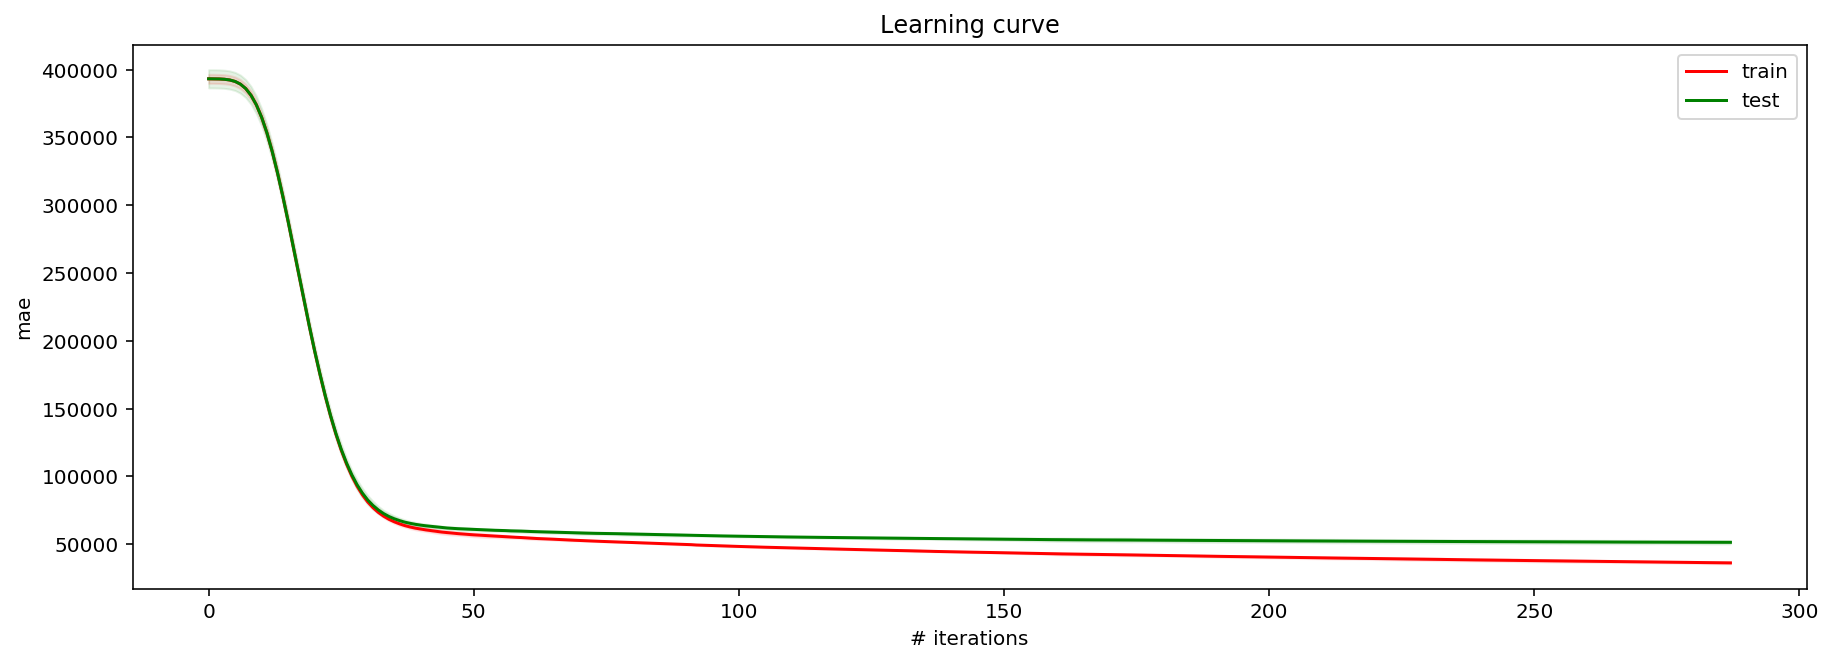

50906.57465997498 170.83090329610113


In [53]:
# best params - output from Hyperopt
best_params = {
    'colsample_bytree':0.7397423069534952,
    'learning_rate':0.13402766855890577,
    'max_depth':8,
    'min_child_weight':30.0,
    'reg_alpha':2.0976620810927638,
    'reg_lambda':0.8961634137263409,
    'seed':2018, #6250
    'subsample':0.871359852852428,
    'n_estimators': 500,
}

model, mae, mae_std = cv_xgb(dane_do_testu.loc[~dane_do_testu.price.isnull()],
       imp_features,
       best_params, 
       shift=0, 
       folds=3, 
       verbose=10, 
#        ylim=(20000,280000),
       plot_lc=True,
      return_model=True)
print(mae, mae_std)

### Zapis wynikow dla Kaggle

In [54]:
kaggle_test = dane_do_testu.loc[dane_do_testu.price.isnull()]
results = pd.DataFrame()
results['id'] = kaggle_test.id
X_kaggle = kaggle_test[ imp_features ].values
y_pred = model.predict(X_kaggle)
y_pred = np.exp(y_pred)
results['price'] = y_pred

In [57]:
results.to_csv('data.nosync/results2811_1.csv', index=False)

### Features importance check 

In [507]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel


X_eli_train, X_eli_test, y_eli_train, y_eli_test = train_test_split(
    dane_do_testu.loc[~dane_do_testu.price.isnull(), all_features].values,
    np.log(dane_do_testu.loc[~dane_do_testu.price.isnull(), 'price'].values), shuffle=True, random_state=0)

xgb_params = {
#     'objective': fair_obj,
    'n_estimators': 100,
    'max_depth': 7,
#     'learning_rate': 0.1,
    'random_state': 2018,
}

all_f_names = [str(f) for f in all_features]
model_eli = xgb.XGBRegressor(**xgb_params).fit(X_eli_train, y_eli_train)
perm = PermutationImportance(model_eli).fit(X_eli_test, y_eli_test)
eli5.show_weights(perm, feature_names=all_f_names, top=50)

### Hyperopt

In [288]:
xgb.XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

{'max_depth': 11, 'colsample_bytree': 0.8086085676305987, 'learning_rate': 0.09322748102301762, 'subsample': 0.7063005596496692, 'seed': 2018, 'min_child_weight': 20, 'reg_alpha': 1.424728988604039, 'reg_lambda': 0.8106998505823938, 'n_estimators': 100}


3it [00:57, 19.33s/it]


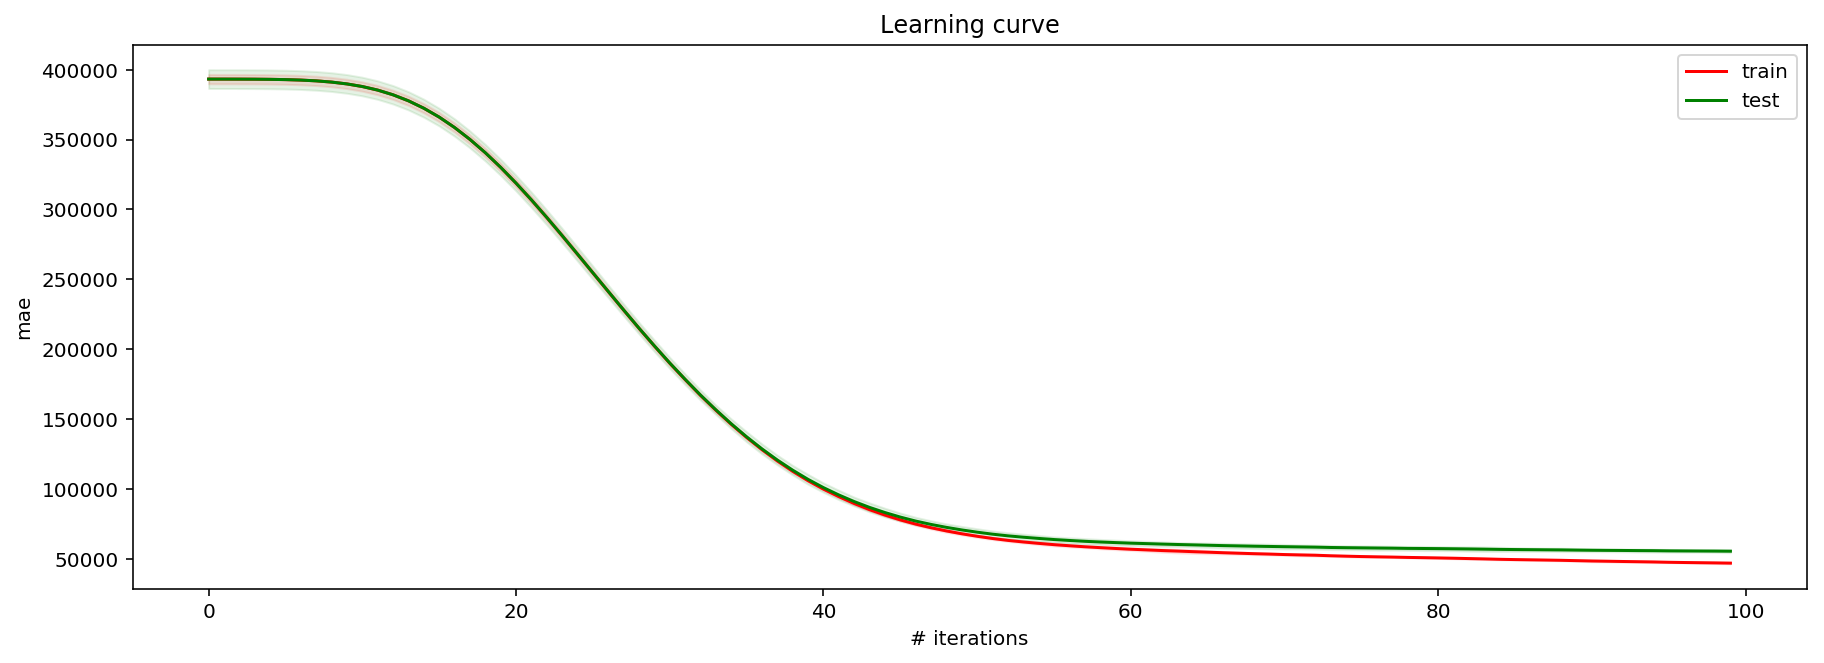

score: 55610.982368602185 352.4047372785548
{'max_depth': 10, 'colsample_bytree': 0.8683359722524593, 'learning_rate': 0.09237204124798434, 'subsample': 0.6768793871587264, 'seed': 2018, 'min_child_weight': 20, 'reg_alpha': 1.3735956627134527, 'reg_lambda': 0.7971120315901736, 'n_estimators': 100}


3it [00:56, 18.80s/it]


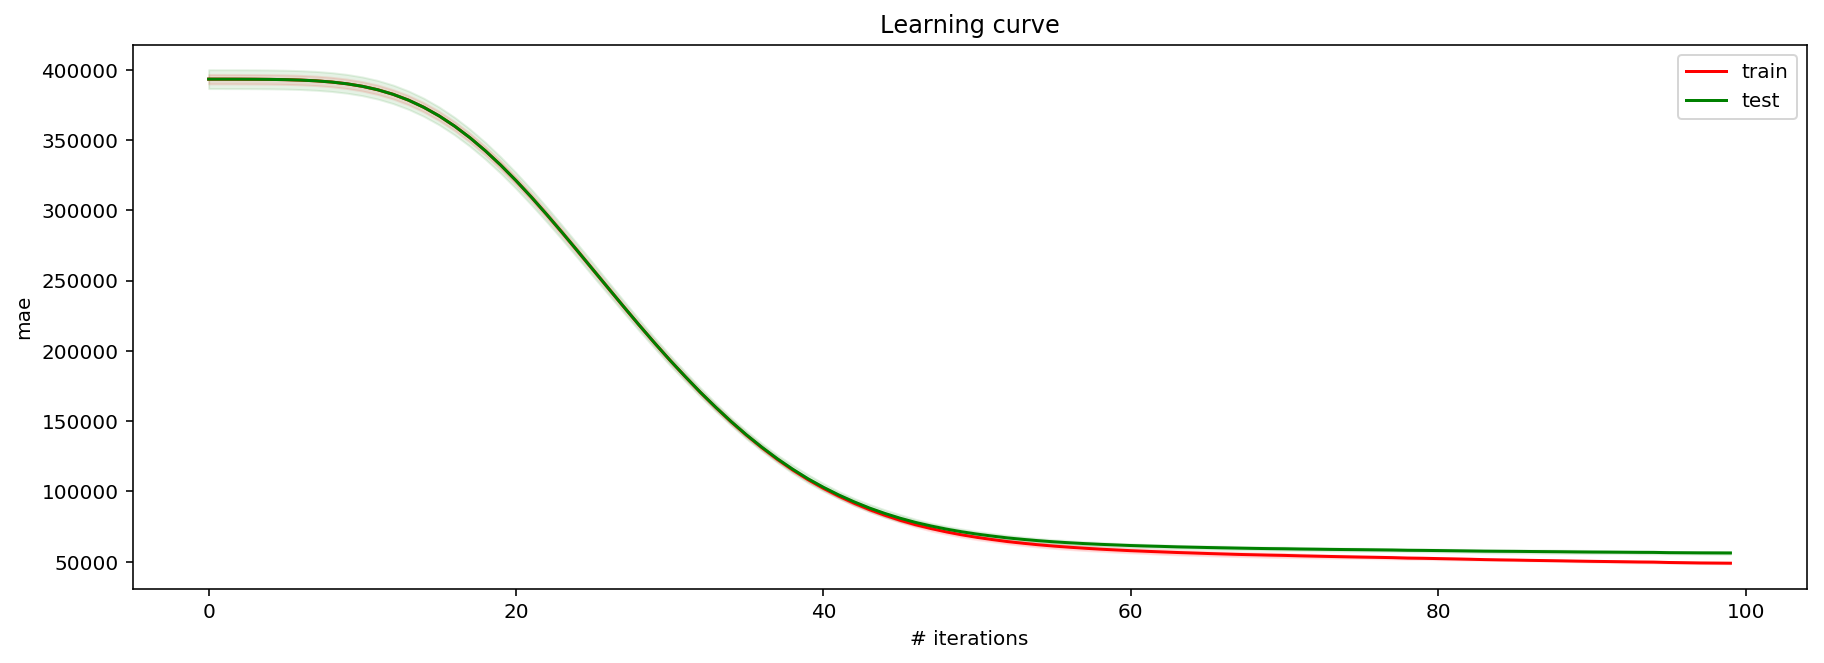

score: 56269.27380768609 313.3141510736201
{'max_depth': 19, 'colsample_bytree': 0.28283979607557586, 'learning_rate': 0.1867887631582606, 'subsample': 0.9701574711736438, 'seed': 2018, 'min_child_weight': 30, 'reg_alpha': 2.6400333640200504, 'reg_lambda': 0.9853861854078725, 'n_estimators': 100}


3it [00:39, 13.11s/it]


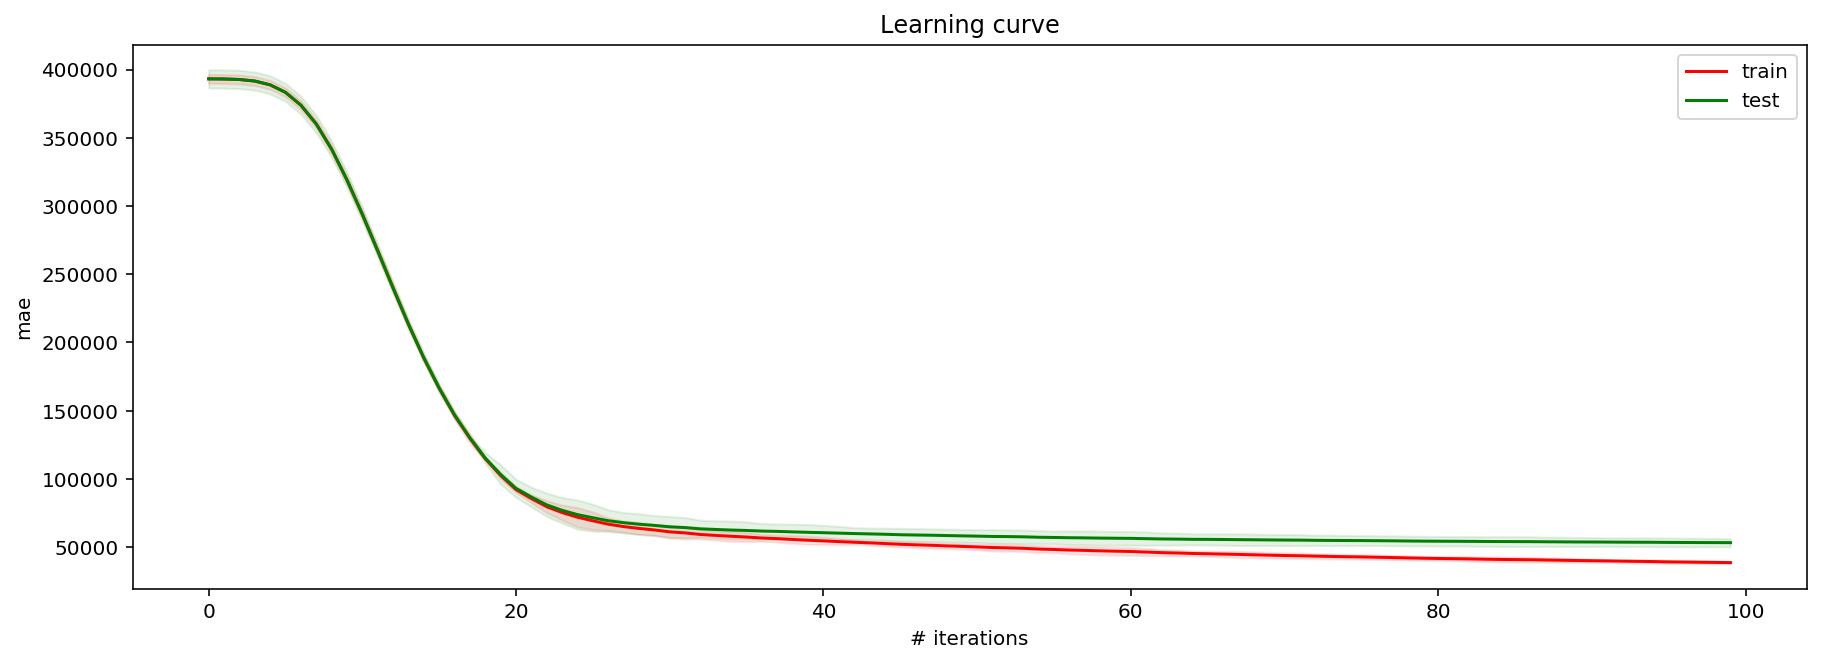

score: 53287.81955834907 1019.3768713301014
{'max_depth': 20, 'colsample_bytree': 0.20017403108287385, 'learning_rate': 0.1914304787091078, 'subsample': 0.997559340706731, 'seed': 2018, 'min_child_weight': 190, 'reg_alpha': 2.6179932948832243, 'reg_lambda': 0.9867461593240543, 'n_estimators': 100}


3it [00:25,  8.55s/it]


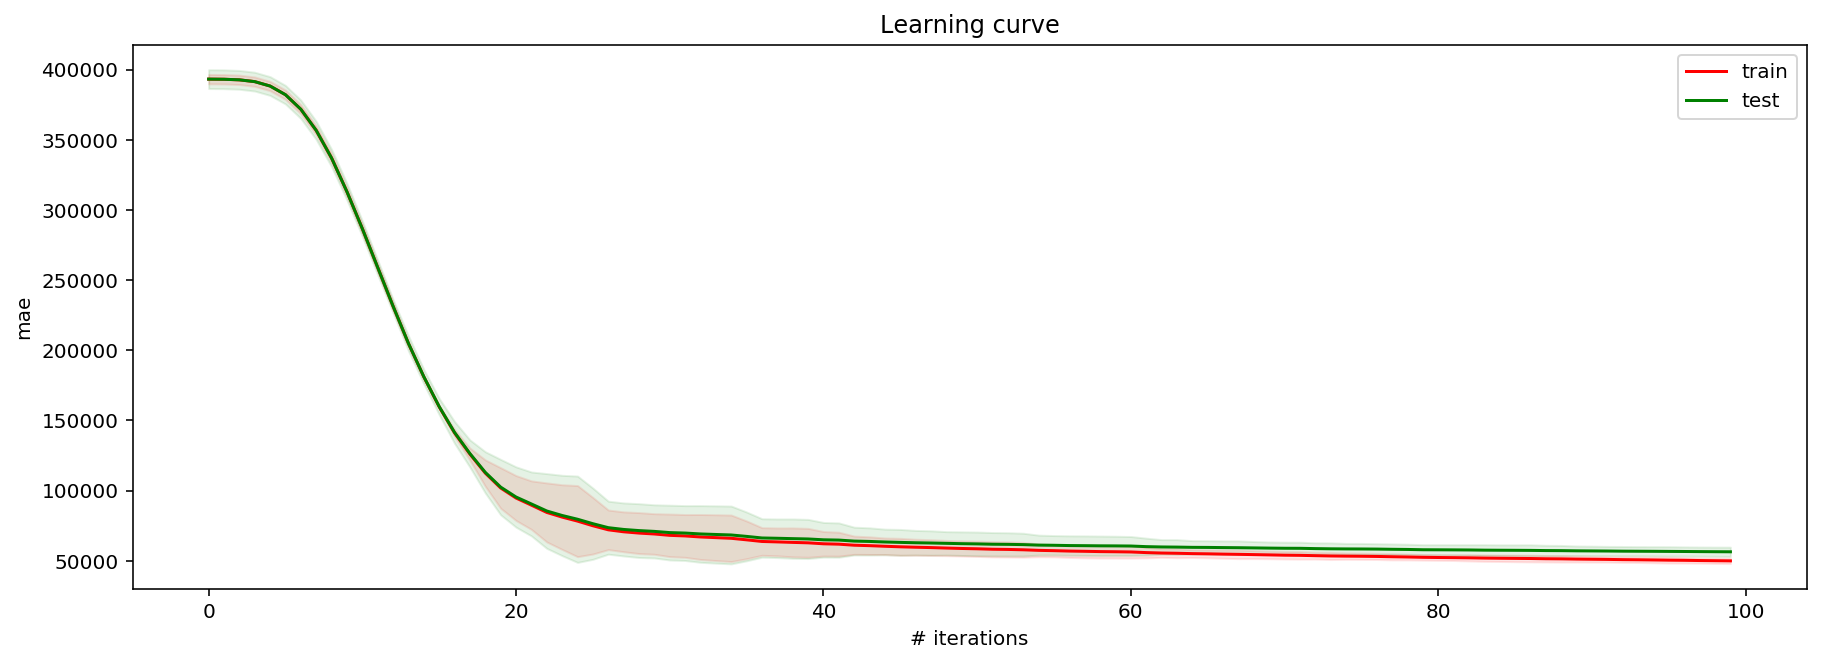

score: 56376.651918275165 1100.3870943000209
{'max_depth': 20, 'colsample_bytree': 0.22986967761034227, 'learning_rate': 0.19293946514144267, 'subsample': 0.9843919436474293, 'seed': 2018, 'min_child_weight': 120, 'reg_alpha': 2.642991202318451, 'reg_lambda': 0.9953941979537261, 'n_estimators': 100}


3it [00:29,  9.92s/it]


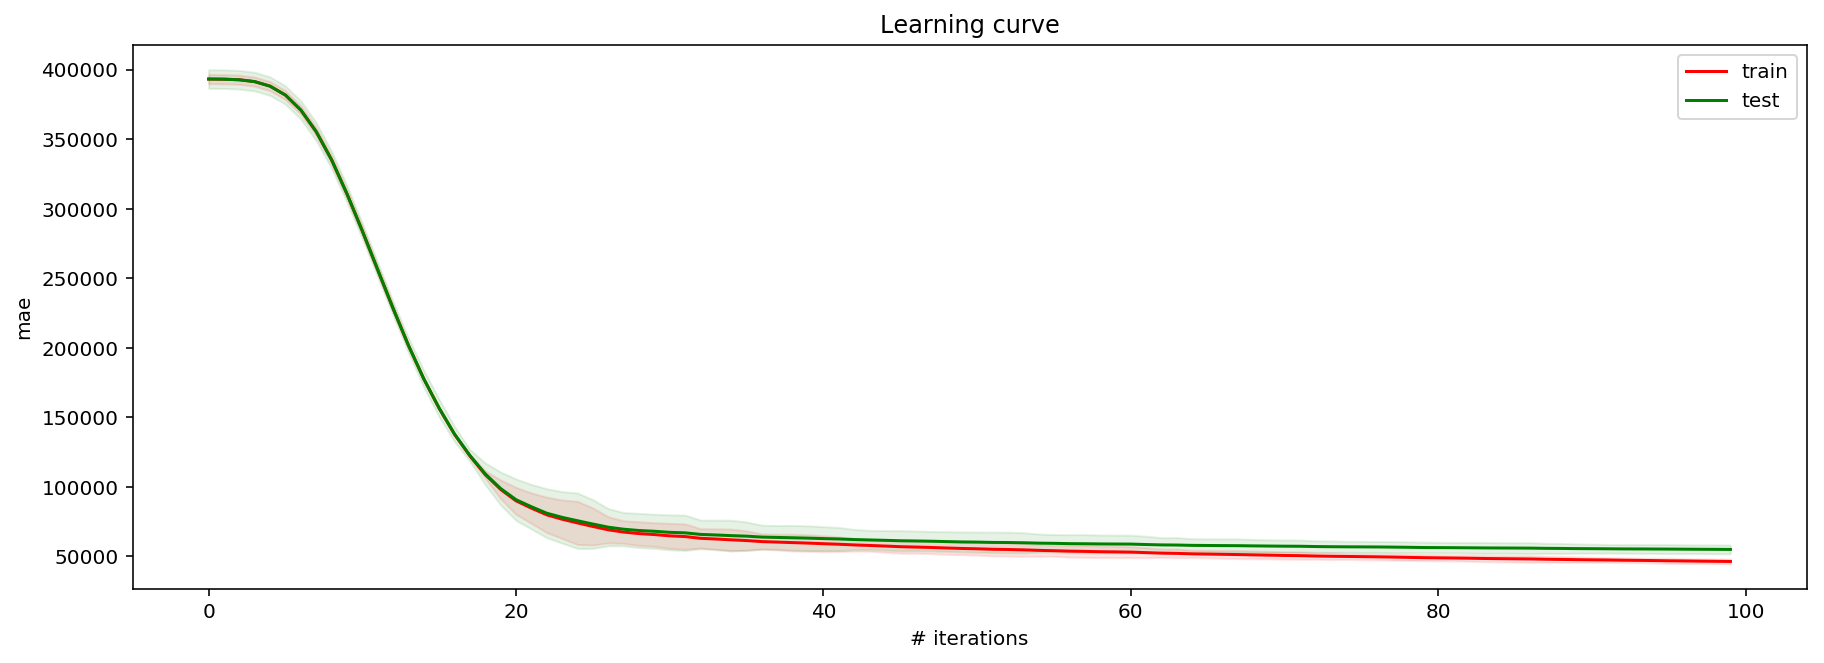

score: 54893.74681739367 1057.4151010774342
{'max_depth': 16, 'colsample_bytree': 0.4723369741087501, 'learning_rate': 0.14701597509063405, 'subsample': 0.8748845476227973, 'seed': 2018, 'min_child_weight': 90, 'reg_alpha': 2.019889428493163, 'reg_lambda': 0.9170103340154968, 'n_estimators': 100}


3it [00:47, 16.00s/it]


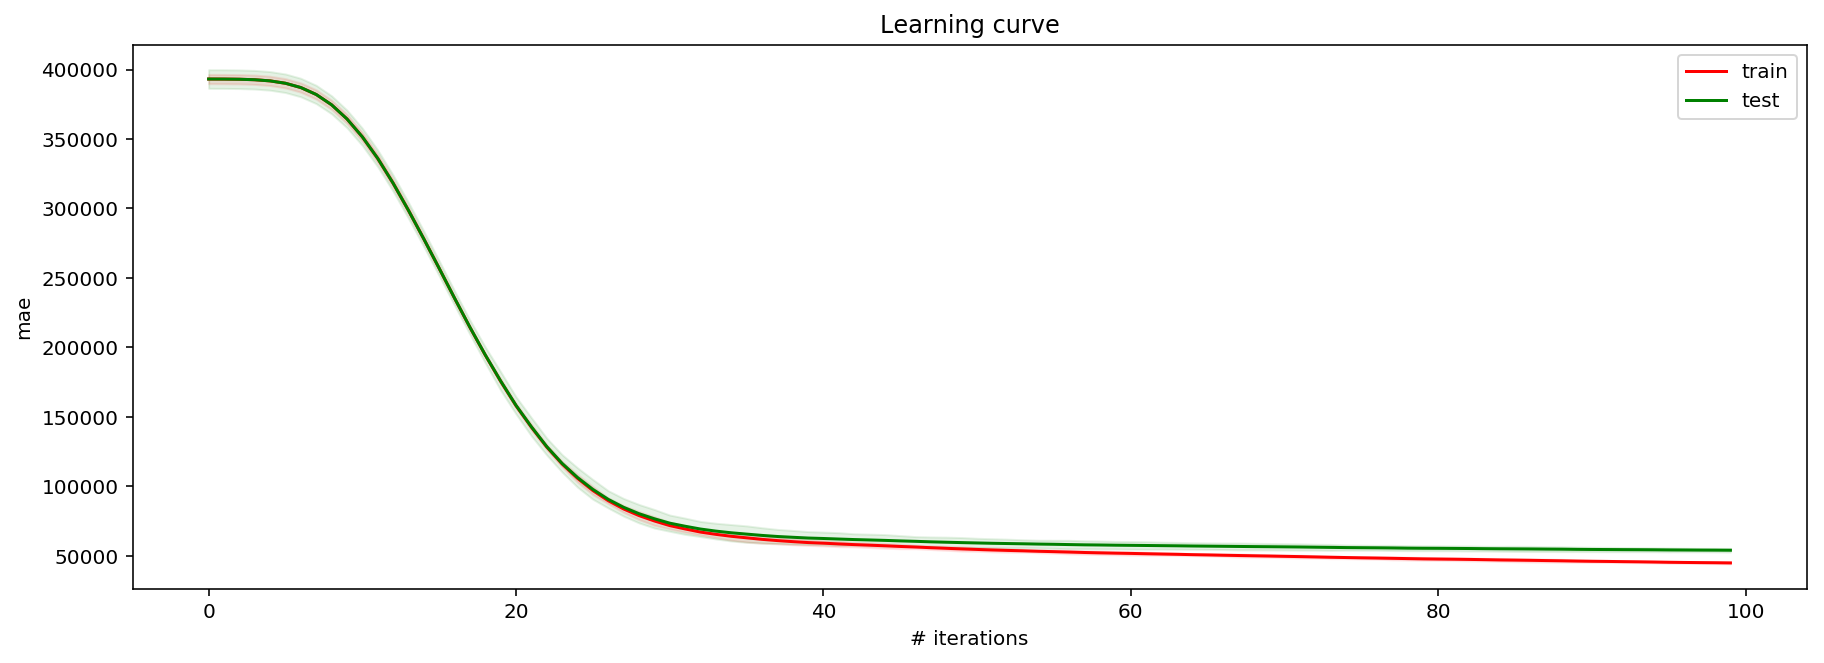

score: 53886.62399036303 433.0892669296547
{'max_depth': 5, 'colsample_bytree': 0.5154225109925971, 'learning_rate': 0.14838389878143488, 'subsample': 0.8465711134661724, 'seed': 2018, 'min_child_weight': 80, 'reg_alpha': 1.008578662855972, 'reg_lambda': 0.7069613952421291, 'n_estimators': 100}


3it [00:22,  7.39s/it]


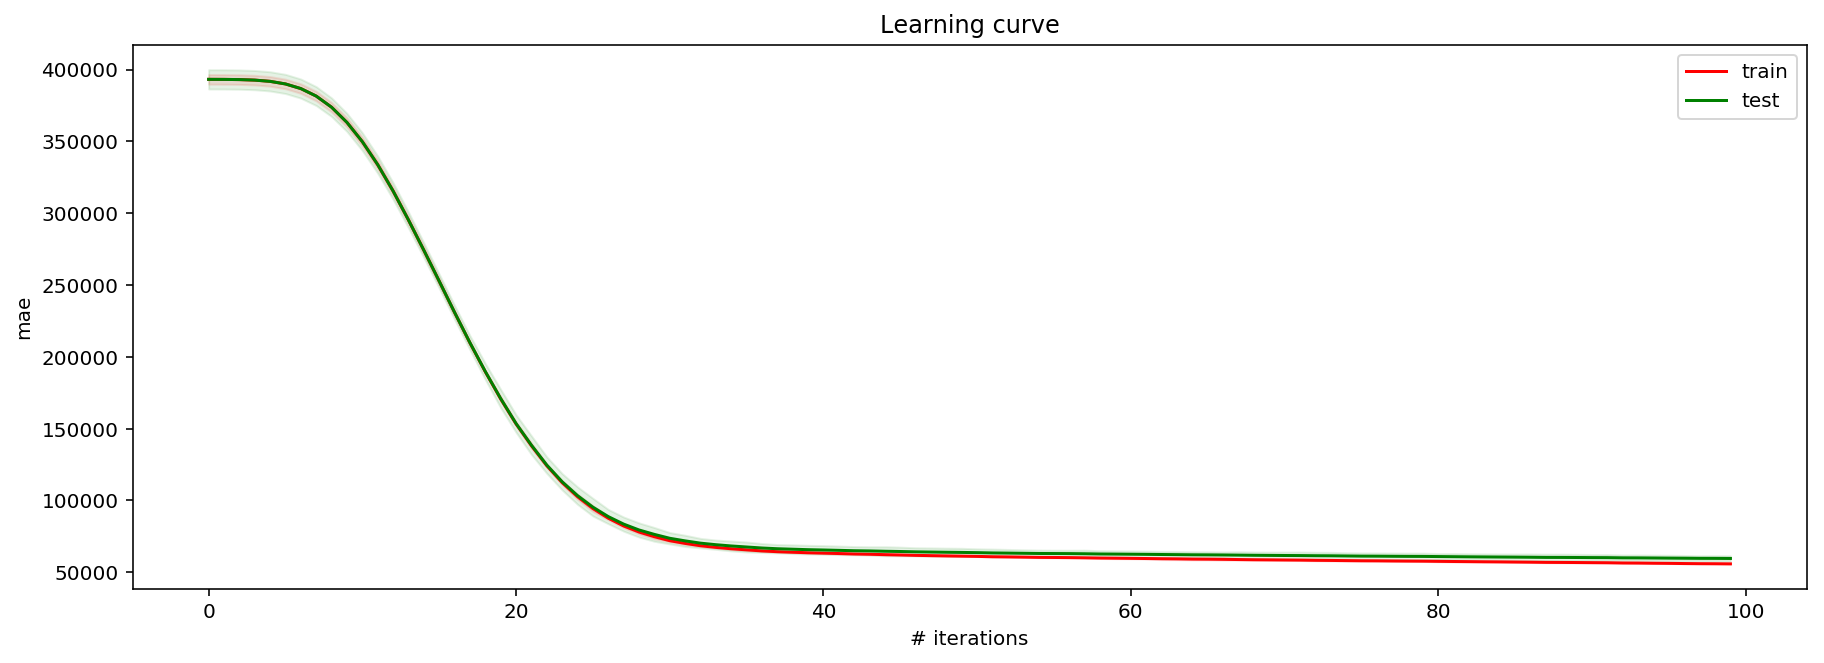

score: 59597.44169237803 609.4528056002341
{'max_depth': 16, 'colsample_bytree': 0.3329188263574403, 'learning_rate': 0.051353070941599605, 'subsample': 0.9286517374255703, 'seed': 2018, 'min_child_weight': 190, 'reg_alpha': 1.9117870988290848, 'reg_lambda': 0.9011566645496173, 'n_estimators': 100}


3it [00:23,  7.79s/it]


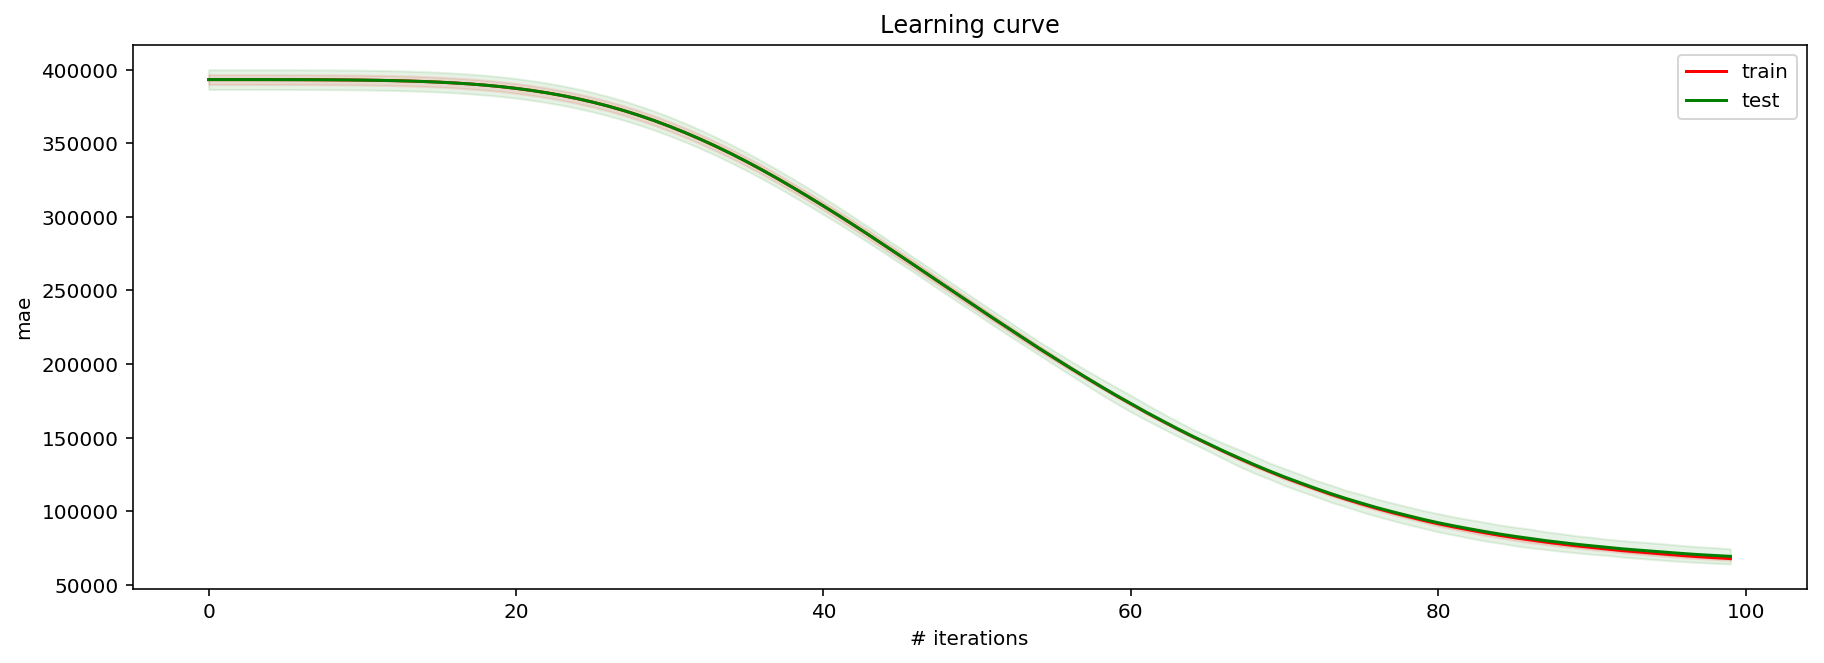

score: 69337.47046913562 1707.3513874209527
{'max_depth': 6, 'colsample_bytree': 0.6875486926910834, 'learning_rate': 0.19879412803455976, 'subsample': 0.762085073091745, 'seed': 2018, 'min_child_weight': 140, 'reg_alpha': 2.243991230077505, 'reg_lambda': 0.9282628866915741, 'n_estimators': 100}


3it [00:30, 10.30s/it]


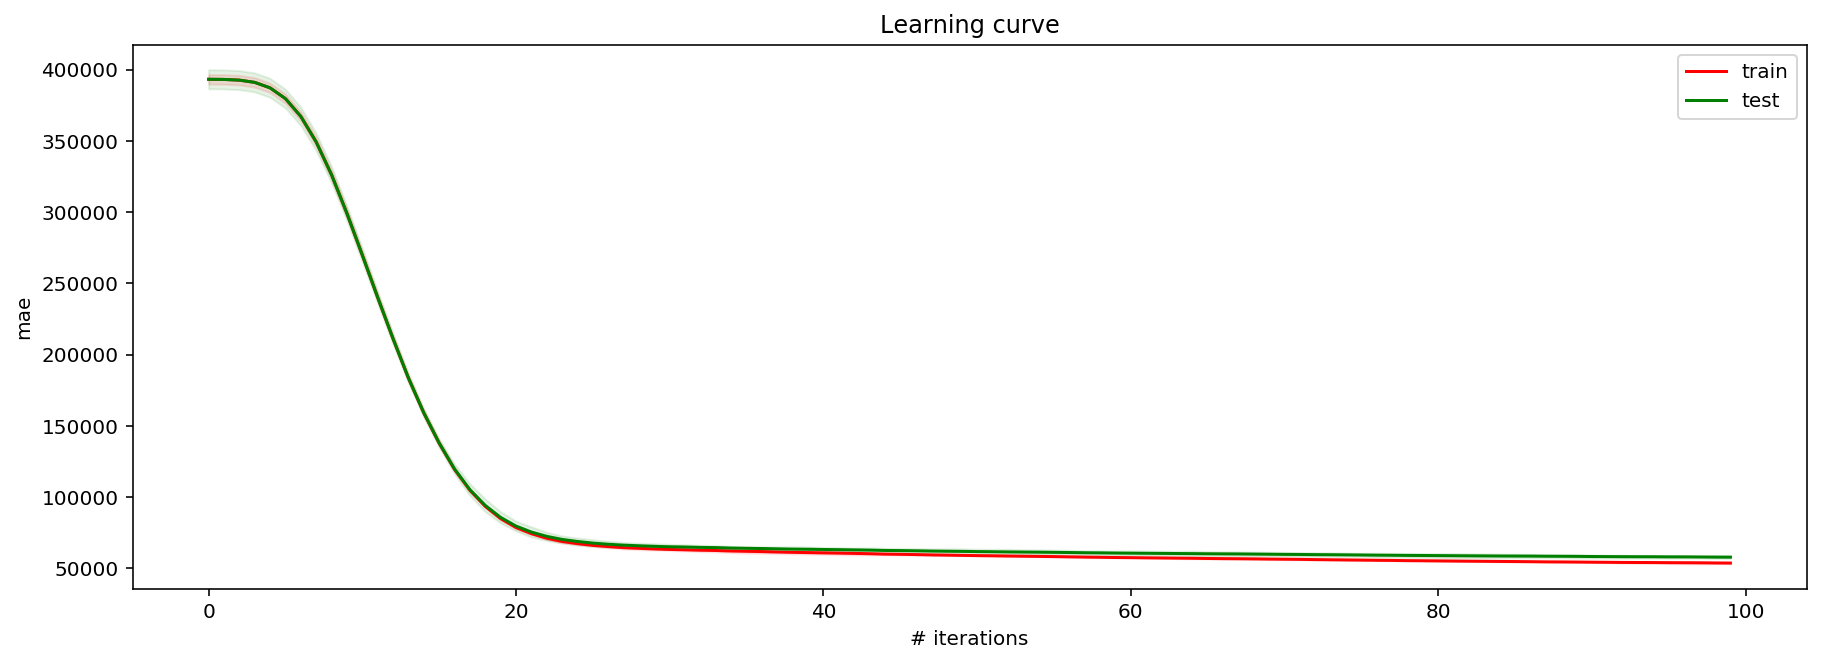

score: 57825.01775394267 321.12725996361
{'max_depth': 16, 'colsample_bytree': 0.9882058653056852, 'learning_rate': 0.16293383711086737, 'subsample': 0.6060100942010883, 'seed': 2018, 'min_child_weight': 50, 'reg_alpha': 1.053337300563792, 'reg_lambda': 0.7215300367114065, 'n_estimators': 100}


3it [01:34, 31.58s/it]


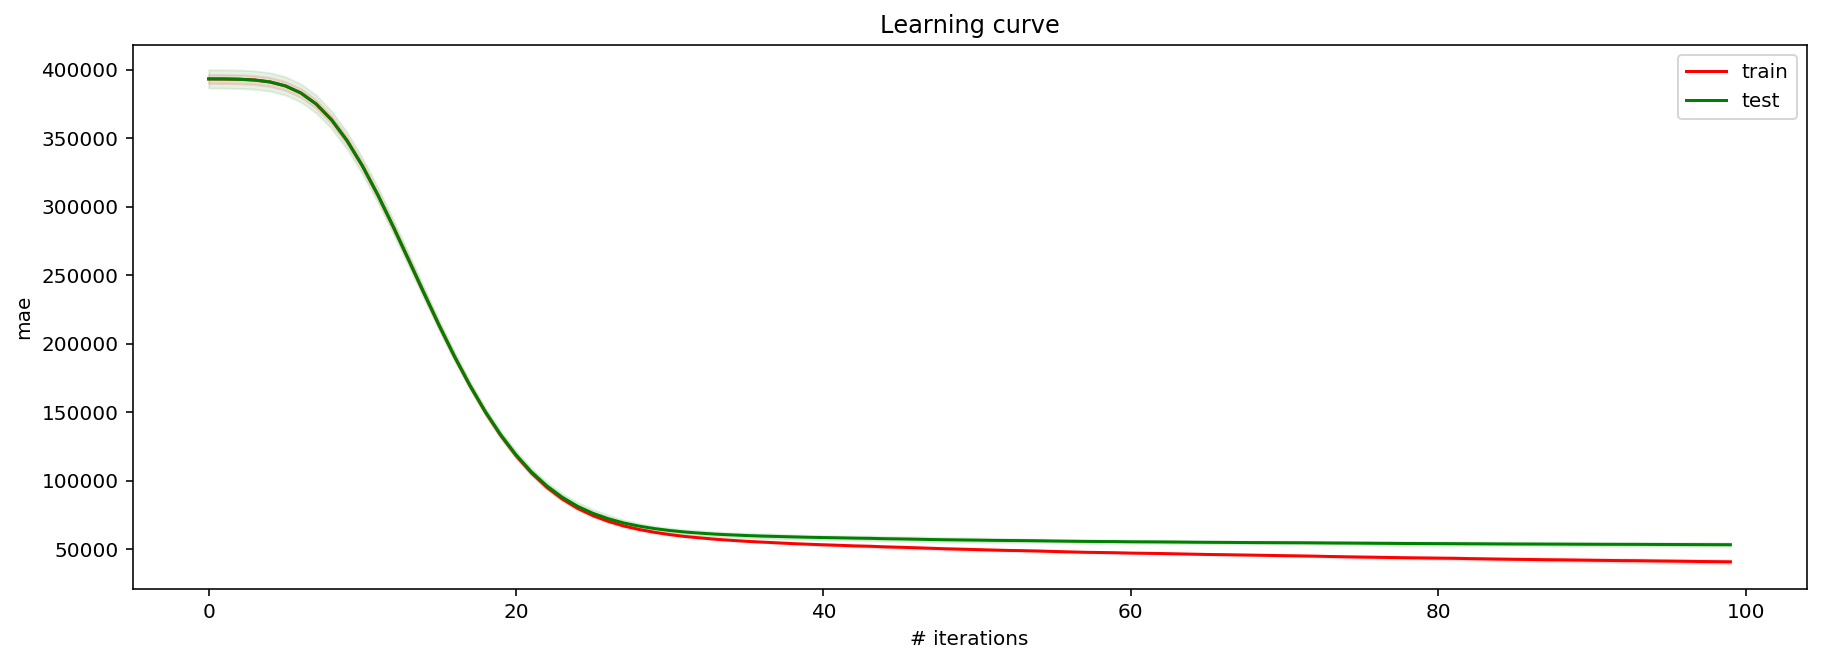

score: 53199.34630032236 456.69305670936694
{'max_depth': 14, 'colsample_bytree': 0.9758379202277189, 'learning_rate': 0.15820976147602722, 'subsample': 0.6090016064191035, 'seed': 2018, 'min_child_weight': 60, 'reg_alpha': 1.0010409779893303, 'reg_lambda': 0.7093835532905678, 'n_estimators': 100}


3it [01:23, 27.82s/it]


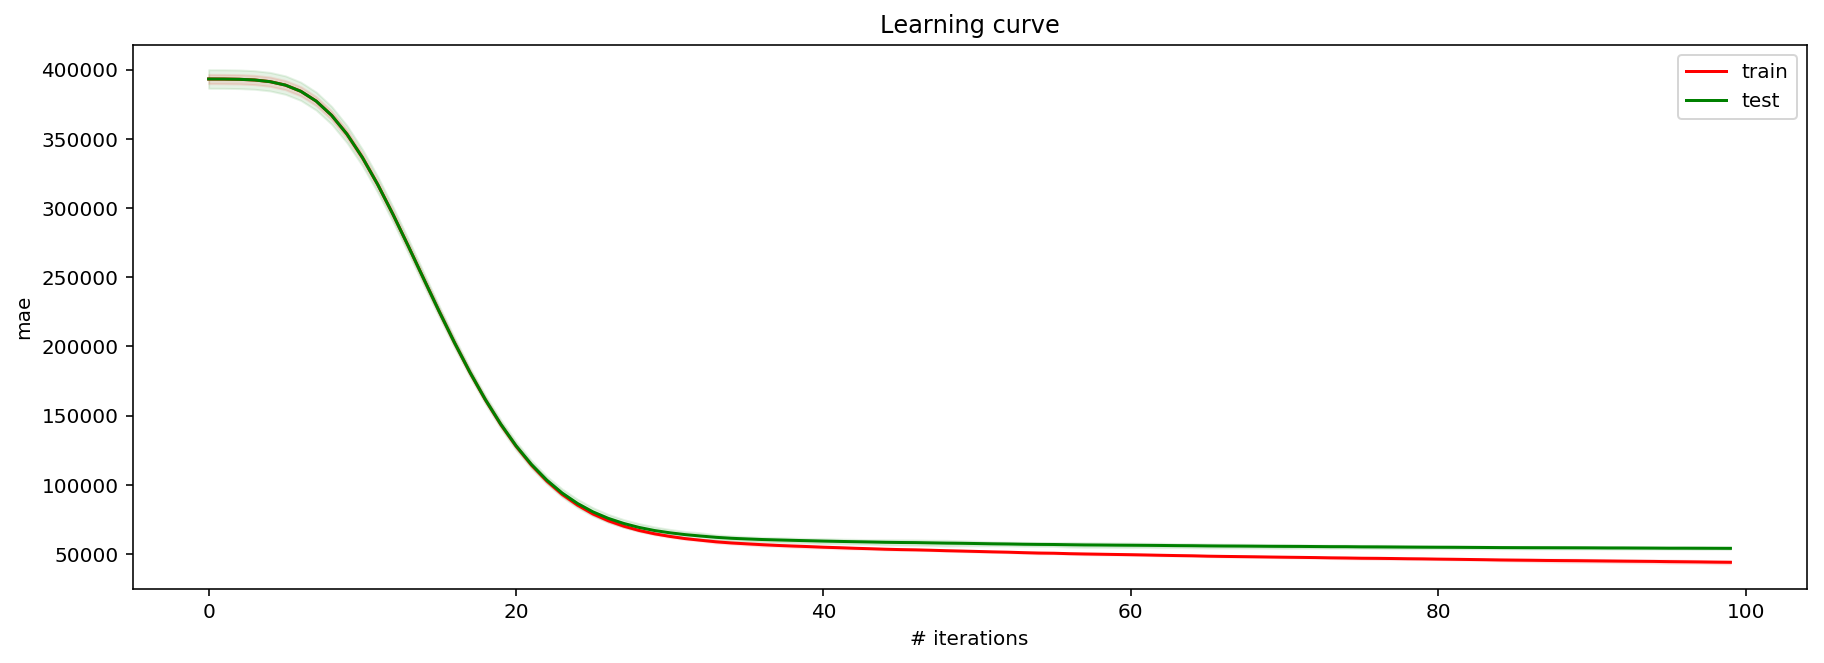

score: 54023.96425590576 258.0414148007606
{'max_depth': 9, 'colsample_bytree': 0.6779015443105727, 'learning_rate': 0.1006774284639663, 'subsample': 0.6068417546614493, 'seed': 2018, 'min_child_weight': 150, 'reg_alpha': 1.1444488301594706, 'reg_lambda': 0.7472729543674191, 'n_estimators': 100}


3it [00:40, 13.49s/it]


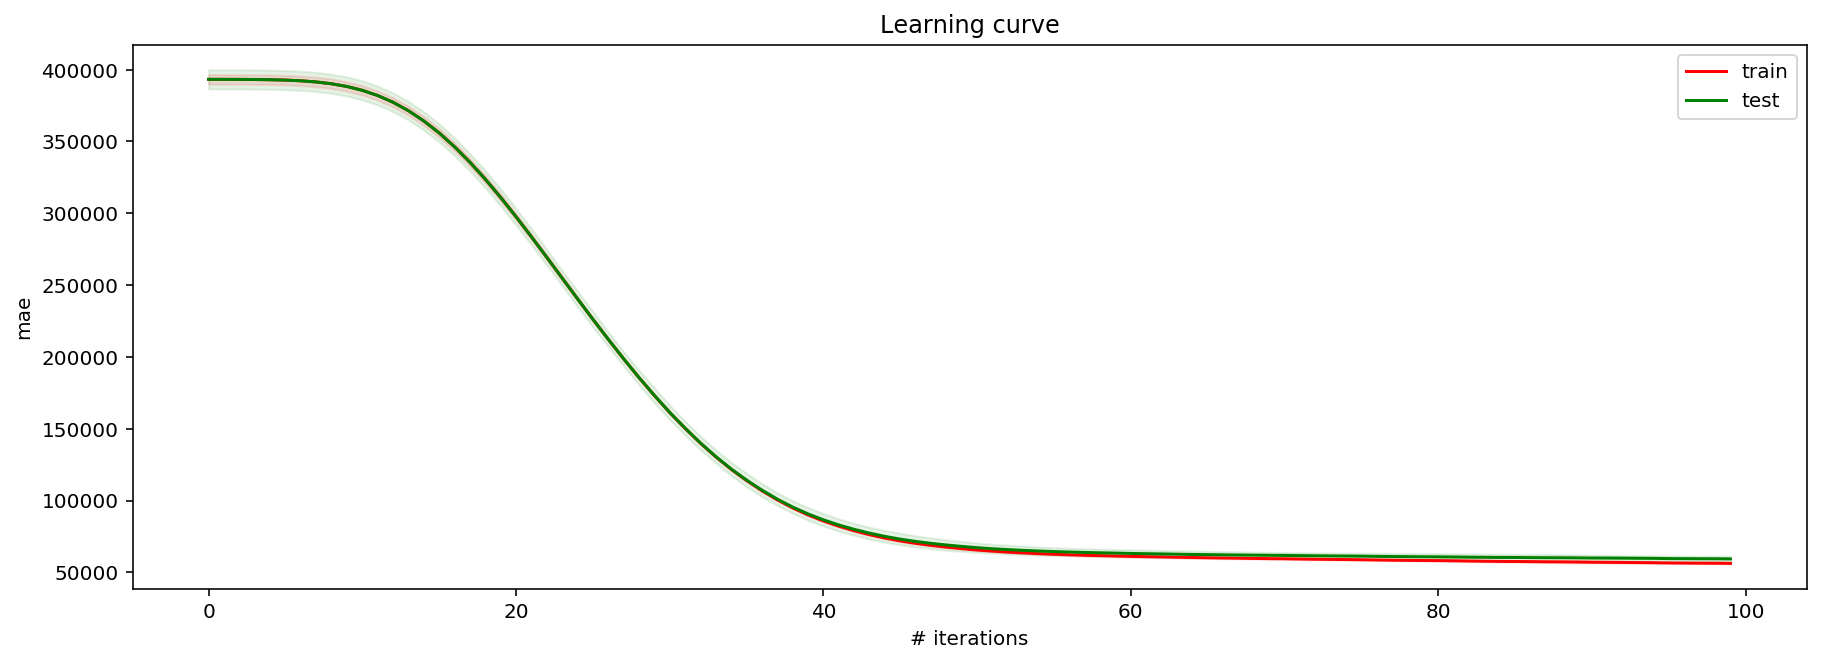

score: 59369.30679375201 595.8024470428287
{'max_depth': 17, 'colsample_bytree': 0.97572895339929, 'learning_rate': 0.054783531859142115, 'subsample': 0.6625201545500861, 'seed': 2018, 'min_child_weight': 50, 'reg_alpha': 1.2761961731027793, 'reg_lambda': 0.7665023849746141, 'n_estimators': 100}


3it [01:07, 22.59s/it]


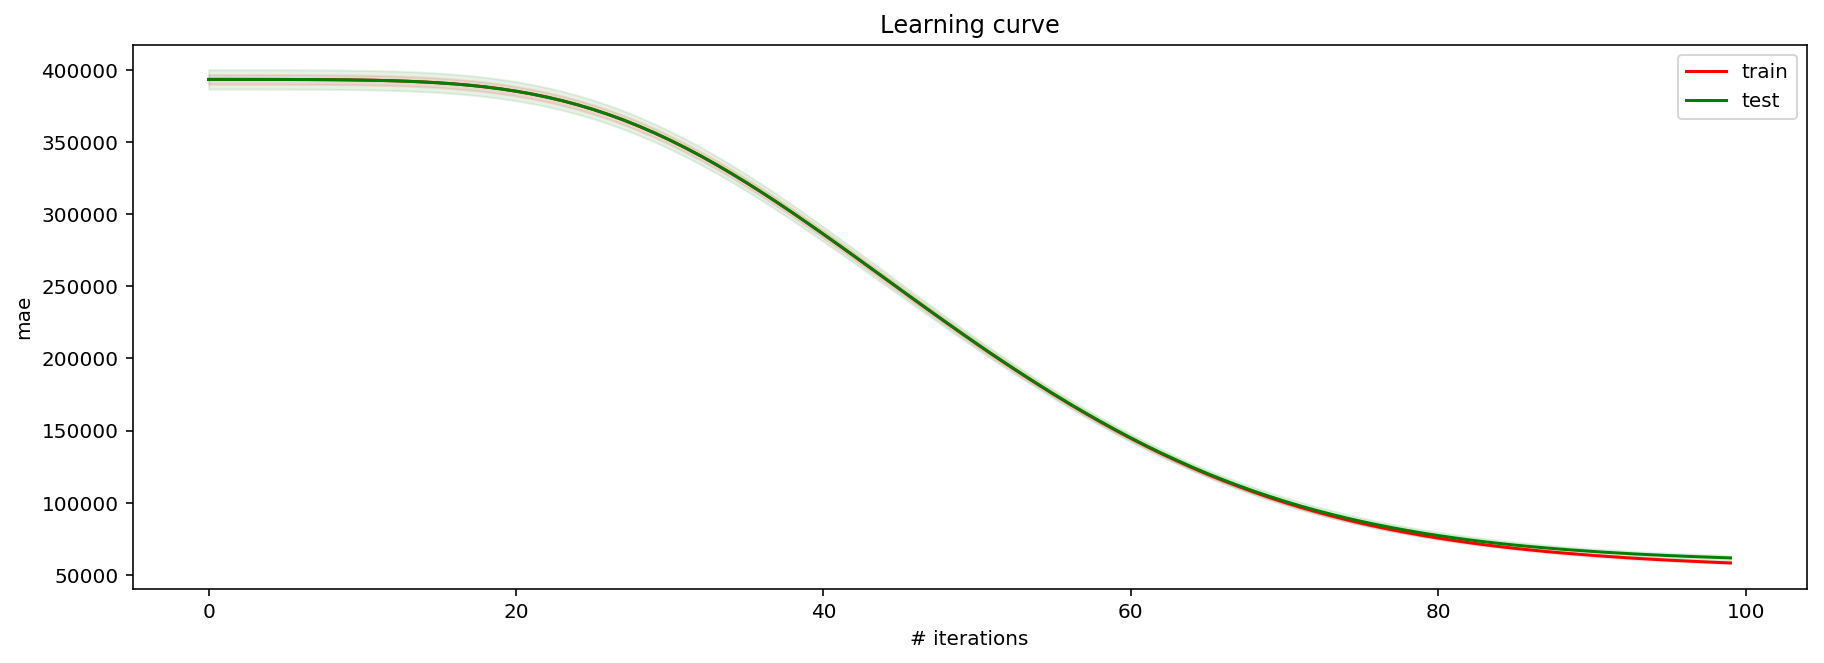

score: 61778.87286387759 584.0690860462578
{'max_depth': 13, 'colsample_bytree': 0.8395958657935754, 'learning_rate': 0.12382291977703383, 'subsample': 0.7733615161154552, 'seed': 2018, 'min_child_weight': 120, 'reg_alpha': 1.6402500031914116, 'reg_lambda': 0.8615260380662575, 'n_estimators': 100}


3it [01:03, 21.32s/it]


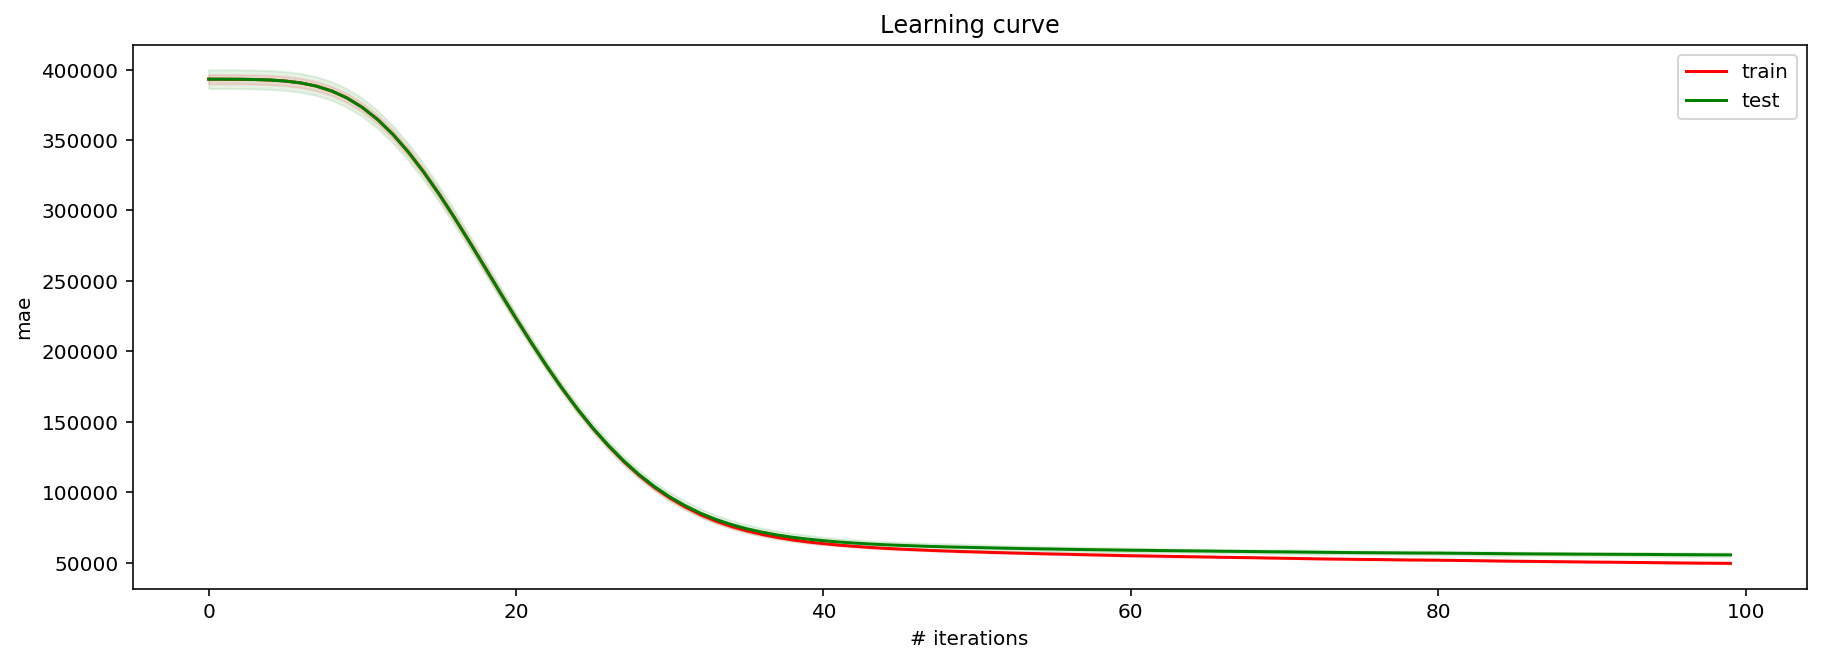

score: 55575.26357055514 473.62268850472077
{'max_depth': 7, 'colsample_bytree': 0.9926392499949109, 'learning_rate': 0.1689325013061585, 'subsample': 0.7269005245229103, 'seed': 2018, 'min_child_weight': 160, 'reg_alpha': 1.145077882874806, 'reg_lambda': 0.8456084324311899, 'n_estimators': 100}


3it [00:46, 15.64s/it]


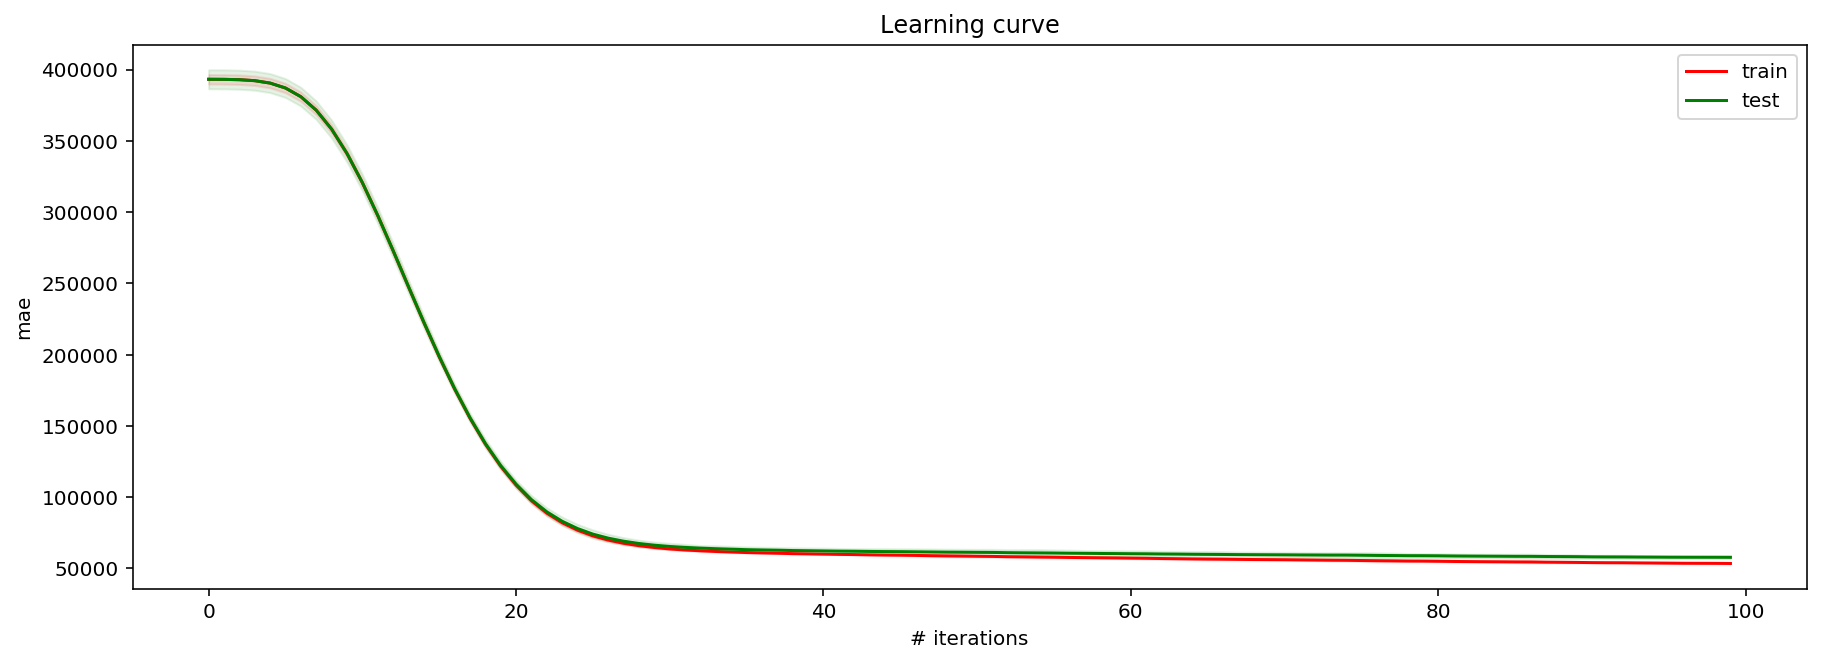

score: 57844.08387445262 311.0966983313945
{'max_depth': 18, 'colsample_bytree': 0.4443631933063449, 'learning_rate': 0.12330706085267135, 'subsample': 0.8204487528057278, 'seed': 2018, 'min_child_weight': 50, 'reg_alpha': 1.5706187158773652, 'reg_lambda': 0.7304427223917316, 'n_estimators': 100}


3it [00:48, 16.21s/it]


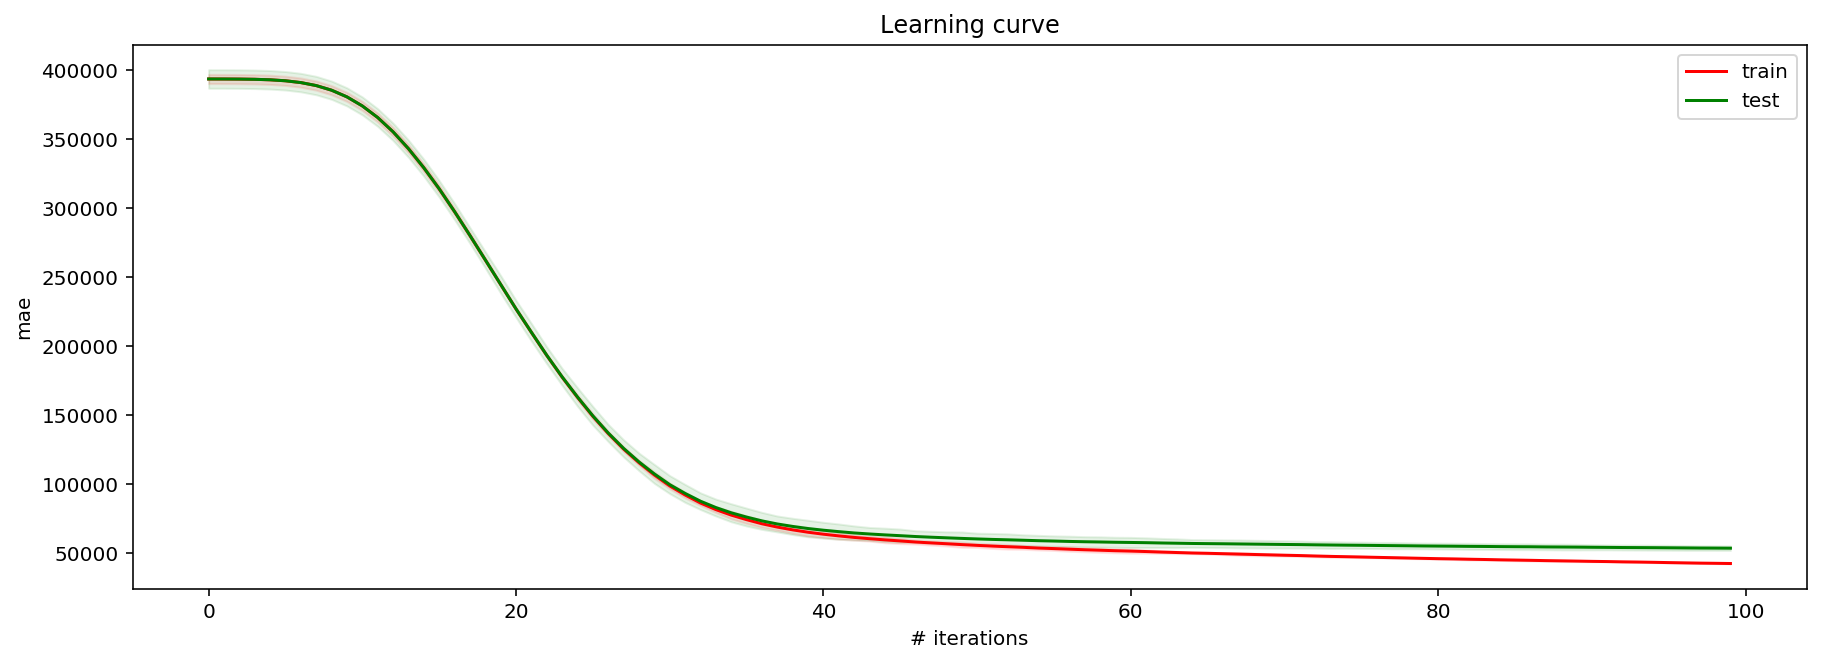

score: 53568.16409071492 542.9980134513204
{'max_depth': 14, 'colsample_bytree': 0.6884312094087663, 'learning_rate': 0.07787155593747414, 'subsample': 0.6400006448154497, 'seed': 2018, 'min_child_weight': 80, 'reg_alpha': 1.1252351993975718, 'reg_lambda': 0.7788236783296754, 'n_estimators': 100}


3it [00:52, 17.60s/it]


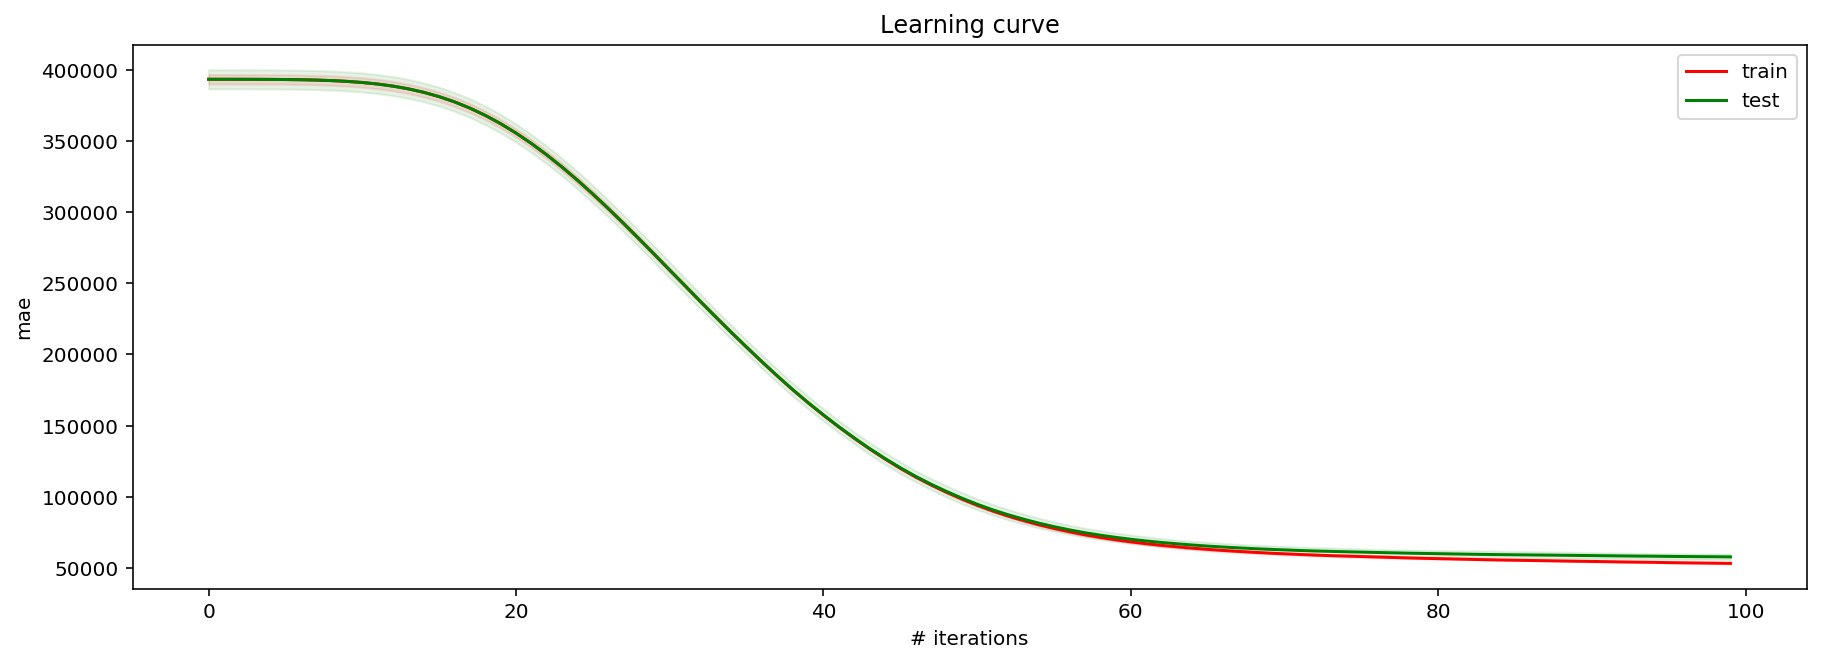

score: 57907.623086546875 667.8190092266491
{'max_depth': 18, 'colsample_bytree': 0.3413803213069759, 'learning_rate': 0.1764820404772775, 'subsample': 0.9234871447773058, 'seed': 2018, 'min_child_weight': 10, 'reg_alpha': 2.3444680485082836, 'reg_lambda': 0.9477160252167588, 'n_estimators': 100}


3it [00:44, 14.93s/it]


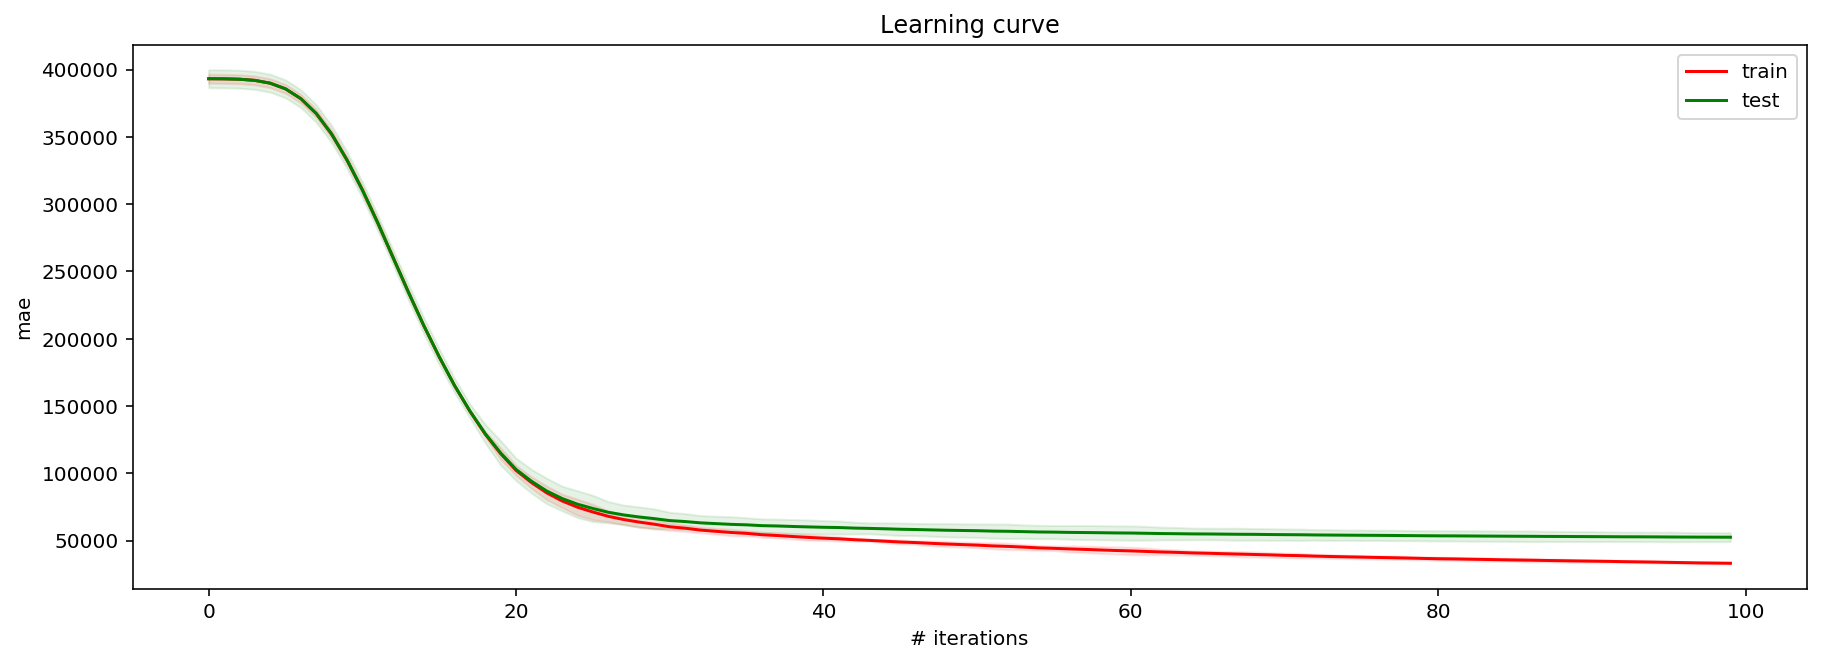

score: 52482.4408158324 1096.5005076460773
{'max_depth': 15, 'colsample_bytree': 0.37416950768417, 'learning_rate': 0.17321125802212706, 'subsample': 0.9078165962294696, 'seed': 2018, 'min_child_weight': 40, 'reg_alpha': 2.2645634579066414, 'reg_lambda': 0.9521306224587984, 'n_estimators': 100}


3it [00:40, 13.40s/it]


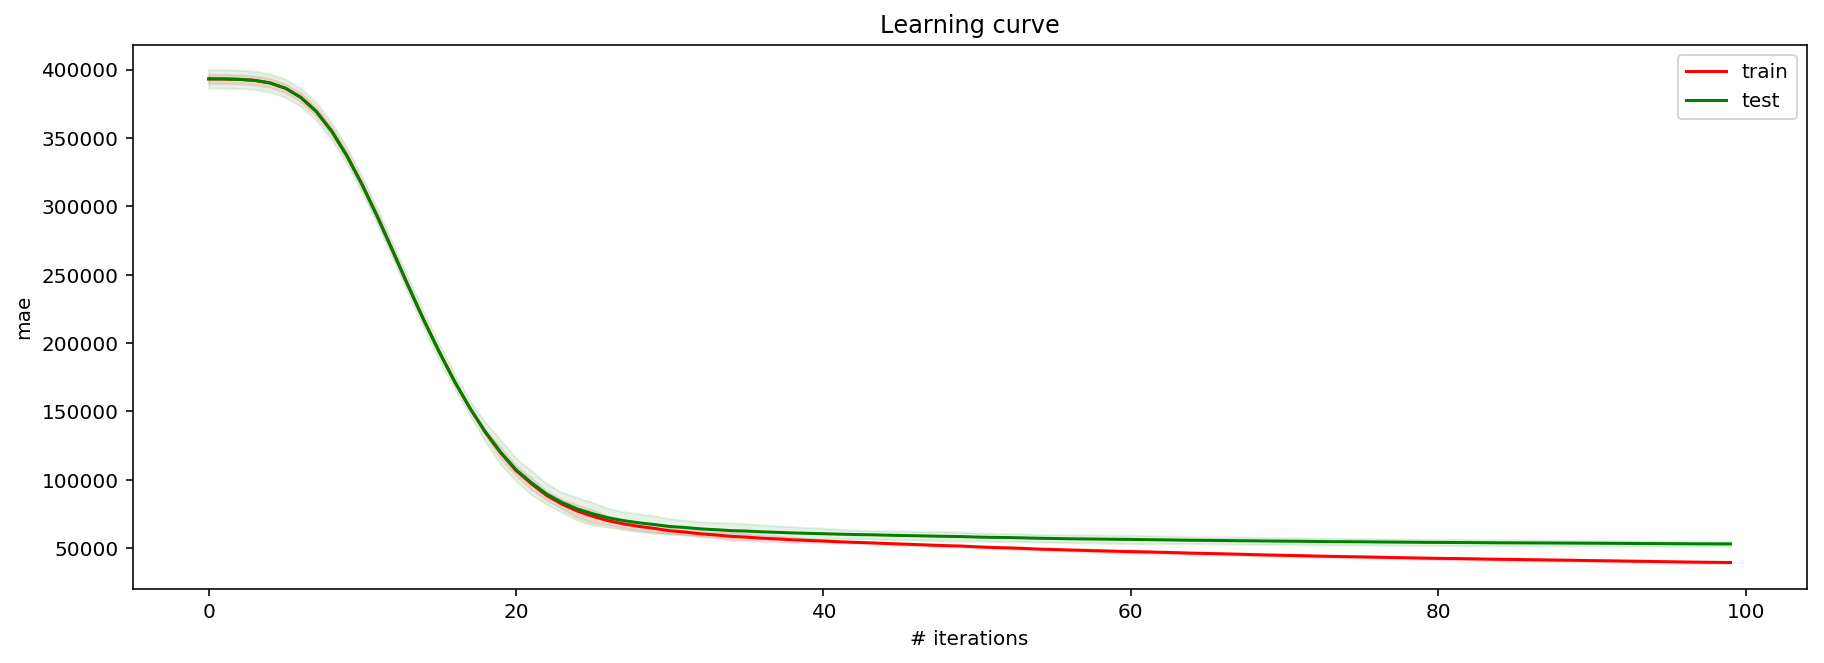

score: 52985.623643069244 576.557840304931
{'max_depth': 18, 'colsample_bytree': 0.3751483467130768, 'learning_rate': 0.17666641658623713, 'subsample': 0.9114609092409098, 'seed': 2018, 'min_child_weight': 10, 'reg_alpha': 2.3096808627701404, 'reg_lambda': 0.9523801629902192, 'n_estimators': 100}


3it [00:49, 16.51s/it]


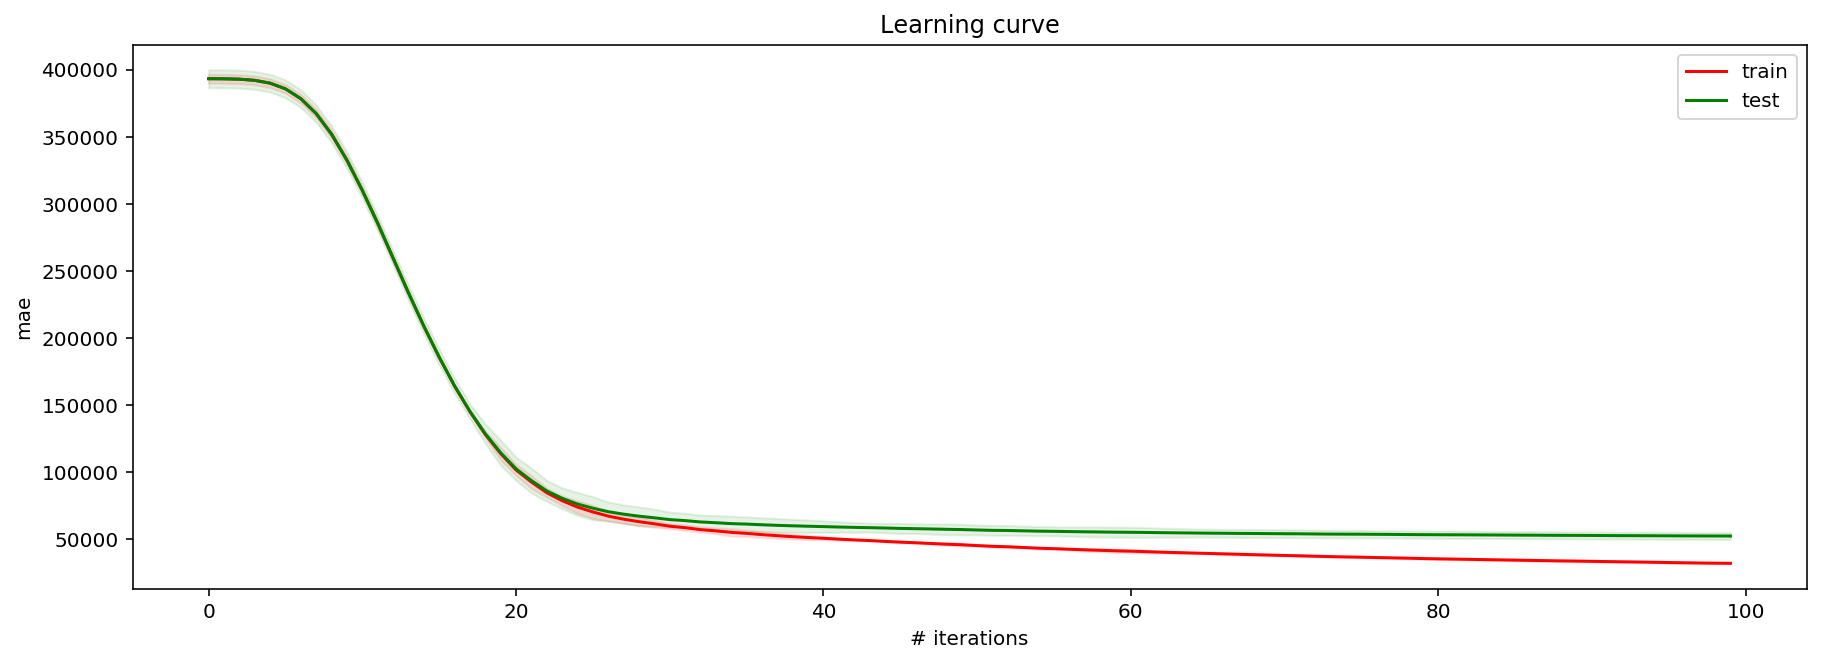

score: 52285.670825545785 863.2262780348191
{'max_depth': 18, 'colsample_bytree': 0.5894457550131933, 'learning_rate': 0.1367106895211603, 'subsample': 0.9389989004160673, 'seed': 2018, 'min_child_weight': 10, 'reg_alpha': 2.301753393939055, 'reg_lambda': 0.8755696060173087, 'n_estimators': 100}


3it [01:07, 22.51s/it]


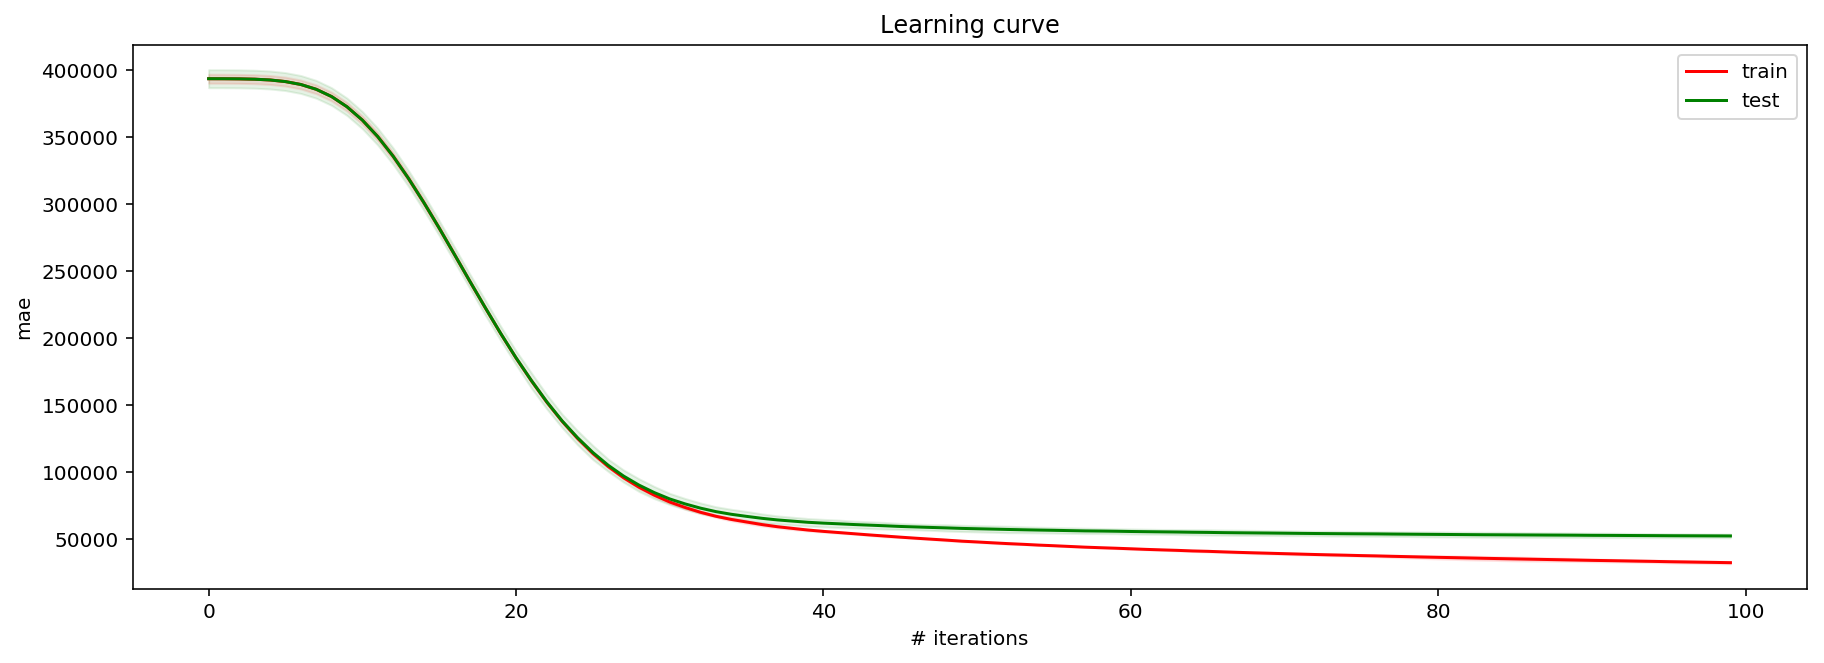

score: 52201.306819342666 472.53935944757563
{'max_depth': 19, 'colsample_bytree': 0.5795616386315301, 'learning_rate': 0.13720524487498395, 'subsample': 0.9561032116929525, 'seed': 2018, 'min_child_weight': 10, 'reg_alpha': 1.876207266050361, 'reg_lambda': 0.8795183250965093, 'n_estimators': 100}


3it [01:10, 23.48s/it]


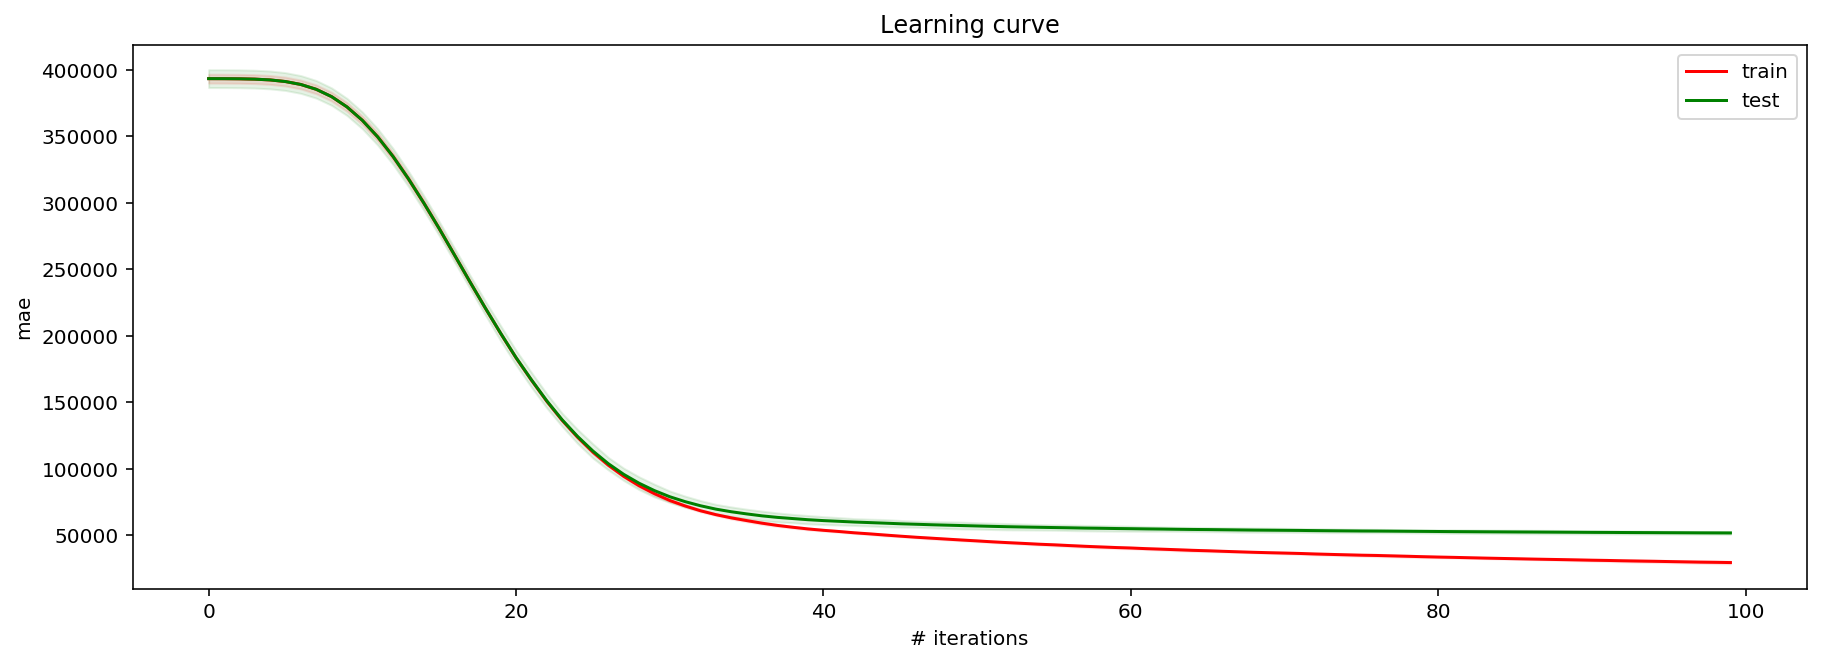

score: 51823.53317761761 362.8598611817003
{'max_depth': 19, 'colsample_bytree': 0.5813285807695111, 'learning_rate': 0.13936272071334874, 'subsample': 0.9596972357300259, 'seed': 2018, 'min_child_weight': 30, 'reg_alpha': 1.8079552270679973, 'reg_lambda': 0.8752821307013303, 'n_estimators': 100}


3it [01:05, 21.85s/it]


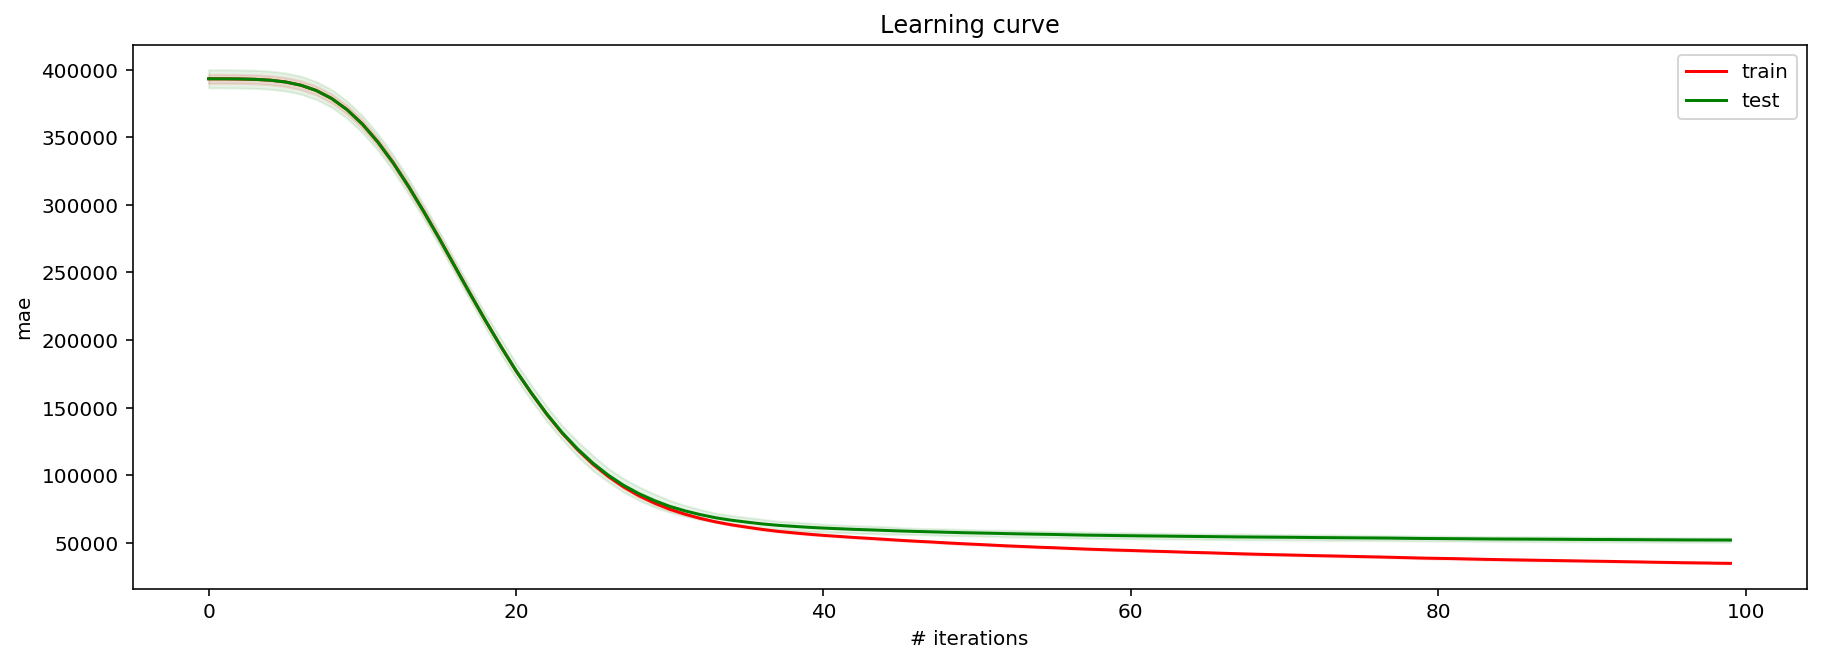

score: 52080.111464340625 538.711776030221
{'max_depth': 19, 'colsample_bytree': 0.6177309395698738, 'learning_rate': 0.11505925496778707, 'subsample': 0.8808900983247356, 'seed': 2018, 'min_child_weight': 70, 'reg_alpha': 1.8320068023944502, 'reg_lambda': 0.8364765421537864, 'n_estimators': 100}


3it [01:03, 21.05s/it]


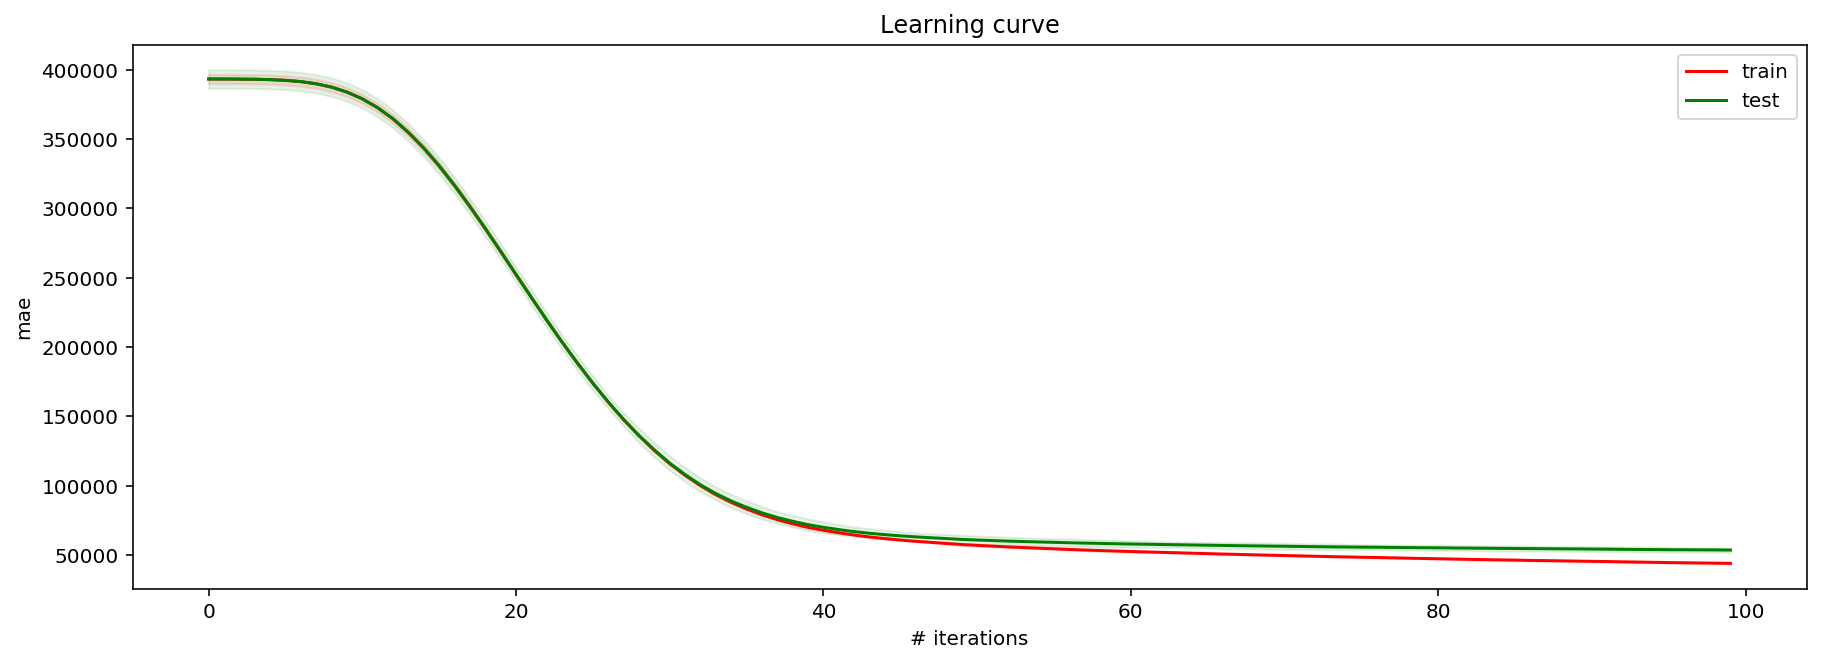

score: 53731.32921620072 528.0886520714498
{'max_depth': 12, 'colsample_bytree': 0.5442173096693887, 'learning_rate': 0.14116636366159532, 'subsample': 0.9606312042290783, 'seed': 2018, 'min_child_weight': 100, 'reg_alpha': 1.7685873412280533, 'reg_lambda': 0.8823970702899445, 'n_estimators': 100}


3it [00:42, 14.15s/it]


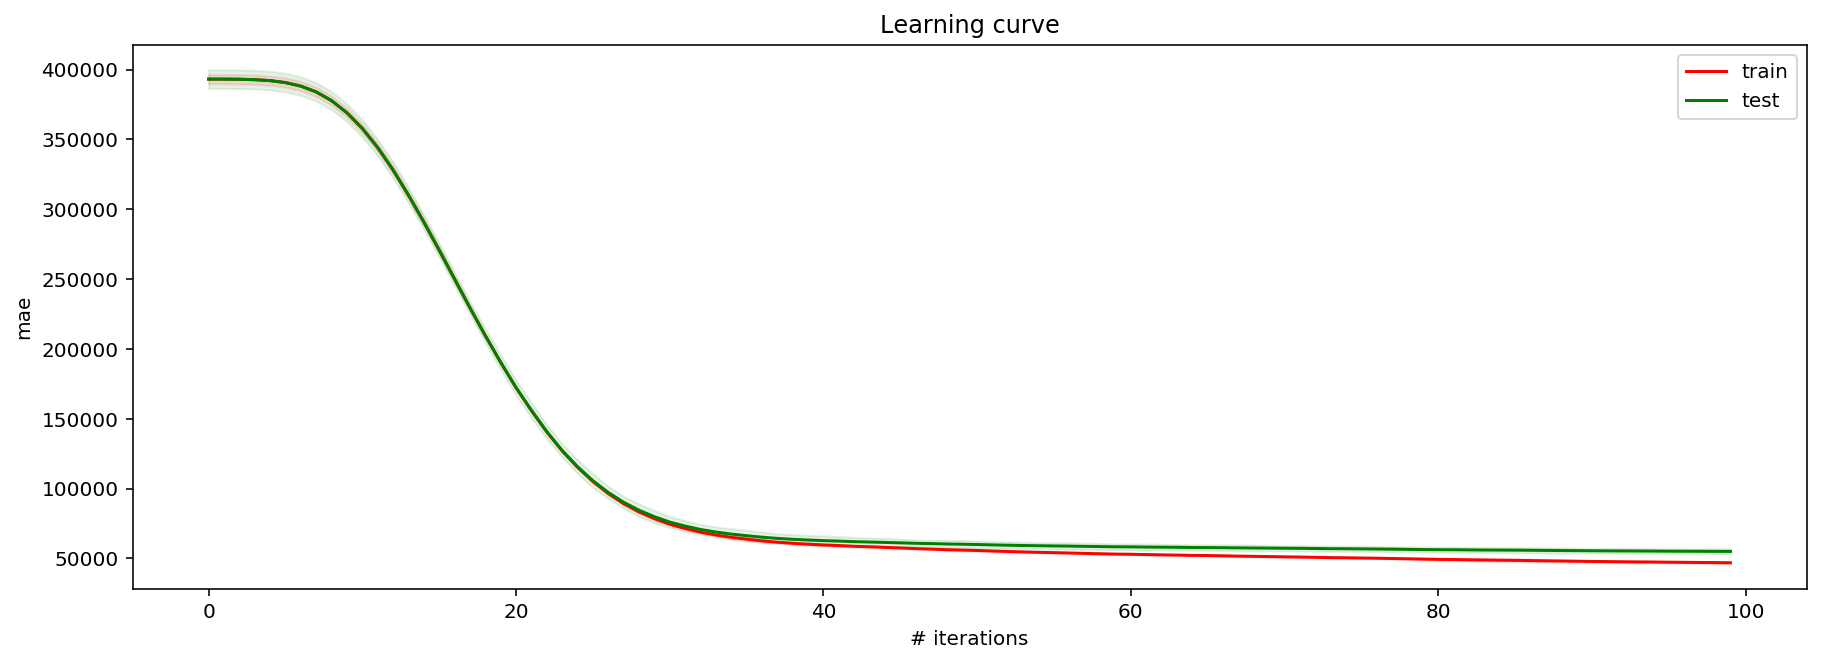

score: 55025.45951443226 620.0739336850388
{'max_depth': 20, 'colsample_bytree': 0.7864227349344581, 'learning_rate': 0.11291764378354287, 'subsample': 0.9969759958856794, 'seed': 2018, 'min_child_weight': 30, 'reg_alpha': 1.5400696507941358, 'reg_lambda': 0.8129853332442178, 'n_estimators': 100}


3it [01:26, 28.71s/it]


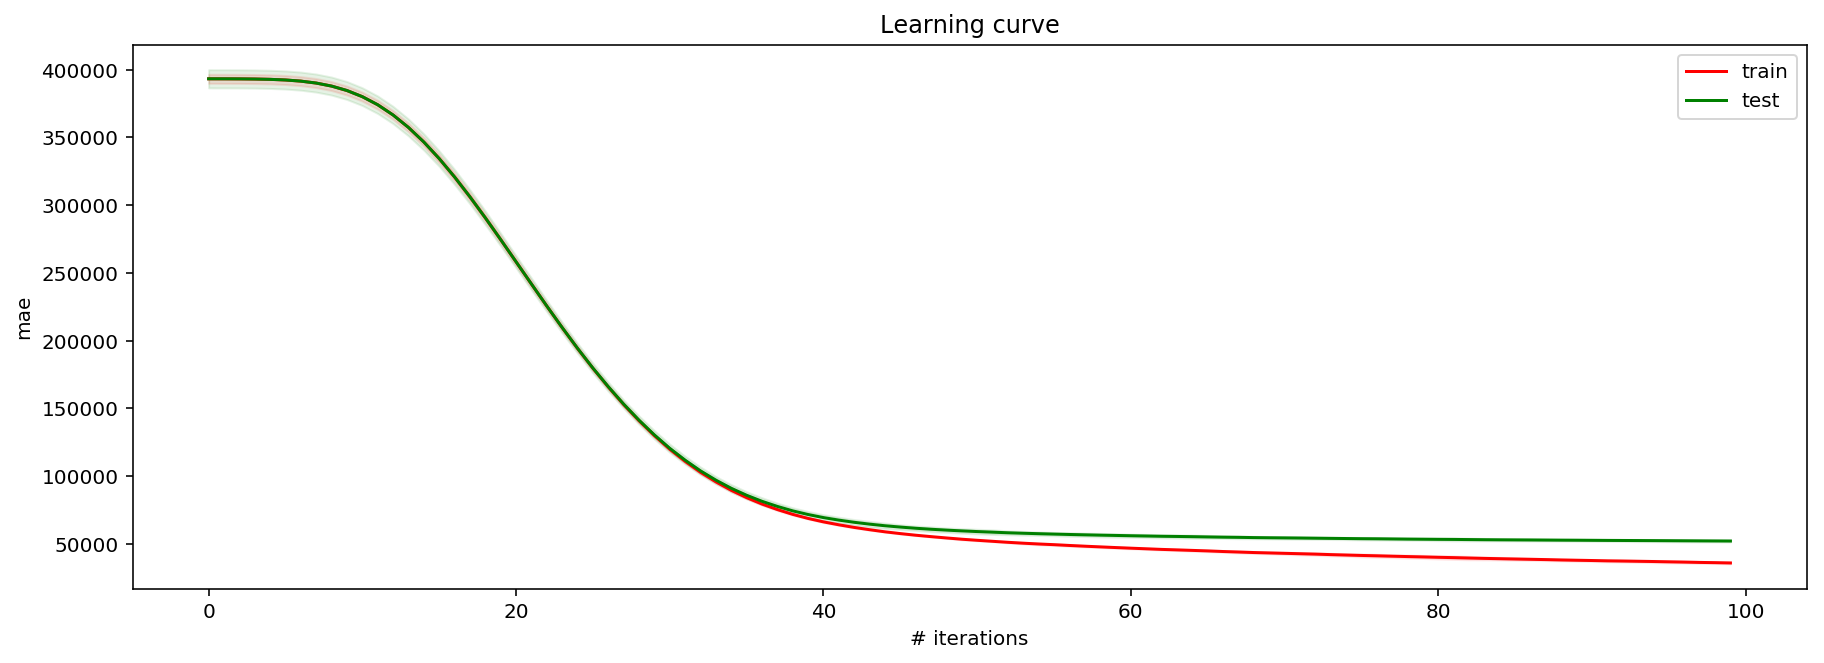

score: 52107.82763798543 246.7943129576618
{'max_depth': 17, 'colsample_bytree': 0.7397423069534952, 'learning_rate': 0.13402766855890577, 'subsample': 0.871359852852428, 'seed': 2018, 'min_child_weight': 30, 'reg_alpha': 2.0976620810927638, 'reg_lambda': 0.8961634137263409, 'n_estimators': 100}


3it [01:13, 24.49s/it]


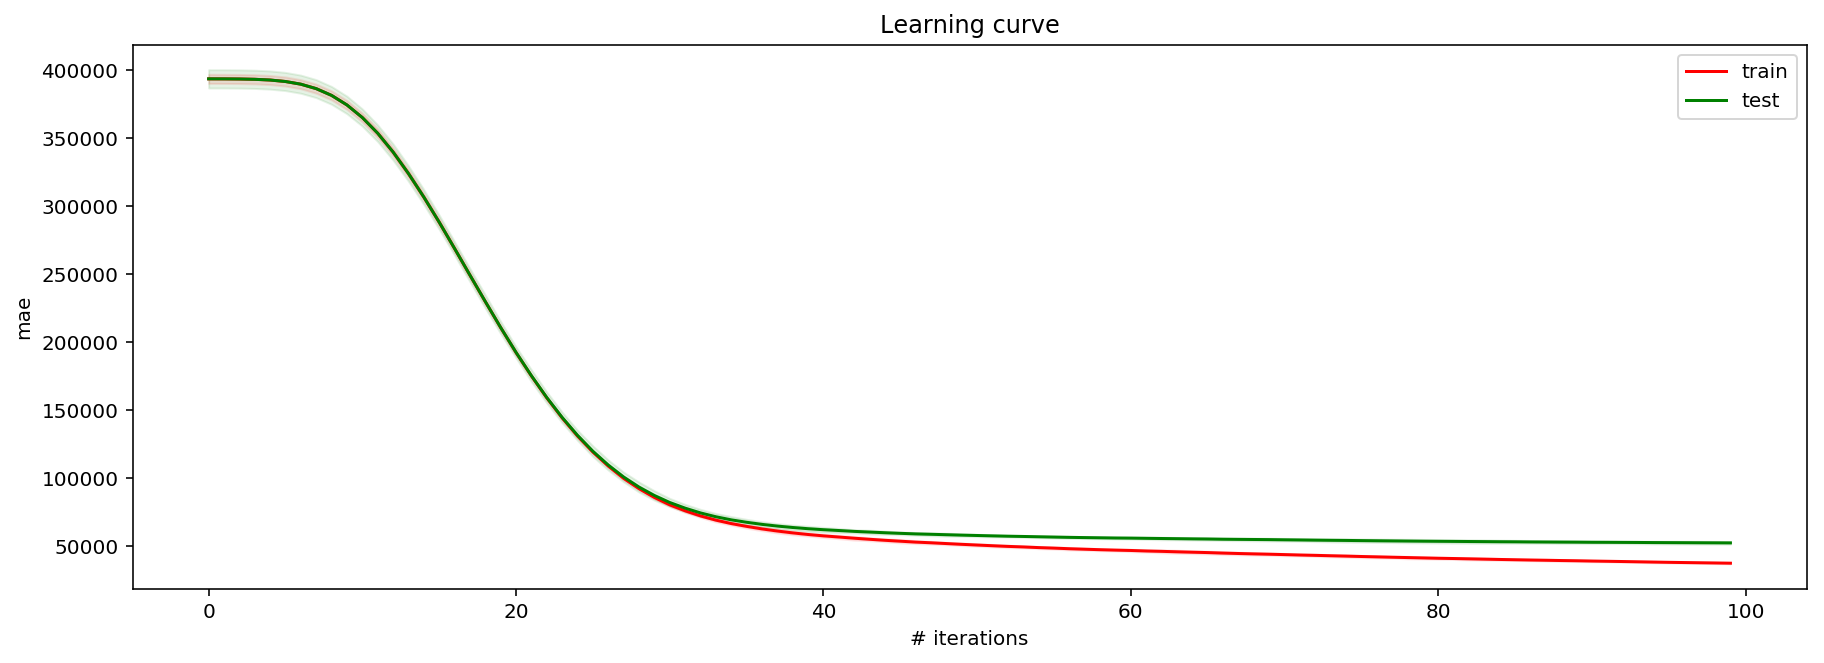

score: 52411.47495468331 329.9177958575524
{'max_depth': 19, 'colsample_bytree': 0.610509105128006, 'learning_rate': 0.15346646710574297, 'subsample': 0.8193953558959419, 'seed': 2018, 'min_child_weight': 70, 'reg_alpha': 1.688309255746156, 'reg_lambda': 0.8295284131169749, 'n_estimators': 100}


3it [01:05, 21.99s/it]


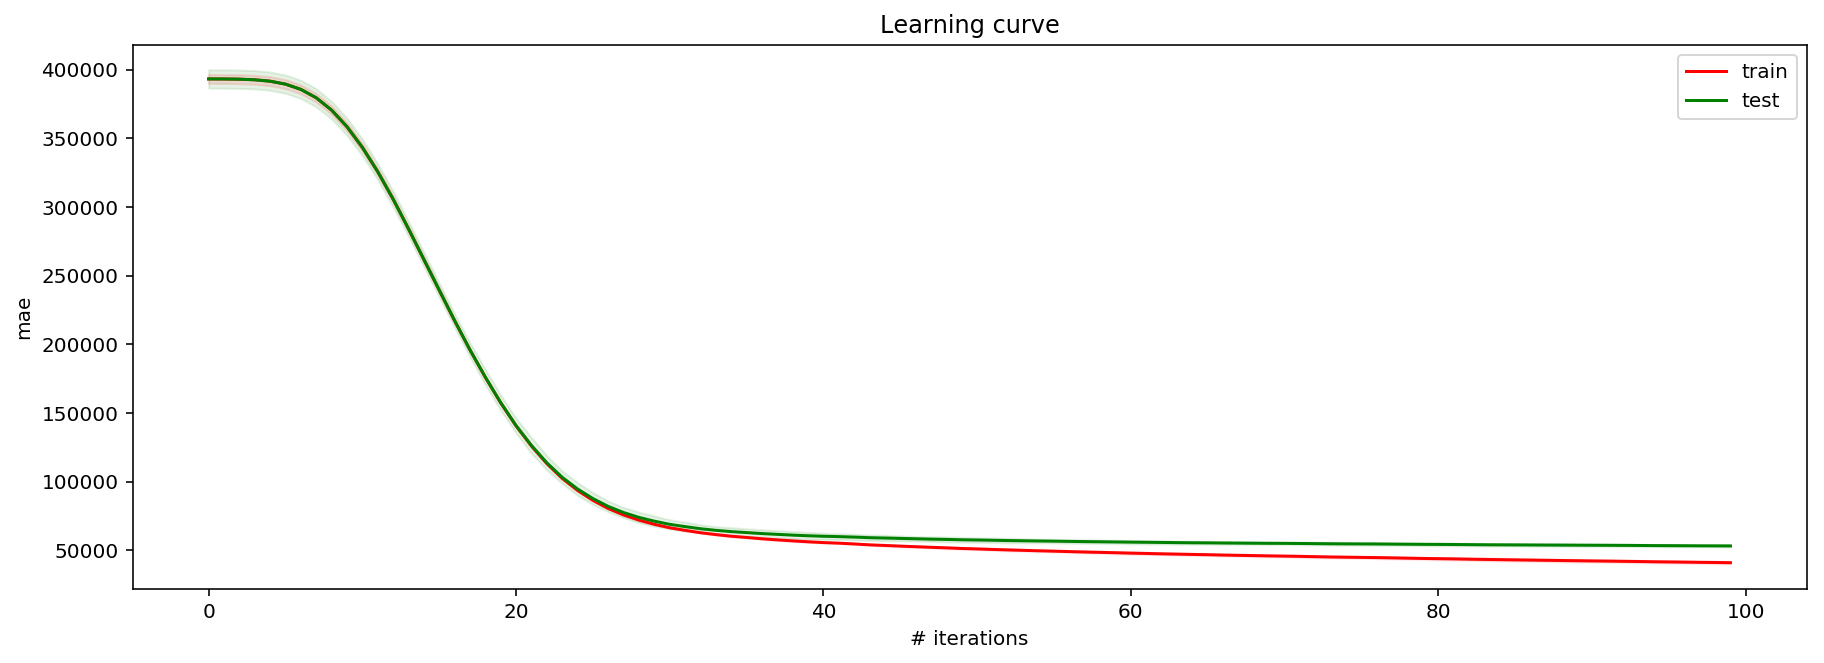

score: 53143.90391056965 271.3668309083899
{'max_depth': 12, 'colsample_bytree': 0.46309129412647915, 'learning_rate': 0.09616489181634172, 'subsample': 0.9539832504780785, 'seed': 2018, 'min_child_weight': 20, 'reg_alpha': 1.4319380459106943, 'reg_lambda': 0.8597772522947447, 'n_estimators': 100}


3it [00:37, 12.43s/it]


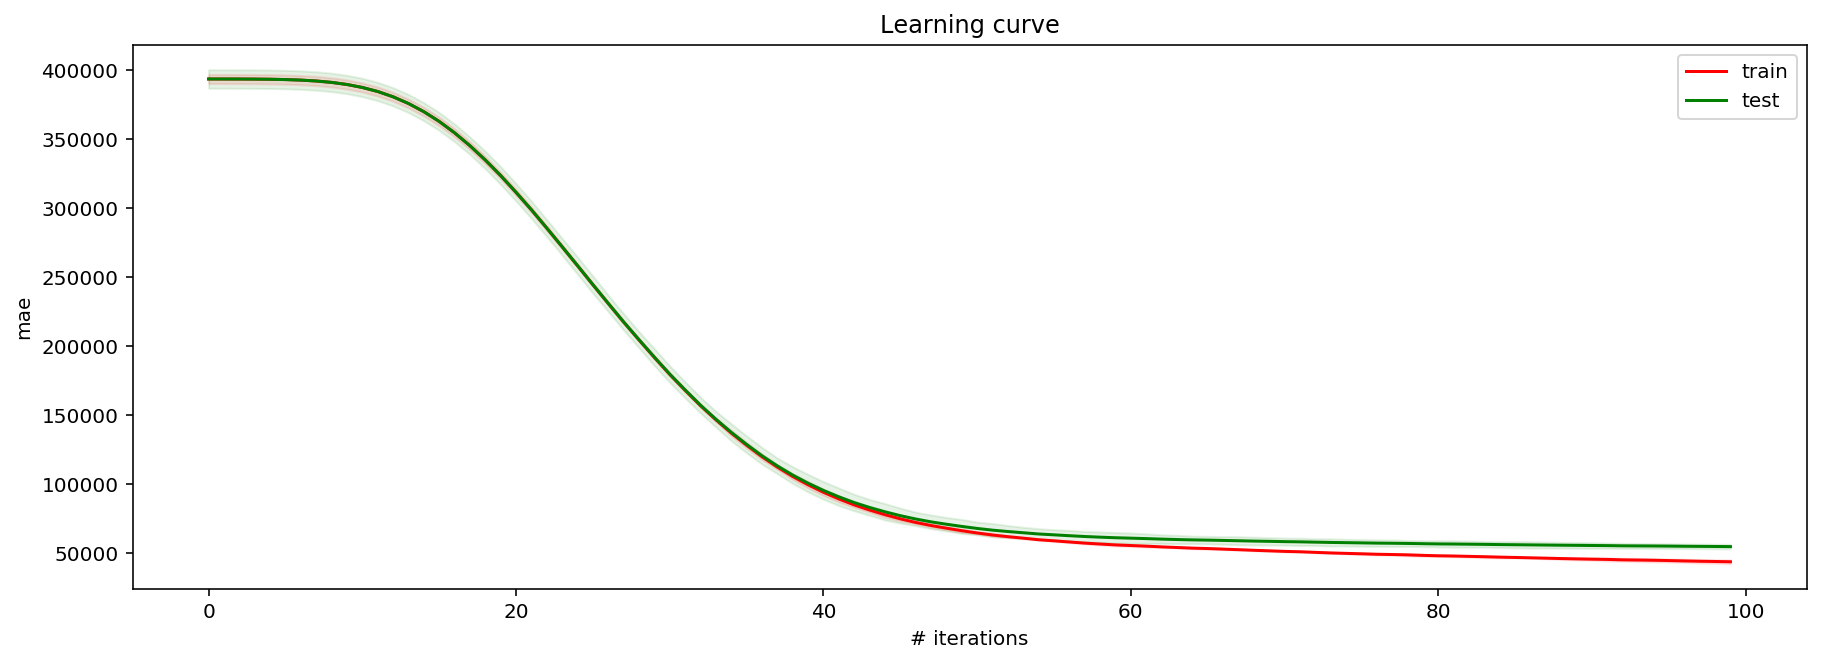

score: 54888.17396383159 550.0162562388522
{'max_depth': 8, 'colsample_bytree': 0.5514282390102921, 'learning_rate': 0.07670064218292738, 'subsample': 0.8964651076210464, 'seed': 2018, 'min_child_weight': 40, 'reg_alpha': 2.002247831960212, 'reg_lambda': 0.8187034641091057, 'n_estimators': 100}


3it [00:30, 10.17s/it]


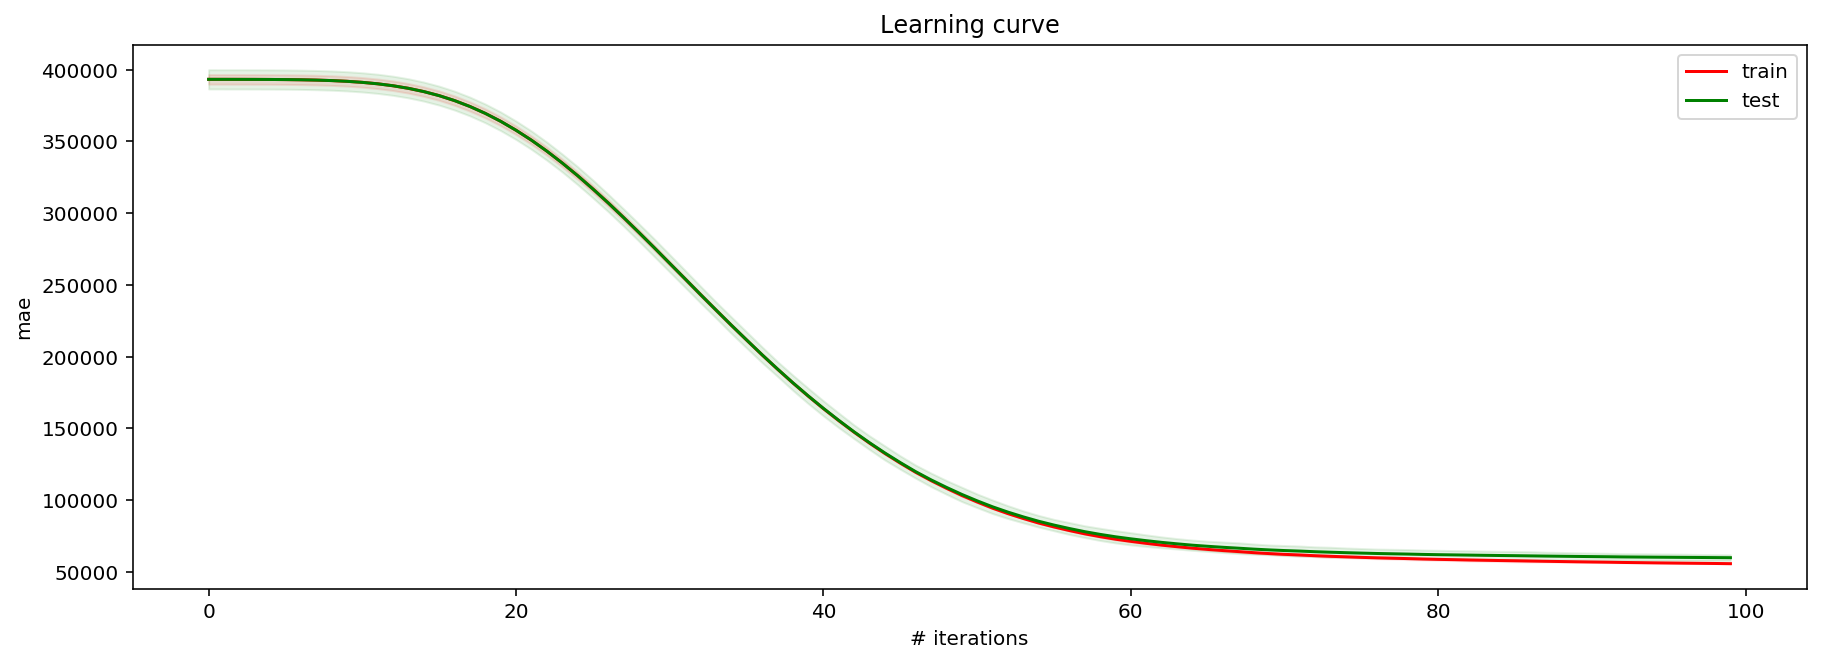

score: 59891.04257468723 665.8632532814809
The best params:  {'x_colsample_bytree': 0.5795616386315301, 'x_learning_rate': 0.13720524487498395, 'x_max_depth': 19.0, 'x_min_child_weight': 10.0, 'x_reg_alpha': 1.876207266050361, 'x_reg_lambda': 0.8795183250965093, 'x_seed': 6200.0, 'x_subsample': 0.9561032116929525}


In [520]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': 2018, #int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 100,
    }
    
    print(xgb_params)
    
    feats = all_features
    mean_score, std_score = cv_xgb(dane_do_testu.loc[~dane_do_testu.price.isnull()], imp_features, xgb_params, shift=1, plot_lc=True)
    
    print("score:", mean_score, std_score)
    
    return{'loss':mean_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.2, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.6, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 10, 200, 10),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
#     'shift': hp.quniform ('x_shift', 1, 70000, 10000),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

In [508]:
imp_features = [all_features[i] for i in np.argsort(perm.feature_importances_)[::-1] if perm.feature_importances_[i]>0.0002]
imp_features

['area',
 'price_mean_kernel',
 'price_mean',
 'price_median',
 'rok_budowy',
 'rooms',
 30,
 'rodzaj_zabudowy_cat',
 'winda',
 'is_primary_market',
 171,
 'ogrzewanie_cat',
 353,
 'loc_longitude',
 'loc_latitude',
 52,
 150,
 398,
 31,
 'price_mode',
 'balkon',
 74,
 33,
 'floors_in_building',
 120,
 210,
 330,
 'city_cat',
 433,
 27,
 'floor',
 'voivodeship_cat',
 'meble',
 274,
 388,
 457,
 290,
 'floors_in_building_norm',
 350,
 459,
 364,
 'czynsz',
 446,
 452,
 149,
 145,
 458,
 360,
 156,
 'klimatyzacja',
 'building_type_cat',
 220,
 456,
 'apartament_last_floor',
 382,
 35,
 'price_median_floor',
 'monitoring___ochrona',
 299,
 170,
 195,
 276,
 'is_private',
 233,
 189,
 'loc_kernel',
 468,
 0,
 116,
 88]